In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import json
import ast
from matplotlib.ticker import FuncFormatter
import glob
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import scipy
from scipy.stats import entropy
from sklearn import manifold
from adjustText import adjust_text
from mpl_toolkits import mplot3d
import networkx as nx
import os.path as osp
from sklearn import tree
import graphviz
from sklearn.metrics import classification_report
from itertools import product


In [2]:
#plt.style.use('seaborn-white')
plt.style.use('seaborn')
# for matplotlib xkcd I need to install new font without root, like this: 
#https://community.linuxmint.com/tutorial/view/29
# and then ivalidate cache like this: 
#https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176#22812176
# or by deleting by: rm ~/.cache/matplotlib -r
# the font ttf file must be in ~/.fonts/fonts/truetype/humor-sans directory

# to recover from xkcd
#mpl.rcParams.update(saved_state)

# to save state and go to xkcd
#saved_state = mpl.rcParams.copy()
#plt.xkcd()


In [3]:
# cleaned data are good for user anylysis but not for anime analysis. For users, around 200k animelist records were discarded, over 30m records remainded.
animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv')
animelists = pd.read_csv('animelists_cleaned.csv')

In [4]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [5]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')


In [6]:
users['age'] = 2018 - users['birth_date'].dt.year

In [7]:
animes.head()

title              title_english title_japanese  \
anime_id                                                                  
11013           Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104         Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
5262       Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   
721             Princess Tutu              Princess Tutu      プリンセスチュチュ   
12365     Bakuman. 3rd Season                   Bakuman.          バクマン。   

                                         title_synonyms  \
anime_id                                                  
11013                                   Youko x Boku SS   
2104                               The Inland Sea Bride   
5262      Shugo Chara Ninenme, Shugo Chara! Second Year   
721                                                 NaN   
12365                                  Bakuman Season 3   

                                                  image_url type    source  \
anime_id                                                                     
11013     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
2104      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
5262      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
721       https://myanimelist.cdn-dena.com/images/anime/...   TV  Original   
12365     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   

          episodes           status  airing       ...         \
anime_id                                          ...          
11013           12  Finished Airing   False       ...          
2104            26  Finished Airing   False       ...          
5262            51  Finished Airing   False       ...          
721             38  Finished Airing   False       ...          
12365           25  Finished Airing   False       ...          

                   broadcast  \
anime_id                       
11013     Fridays at Unknown   
2104                 Unknown   
5262                 Unknown   
721       Fridays at Unknown   
12365                Unknown   

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
721                  ['"Morning G

In [8]:
animelists.head()

username  anime_id  my_watched_episodes my_start_date my_finish_date  \
0  karthiga        21                  586    0000-00-00     0000-00-00   
1  karthiga        59                   26    0000-00-00     0000-00-00   
2  karthiga        74                   26    0000-00-00     0000-00-00   
3  karthiga       120                   26    0000-00-00     0000-00-00   
4  karthiga       178                   26    0000-00-00     0000-00-00   

   my_score  my_status  my_rewatching  my_rewatching_ep     my_last_updated  \
0         9          1            NaN                 0 2013-03-03 10:52:53   
1         7          2            NaN                 0 2013-03-10 13:54:51   
2         7          2            NaN                 0 2013-04-27 16:43:35   
3         7          2            NaN                 0 2013-03-03 10:53:57   
4         7          2            0.0                 0 2013-03-27 15:59:13   

  my_tags  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [9]:
users.head()

user_id  user_watching  user_completed  user_onhold  \
username                                                              
karthiga        2255153              3              49            1   
Damonashu         37326             45             195           27   
bskai            228342             25             414            2   
terune_uzumaki   327311              5               5            0   
Bas_G           5015094             35             114            6   

                user_dropped  user_plantowatch  user_days_spent_watching  \
username                                                                   
karthiga                   0                 0                 55.091667   
Damonashu                 25                59                 82.574306   
bskai                      5                11                159.483333   
terune_uzumaki             0                 0                 11.394444   
Bas_G                     20               175                 30.458333   

                gender             location birth_date  access_rank  \
username                                                              
karthiga        Female      Chennai, India  1990-04-29          NaN   
Damonashu         Male     Detroit,Michigan 1991-08-01          NaN   
bskai             Male      Nayarit, Mexico 1990-12-14          NaN   
terune_uzumaki  Female    Malaysia, Kuantan 1998-08-24          NaN   
Bas_G             Male  Nijmegen, Nederland 1999-10-24          NaN   

                join_date         last_online  stats_mean_score  \
username                                                          
karthiga       2013-03-03 2014-02-04 01:32:00              7.43   
Damonashu      2008-02-13 2017-07-10 06:52:54              6.15   
bskai          2009-08-31 2014-05-12 16:35:00              8.27   
terune_uzumaki 2010-05-10 2012-10-18 19:06:00              9.70   
Bas_G          2015-11-26 2018-05-10 20:53:37              7.86   

                stats_rewatched  stats_episodes  age  
username                                              
karthiga                    0.0            3391   28  
Damonashu                   6.0            4903   27  
bskai                       1.0            9701   28  
terune_uzumaki              6.0             697   20  
Bas_G                       0.0            1847   19

### comparison of all and active users
Active users are users with some ratings in last 3 months

In [10]:
# newest update date, reflects time of data gathering
now = animelists['my_last_updated'].max()
now

Timestamp('2018-05-22 07:49:06')

In [11]:
from dateutil.relativedelta import relativedelta
last_update = animelists.groupby('username')['my_last_updated'].max()
is_active = last_update > (now - relativedelta(months=3))
active_users = last_update[is_active].index

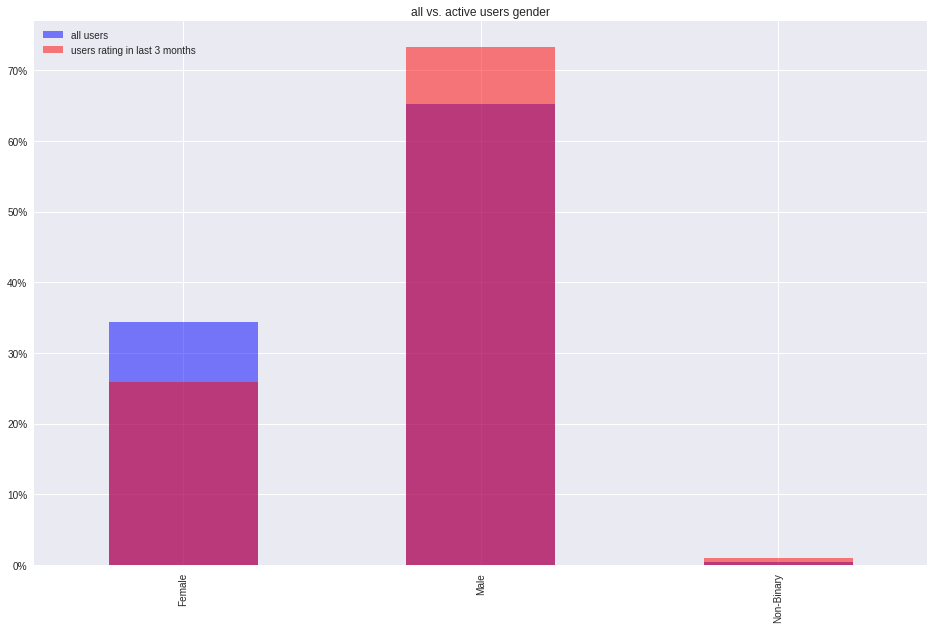

In [12]:
(users['gender'].value_counts() / users['gender'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users gender', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['gender'].value_counts() / users.loc[active_users]['gender'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

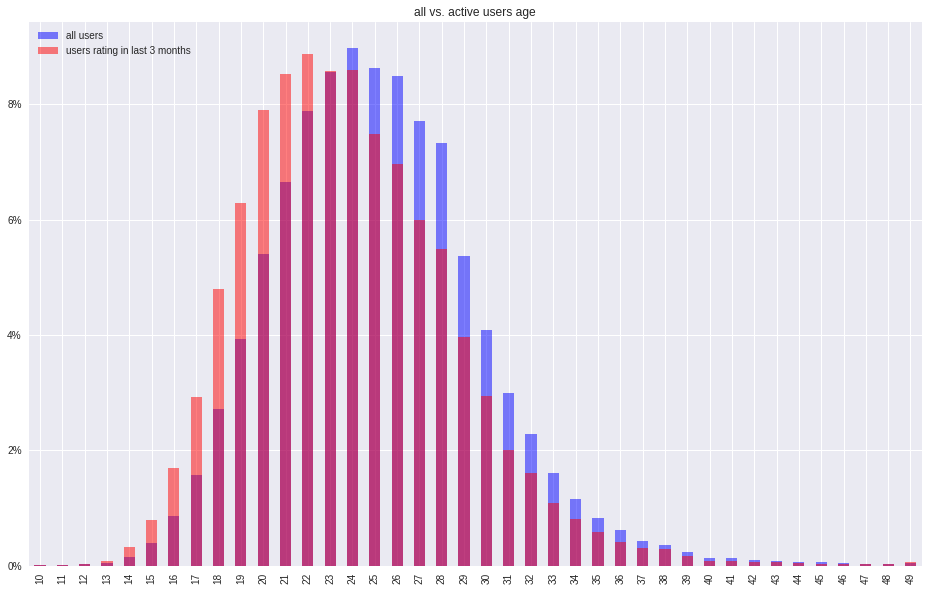

In [13]:
(users['age'].value_counts() / users['age'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users age', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['age'].value_counts() / users.loc[active_users]['age'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

### inspecing seen animes per all genres by age, gender etc.

In [14]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
genres_arr.index.levels[0].name = 'anime_id'
animes_genres = pd.merge(animes, genres_arr, how='left', left_index=True, right_index=True)
genres = genres_arr['genre'].unique()

In [15]:
animelists = animelists.join(animes['genres'], on='anime_id')

### this is just testing of functionality

In [16]:
#animelists.iloc[0:10][['anime_id', 'genres']]
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: print(x), axis=1)
#animelists.iloc[0:10].apply(lambda x: print(x))
#animelists.apply(lambda x: print(x['genre']))
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: print(type(x)))
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: print(x[1]), axis=1)
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: x[1].replace(' ', '').split(','), axis=1)
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1).apply(pd.Series).stack().to_frame(name='genre')

#genres_df = animelists.iloc[0:10]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
#genres_df.index.levels[0] = animelists.iloc[0:10]['anime_id']
#genres_df

#animelists.iloc[0:10]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).set_index(animelists.iloc[0:10]['anime_id']).stack().to_frame(name='genre')
lists_genres_pd = animelists.iloc[0:10]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
lists_ids_pd = animelists.iloc[0:10]['anime_id'].to_frame(name='anime_id')
lists_genres_pd.index.levels[0].name = 'anime_id'
lists_ids_pd.index.name = 'anime_id'
pd.merge(lists_genres_pd, lists_ids_pd, how='inner', left_index=True, right_index=True)

genre  anime_id
anime_id                          
0        0        Action        21
         1     Adventure        21
         2        Comedy        21
         3    SuperPower        21
         4         Drama        21
         5       Fantasy        21
         6       Shounen        21
1        0        Sci-Fi        59
         1        Comedy        59
         2         Drama        59
         3       Romance        59
         4         Ecchi        59
         5        Seinen        59
2        0        Comedy        74
         1        School        74
         2        Shoujo        74
         3    SuperPower        74
3        0   SliceofLife       120
         1        Comedy       120
         2         Drama       120
         3       Romance       120
         4       Fantasy       120
         5        Shoujo       120
4        0         Magic       178
         1        Comedy       178
         2       Romance       178
         3        School       178
         4        Shoujo       178
5        0   SliceofLife       210
         1        Comedy       210
         2   MartialArts       210
         3       Fantasy       210
6        0     Adventure       232
         1        Comedy       232
         2         Drama       232
         3         Magic       232
         4       Romance       232
         5       Fantasy       232
         6        School       232
         7        Shoujo       232
7        0        Comedy       233
         1        Sci-Fi       233
         2        Shoujo       233
8        0        Action       249
         1     Adventure       249
         2        Comedy       249
         3    Historical       249
         4        Demons       249
         5  Supernatural       249
         6         Magic       249
         7       Romance       249
         8       Fantasy       249
         9       Shounen       249
9        0        Action       269
         1     Adventure       269
         2        Comedy       269
         3    SuperPower       269
         4  Supernatural       269
         5       Shounen       269

In [17]:
animelists.iloc[0:10][['anime_id', 'genres']]

anime_id                                             genres
0        21  Action, Adventure, Comedy, Super Power, Drama,...
1        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen
2        74                Comedy, School, Shoujo, Super Power
3       120  Slice of Life, Comedy, Drama, Romance, Fantasy...
4       178             Magic, Comedy, Romance, School, Shoujo
5       210       Slice of Life, Comedy, Martial Arts, Fantasy
6       232  Adventure, Comedy, Drama, Magic, Romance, Fant...
7       233                             Comedy, Sci-Fi, Shoujo
8       249  Action, Adventure, Comedy, Historical, Demons,...
9       269  Action, Adventure, Comedy, Super Power, Supern...

### this is test of correctness

In [18]:
animelists.iloc[0:5]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')

genre
0 0       Action
  1    Adventure
  2       Comedy
  3   SuperPower
  4        Drama
  5      Fantasy
  6      Shounen
1 0       Sci-Fi
  1       Comedy
  2        Drama
  3      Romance
  4        Ecchi
  5       Seinen
2 0       Comedy
  1       School
  2       Shoujo
  3   SuperPower
3 0  SliceofLife
  1       Comedy
  2        Drama
  3      Romance
  4      Fantasy
  5       Shoujo
4 0        Magic
  1       Comedy
  2      Romance
  3       School
  4       Shoujo

In [19]:
indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:5][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
pd.Series([y for x in animelists.iloc[0:5]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')


genre
21  0       Action
    1    Adventure
    2       Comedy
    3   SuperPower
    4        Drama
    5      Fantasy
    6      Shounen
59  0       Sci-Fi
    1       Comedy
    2        Drama
    3      Romance
    4        Ecchi
    5       Seinen
74  0       Comedy
    1       School
    2       Shoujo
    3   SuperPower
120 0  SliceofLife
    1       Comedy
    2        Drama
    3      Romance
    4      Fantasy
    5       Shoujo
178 0        Magic
    1       Comedy
    2      Romance
    3       School
    4       Shoujo

In [20]:
pd.DataFrame([(x[0], y) for i, x in enumerate(animelists.iloc[0:5][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in x[1]], columns=['anime_id', 'genre'])


anime_id        genre
0         21       Action
1         21    Adventure
2         21       Comedy
3         21   SuperPower
4         21        Drama
5         21      Fantasy
6         21      Shounen
7         59       Sci-Fi
8         59       Comedy
9         59        Drama
10        59      Romance
11        59        Ecchi
12        59       Seinen
13        74       Comedy
14        74       School
15        74       Shoujo
16        74   SuperPower
17       120  SliceofLife
18       120       Comedy
19       120        Drama
20       120      Romance
21       120      Fantasy
22       120       Shoujo
23       178        Magic
24       178       Comedy
25       178      Romance
26       178       School
27       178       Shoujo

In [21]:
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre').reset_index().drop(['level_1'], axis=1)
display(genres_arr.iloc[0:10])
merged = pd.merge(animelists.iloc[0:10], genres_arr, how='left', on='anime_id')
merged[['username', 'anime_id', 'genres', 'genre']]

anime_id         genre
0     11013        Comedy
1     11013  Supernatural
2     11013       Romance
3     11013       Shounen
4      2104        Comedy
5      2104        Parody
6      2104       Romance
7      2104        School
8      2104       Shounen
9      5262        Comedy

username  anime_id                                             genres  \
0   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
1   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
2   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
3   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
4   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
5   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
6   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
7   karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
8   karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
9   karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
10  karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
11  karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
12  karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
13  karthiga        74                Comedy, School, Shoujo, Super Power   
14  karthiga        74                Comedy, School, Shoujo, Super Power   
15  karthiga        74                Comedy, School, Shoujo, Super Power   
16  karthiga        74                Comedy, School, Shoujo, Super Power   
17  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
18  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
19  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
20  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
21  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
22  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
23  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
24  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
25  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
26  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
27  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
28  karthiga       210       Slice of Life, Comedy, Martial Arts, Fantasy   
29  karthiga       210       Slice of Life, Comedy, Martial Arts, Fantasy   
30  karthiga       210       Slice of Life, Comedy, Martial Arts, Fantasy   
31  karthiga       210       Slice of Life, Comedy, Martial Arts, Fantasy   
32  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
33  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
34  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
35  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
36  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
37  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
38  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
39  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
40  karthiga       233                             Comedy, Sci-Fi, Shoujo   
41  karthiga       233                             Comedy, Sci-Fi, Shoujo   
42  karthiga       233                             Comedy, Sci-Fi, Shoujo   
43  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
44  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
45  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
46  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
47  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
48  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
49  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
50  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   


In [22]:
%%timeit
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
# 1.78 s ± 75.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack()
# 1.82 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series)
# 1.66 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(','))
# 12 ms ± 825 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# pd.Series([(i, y) for i, x in enumerate(animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(','))) for y in x])
# 17.7 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# indices = pd.MultiIndex.from_tuples([(animelists.iloc[i]['anime_id'], y) for i, x in enumerate(animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(','))) for y, _ in enumerate(x)])
# pd.Series([y for x in animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')
# 42.2 ms ± 566 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# wow, nice, by two list comprehensions I speed up from 1.8s to 40ms, which is 45x faster
# but not correct, I need anime id along with it

#### the measuring above is old, need newer one
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
# 1.87 s ± 86.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(animelists.iloc[i]['anime_id'], y) for i, x in enumerate(animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(','))) for y, _ in enumerate(x)])
# 8.86 s ± 307 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:10000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
# 391 ms ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:10000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in range(len(x[1]))])
# 373 ms ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:10000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
# pd.Series([y for x in animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')
# 392 ms ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#pd.DataFrame([(x[0], y) for i, x in enumerate(animelists.iloc[0:10000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in x[1]], columns=['anime_id', 'genre'])
# 347 ms ± 7.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# I have small speedup when I don't use multiindex, but just use two columns
# very nice, I speedup from 1.87s to 392ms, which is 4.7x faster. Not as good, but still ok
# even nicer, without multiindex, I speedup from 1.87s to 347ms, which is 5.4x faster, slightly better

# I join genres, so I just use genres from animes csv and join them here, that is much smaller than animelists csv, so it is faster
pd.merge(animelists.iloc[0:10000], genres_arr, how='left', on='anime_id')
# 16.6 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# wow, great, with that approach, I speedup from 1.87s to 16ms, which is 112x faster, that could finally actually work. 
# 20x speedup compared to previous attempt


14 ms ± 84.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit
# now trying for 10^5 elements
# animelists.iloc[0:100000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
# 18 s ± 592 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:100000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
# pd.Series([y for x in animelists.iloc[0:100000]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')
# 3.75 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# pd.DataFrame([(x[0], y) for i, x in enumerate(animelists.iloc[0:100000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in x[1]], columns=['anime_id', 'genre'])
# 3.52 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# wow, nice, I speed up from 18s to 3.49s, which is 5.1x faster only half order of magnitude, but speedup seems to scale well
# so, I tried directly dataframe, times are close, but maybe will be more seen during million elements iteration
pd.merge(animelists.iloc[0:100000], genres_arr, how='left', on='anime_id')
# 132 ms ± 8.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# heureka, seems to scale, 26x faster than previous approach

121 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%%timeit
# trying for 1 million
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:1000 000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
# pd.Series([y for x in animelists.iloc[0:1000000]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')
# 37 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# pd.DataFrame([(x[0], y) for i, x in enumerate(animelists.iloc[0:1000000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in x[1]], columns=['anime_id', 'genre'])
# 35.7 s ± 796 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pd.merge(animelists.iloc[0:1000000], genres_arr, how='left', on='anime_id')
# 2.29 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# even in one million, 15x faster. Seems to be slower on higher numbers, but still fast enough

2.13 s ± 5.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
animelists_genres = pd.merge(animelists, genres_arr, how='left', on='anime_id')

In [26]:
animelists_genres.head()

username  anime_id  my_watched_episodes my_start_date my_finish_date  \
0  karthiga        21                  586    0000-00-00     0000-00-00   
1  karthiga        21                  586    0000-00-00     0000-00-00   
2  karthiga        21                  586    0000-00-00     0000-00-00   
3  karthiga        21                  586    0000-00-00     0000-00-00   
4  karthiga        21                  586    0000-00-00     0000-00-00   

   my_score  my_status  my_rewatching  my_rewatching_ep     my_last_updated  \
0         9          1            NaN                 0 2013-03-03 10:52:53   
1         9          1            NaN                 0 2013-03-03 10:52:53   
2         9          1            NaN                 0 2013-03-03 10:52:53   
3         9          1            NaN                 0 2013-03-03 10:52:53   
4         9          1            NaN                 0 2013-03-03 10:52:53   

  my_tags                                             genres       genre  
0     NaN  Action, Adventure, Comedy, Super Power, Drama,...      Action  
1     NaN  Action, Adventure, Comedy, Super Power, Drama,...   Adventure  
2     NaN  Action, Adventure, Comedy, Super Power, Drama,...      Comedy  
3     NaN  Action, Adventure, Comedy, Super Power, Drama,...  SuperPower  
4     NaN  Action, Adventure, Comedy, Super Power, Drama,...       Drama

In [27]:
#%%timeit
#animelists_genres[animelists_genres['genre'] == 'Comedy'].groupby('username')['genre'].count()  # takes about 20s

In [28]:
animelists_genres['my_status'].value_counts()


2     89768041
6     31835543
1      6988523
4      5486788
3      5437355
0          840
5           16
33          14
55           4
Name: my_status, dtype: int64

In [29]:
# semantics of my_status column
status = {
    'watching': 1,
    'completed': 2,
    'on hold': 3,
    'dropped': 4,
    'plan to watch': 6,
}

In [30]:
if osp.exists('users_calculated.csv'):
    users = pd.read_csv('users_calculated.csv')
    users = users.set_index('username')
else:
    # handcrafted features
    genres_columns = ['completed_'+x for x in genres]
    completed = (animelists_genres['my_status'] == status['completed'])
    for genre_column, genre in zip(genres_columns, genres):
        users[genre_column] = animelists_genres[(animelists_genres['genre'] == genre) & completed].groupby('username')['genre'].count()
    
    genres_columns = ['dropped_'+x for x in genres]
    dropped = (animelists_genres['my_status'] == status['dropped'])
    for genre_column, genre in zip(genres_columns, genres):
        users[genre_column] = animelists_genres[(animelists_genres['genre'] == genre) & dropped].groupby('username')['genre'].count()
    
    genres_columns = ['meanscore_'+x for x in genres]
    rated = (animelists_genres['my_score'] != 0)
    for genre_column, genre in zip(genres_columns, genres):
        users[genre_column] = animelists_genres[(animelists_genres['genre'] == genre) & completed & rated].groupby('username')['my_score'].mean()
    
    completed = (animelists['my_status'] == status['completed'])
    dropped = (animelists['my_status'] == status['dropped'])
    rated = (animelists['my_score'] != 0)
    users['all_completed'] = animelists[completed].groupby('username')['anime_id'].count()
    users['all_dropped'] = animelists[dropped].groupby('username')['anime_id'].count()
    users['all_meanscore'] = animelists[completed & rated].groupby('username')['my_score'].mean()

    users.reset_index().to_csv('users_calculated.csv', index=False, sep=',', encoding='utf-8')

### analyzing users and genres now when I have features for genres per user

In [259]:
completed_columns = sorted(['completed_'+x for x in genres])
completed_columns.remove('completed_')  # removed empty genre
users[completed_columns] = users[completed_columns].fillna(0)  # without this, NaN values are ommited from mean calculation, which messes up data a lot
# semantically, NaN is zero, because it means that user has no completed anime of that genre
users_completed = users[completed_columns].div(users['all_completed'], axis=0).fillna(0)
users_ages_completed = users_completed.join(users['age'])
ages_genres = users_ages_completed.groupby('age').mean()
users_genders_completed = users_completed.join(users['gender'])
genders_genres = users_genders_completed.groupby('gender').mean()

In [119]:
# now try the histogram equalization on colormap to better show data
# histogram equalization taken from https://github.com/jobar8/graphics/blob/master/graphics.py and modified little bit
from skimage import exposure

def cmap_to_array(cmap,N=256):
    """
    Return a Nx3 array of RGB values generated from a colormap.
    """
    return cmap(np.linspace(0, 1, N))[:,:3] # remove alpha column

def equalize_colormap(cmap, data, name='EqualizedMap'):
    if type(data) is pd.DataFrame:
        data = data.as_matrix()
    data = data[~np.isnan(data)].flatten()
    cdf, bins = exposure.cumulative_distribution(data, nbins=256)
    # Using it for highly non-uniform data will cause high information loss for extreme values
    #So we do only half equalization, equalizing with histogram averaged with uniform histogram
    # and now the same for uniform distribution of same size
    cdf_u, bins_u = exposure.cumulative_distribution(np.linspace(data.min(), data.max(), data.shape[0]),nbins=256)
    cdf = (cdf + cdf_u) / 2
    '''
    Re-map a colormap according to a cumulative distribution. This is used to 
    perform histogram equalization of an image by changing the colormap 
    instead of the image. *This is not strickly speaking the equalization of the 
    colormap itself*.
    The cdf and bins should be calculated from an input image, as if carrying out
    the histogram equalization of that image. In effect, the cdf becomes integrated  
    to the colormap as a mapping function by redistributing the indices of the
    input colormap.
    
    Parameters
    ----------
    cmap : string or colormap object
        Input colormap to remap.
    bins : array
        Centers of bins.
    cdf : array
        Values of cumulative distribution function.
    '''
    
    # first retrieve the color table (lists of RGB values) behind the input colormap
    if cmap in mpl.cm.cmap_d: # matplotlib colormaps + plus the new ones (viridis, inferno, etc.)
        cmList = cmap_to_array(cm.cmap_d[cmap])
    else:
        try:
            # in case cmap is a colormap object
            cmList = cmap_to_array(cmap) 
        except:
            raise ValueError('Colormap {} has not been recognised'.format(cmap))
    
    # normalize the input bins to interval (0,1)
    bins_norm = (bins - bins.min())/np.float(bins.max() - bins.min())
    
    # calculate new indices by applying the cdf as a function on the old indices
    # which are initially regularly spaced. 
    old_indices = np.linspace(0,1,len(cmList))
    new_indices = np.interp(old_indices,cdf,bins_norm)
    
    # make sure indices start with 0 and end with 1
    new_indices[0] = 0.0
    new_indices[-1] = 1.0
    
    # remap the color table
    cdict = {'red': [], 'green': [], 'blue': []}
    for i,n in enumerate(new_indices):
        r1, g1, b1 = cmList[i]
        cdict['red'].append([n, r1, r1])
        cdict['green'].append([n, g1, g1])
        cdict['blue'].append([n, b1, b1])
        
    return mpl.colors.LinearSegmentedColormap(name, cdict)


Text(0.5,1,'genre percentage in animelists')

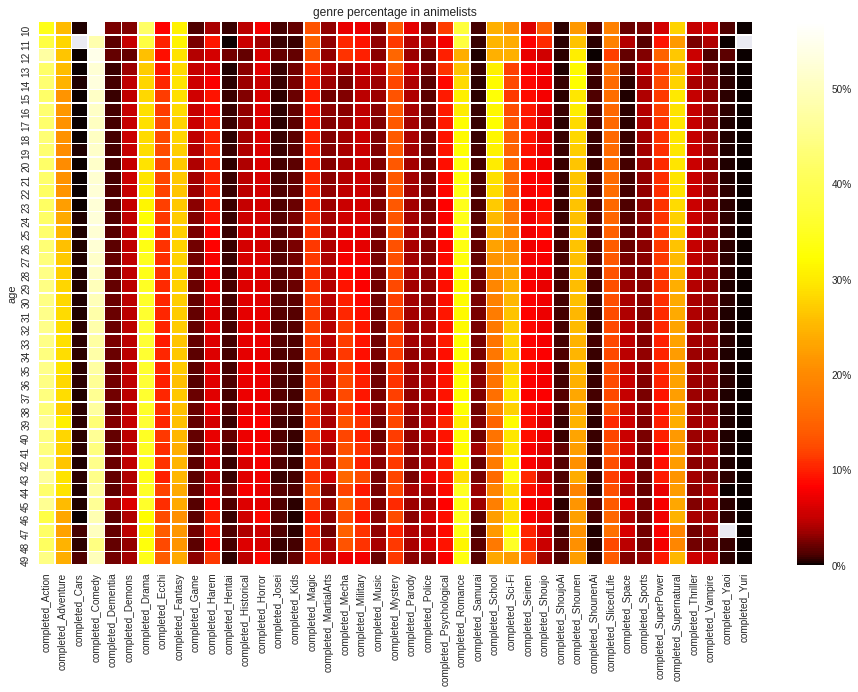

In [120]:
f, ax = plt.subplots(figsize=(16, 10))
#data = ages_genres.div(ages_genres.sum(axis=1), axis=0) * 100
data = ages_genres * 100
cmap = equalize_colormap(plt.cm.hot, data)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=cmap, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('genre percentage in animelists')

Text(0.5,1,'histograms normed per genre')

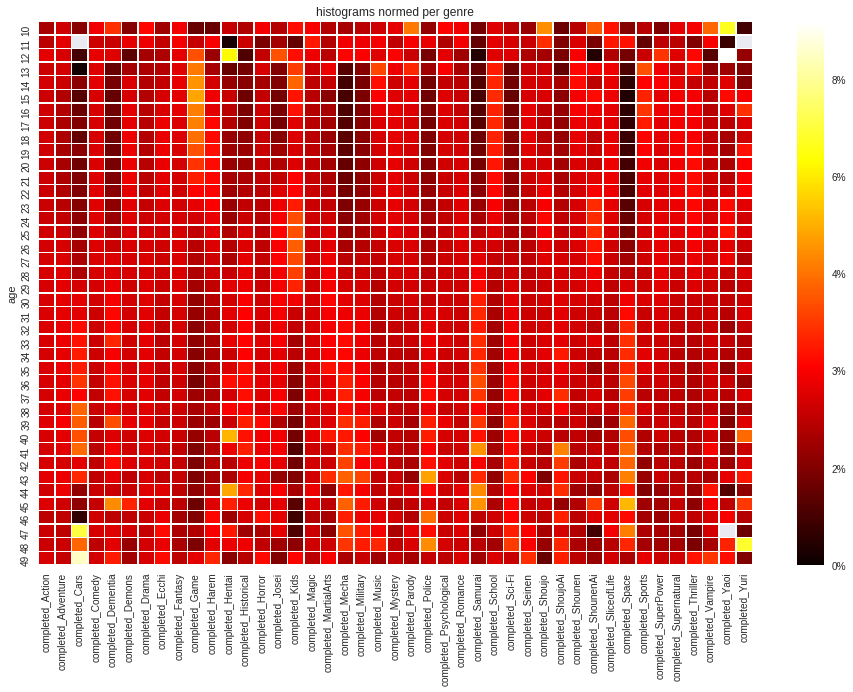

In [121]:
f, ax = plt.subplots(figsize=(16, 10))
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
#data = ages_genres * 100
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=plt.cm.hot, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('histograms normed per genre')

In [122]:
users[['all_completed', 'age', 'gender'] + completed_columns]

all_completed  age  gender  completed_Action  \
username                                                         
karthiga                   49.0   28  Female               7.0   
Damonashu                 188.0   27    Male             103.0   
bskai                     378.0   28    Male             130.0   
terune_uzumaki              5.0   20  Female               0.0   
Bas_G                     113.0   19    Male              58.0   
HimeAria                   84.0   22  Female              25.0   
Skallington                 3.0   27    Male               0.0   
Slimak                    222.0   30    Male             169.0   
Elysiun                     4.0   34    Male               3.0   
jimothy000                  NaN   23    Male               0.0   
MistButterfly            3011.0   26  Female            1118.0   
ProperBritish             225.0   26    Male              50.0   
kioniel                   405.0   30    Male             218.0   
Xinil                     213.0   33    Male              87.0   
helenply                  184.0   19  Female              51.0   
hood_rad                  309.0   21    Male              75.0   
detestedlove311            29.0   29  Female              17.0   
ihasabucket               145.0   34    Male              59.0   
xTheFallenx               608.0   25    Male             246.0   
L-LawlietDN                 NaN   23    Male               0.0   
zZKinhoZz                  65.0   18    Male              28.0   
glittermilk                33.0   24  Female              12.0   
Lithuelle                 139.0   33  Female              42.0   
scootarski                252.0   34    Male              88.0   
Yukia-Kontan               12.0   28    Male               4.0   
Akihara                   586.0   24  Female             284.0   
Tomoki-sama               334.0   22    Male             154.0   
Sakurei                   594.0   15  Female             202.0   
raickos                   166.0   29    Male              92.0   
Spike                     341.0   24  Female             158.0   
...                         ...  ...     ...               ...   
NessaIero                 235.0   23  Female              69.0   
TsuyoiTamashi231          266.0   20    Male             144.0   
Falco2424                 128.0   24    Male              73.0   
Theasn                    144.0   22    Male              83.0   
Ray0flight                 27.0   23    Male               7.0   
adultswimfan88             34.0   30    Male              20.0   
Doraka                     26.0   21    Male              16.0   
BlackRockShtr              98.0   18    Male              41.0   
Sadpanda                  243.0   39    Male             156.0   
FateMaster                508.0   26    Male             263.0   
xsxeotakux                  6.0   27    Male               5.0   
Perzik                     90.0   21  Female              44.0   
Tenos                     125.0   25    Male              54.0   
Destiney                   62.0   26  Female              19.0   
Lost_Bullet                71.0   27  Female              43.0   
alesos                     70.0   31    Male              51.0   
Jarlath7                  361.0   22    Male             181.0   
M_Northstar                38.0   44    Male              22.0   
ZnamJendrka               223.0   19    Male              87.0   
kvothe96_                 317.0   22    Male             169.0   
Dusty9797                  86.0   21    Male              36.0   
assassin0202              178.0   27    Male             136.0   
ZeroFr3aK                 178.0   25    Male             113.0   
yoyoman9                   32.0   19    Male              13.0   
generalist                184.0   30    Male              36.0   
isoann                    208.0   21    Male              66.0   
bumcakee                  116.0   20  Female              23.0   
Scarlet95                 103.0   23  Female              

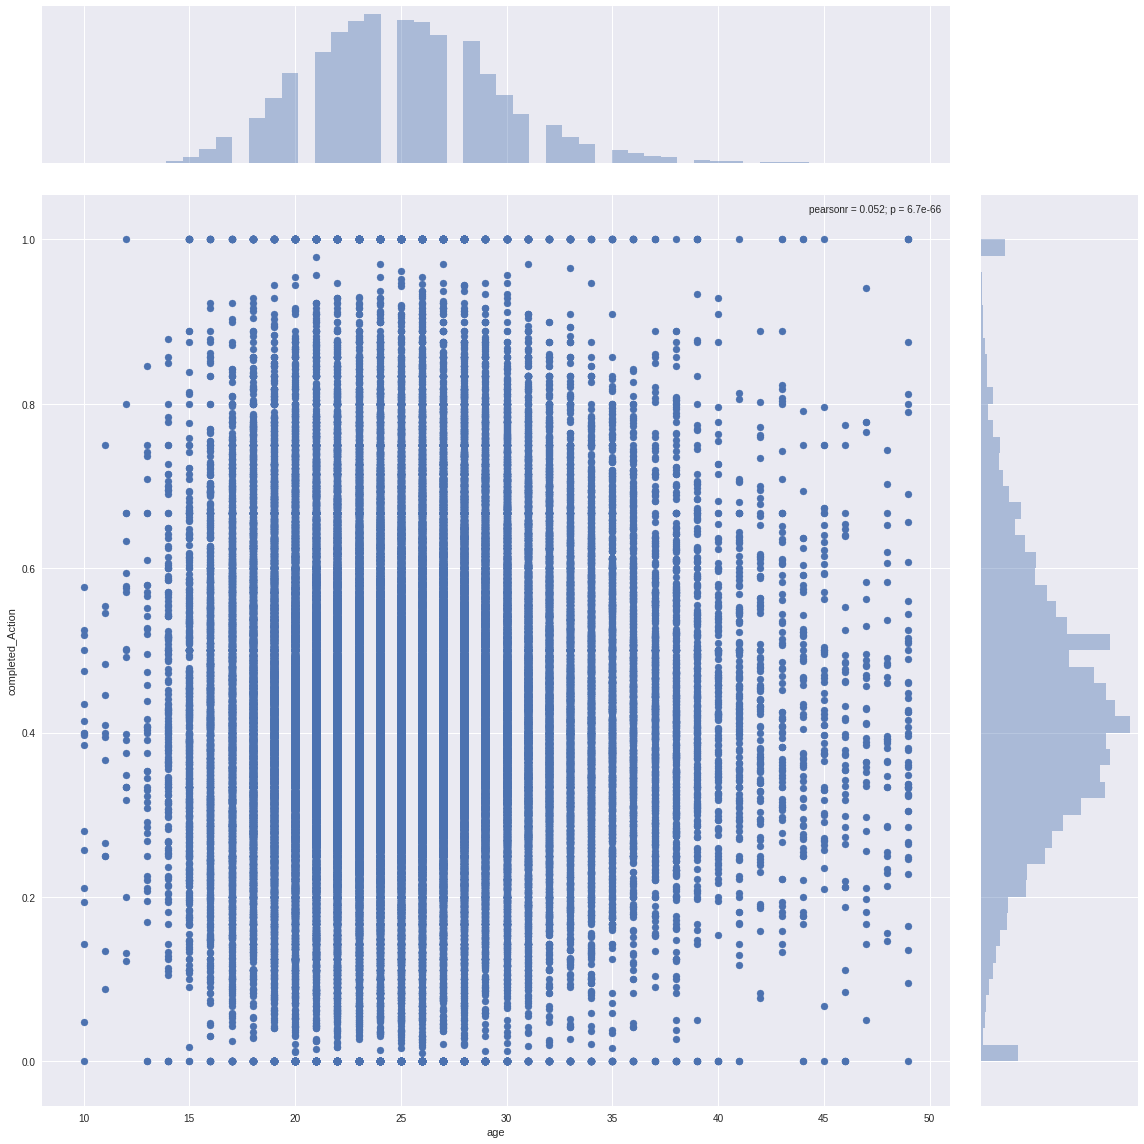

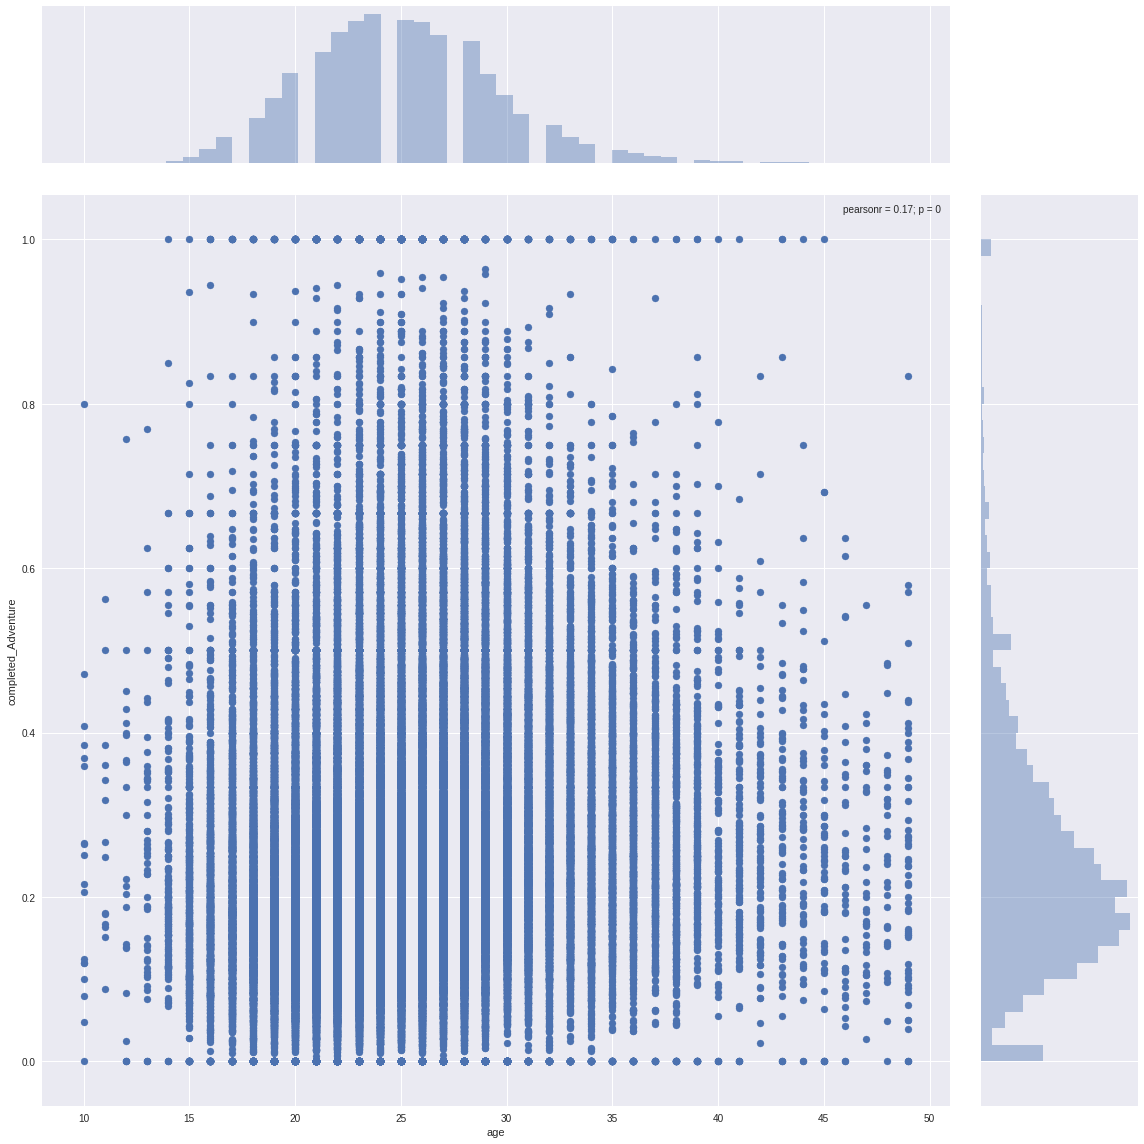

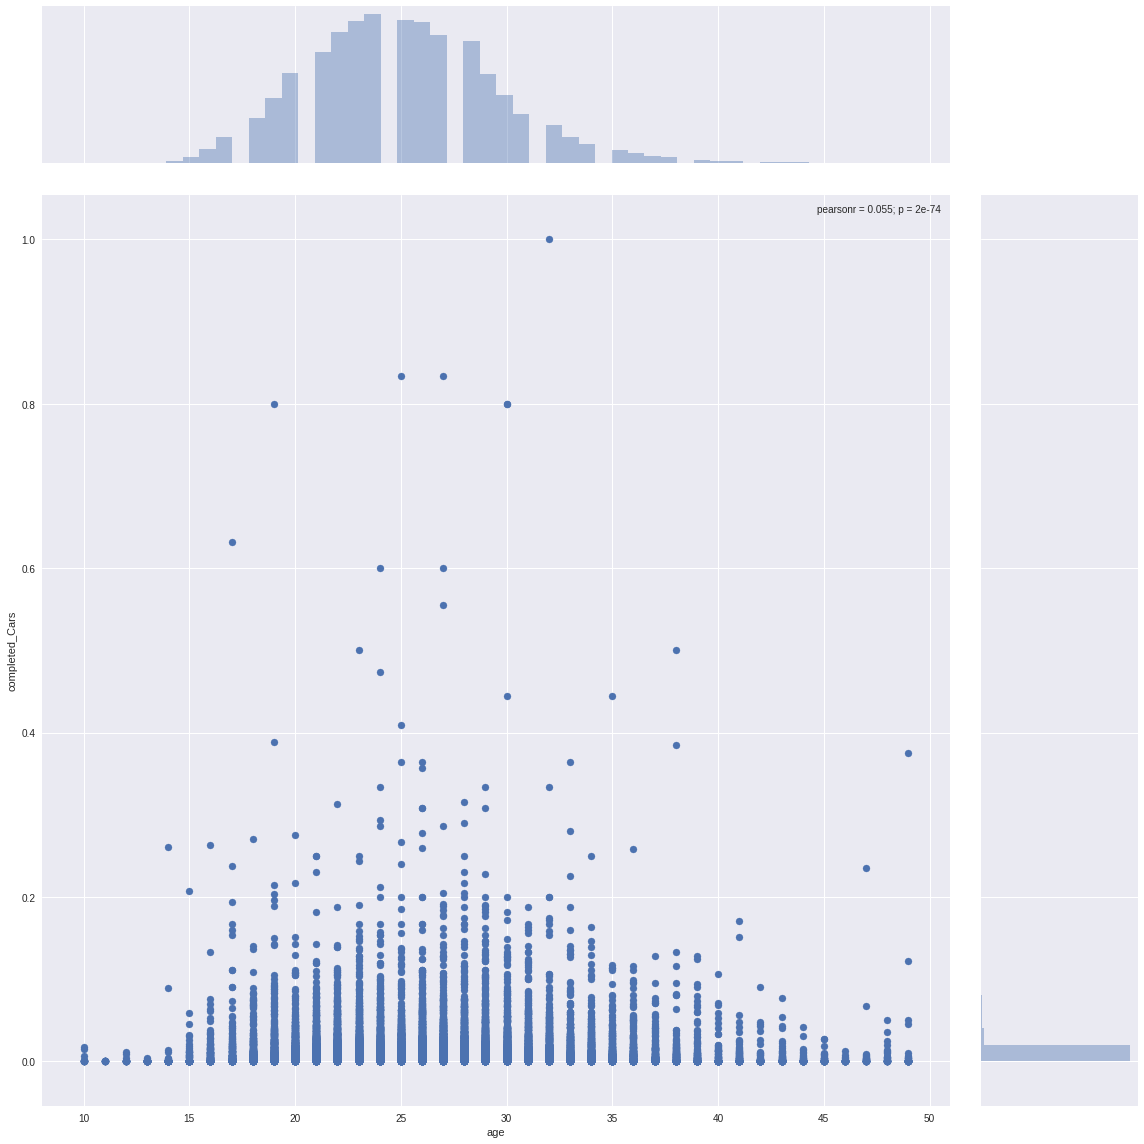

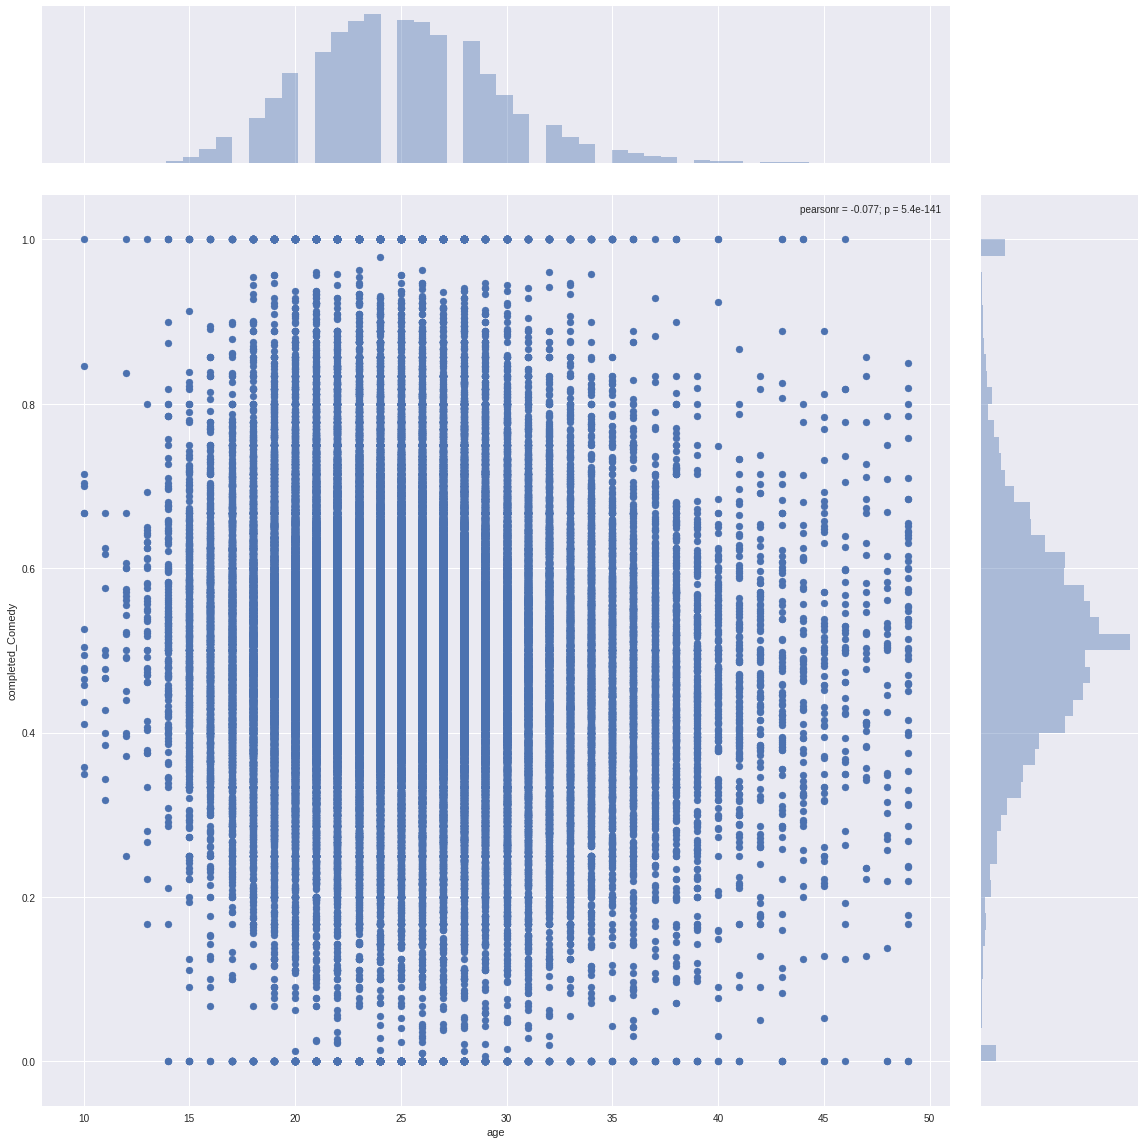

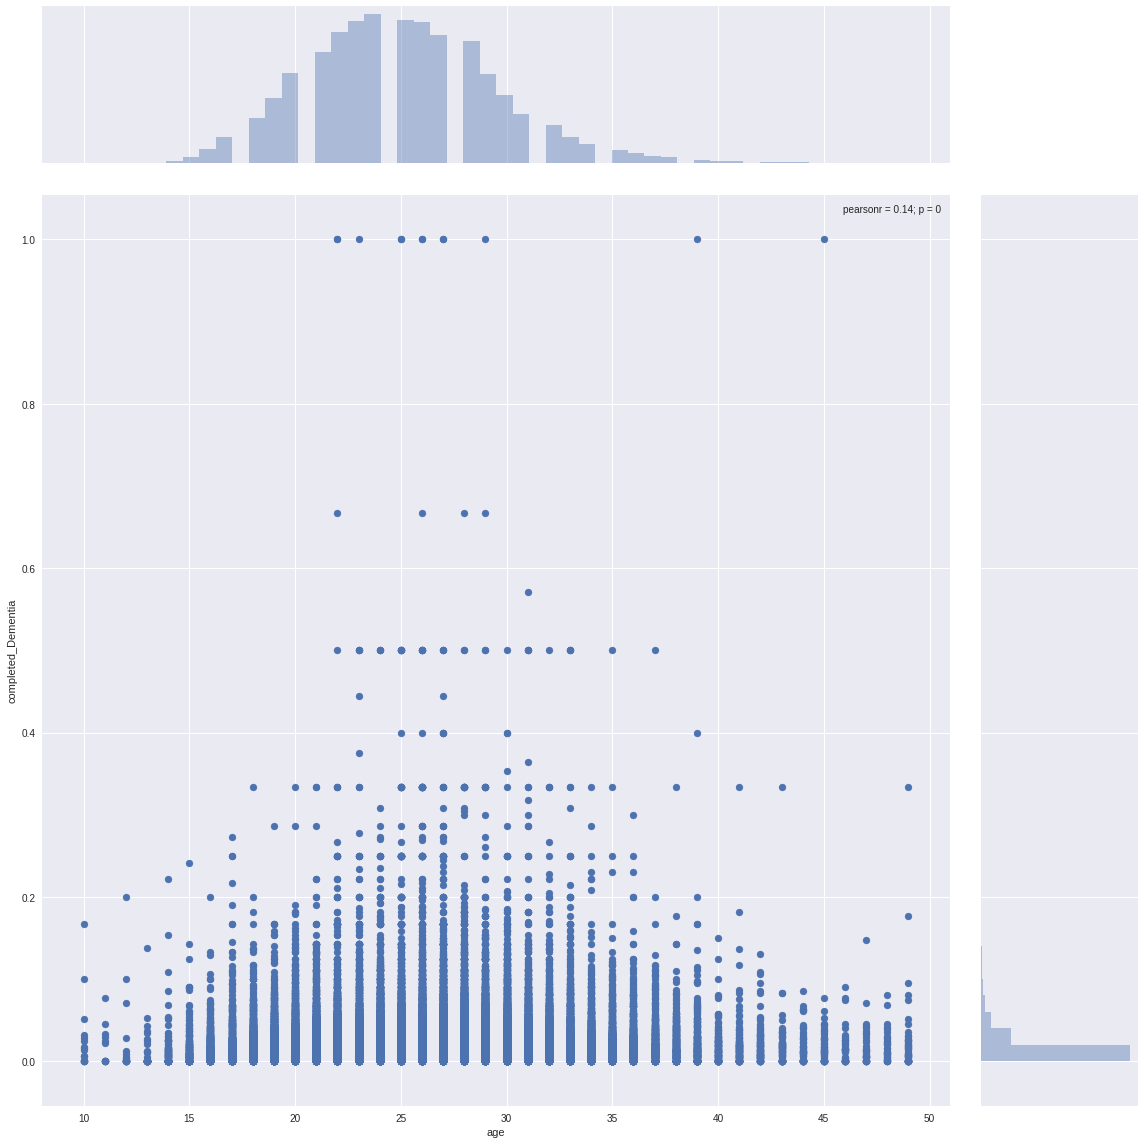

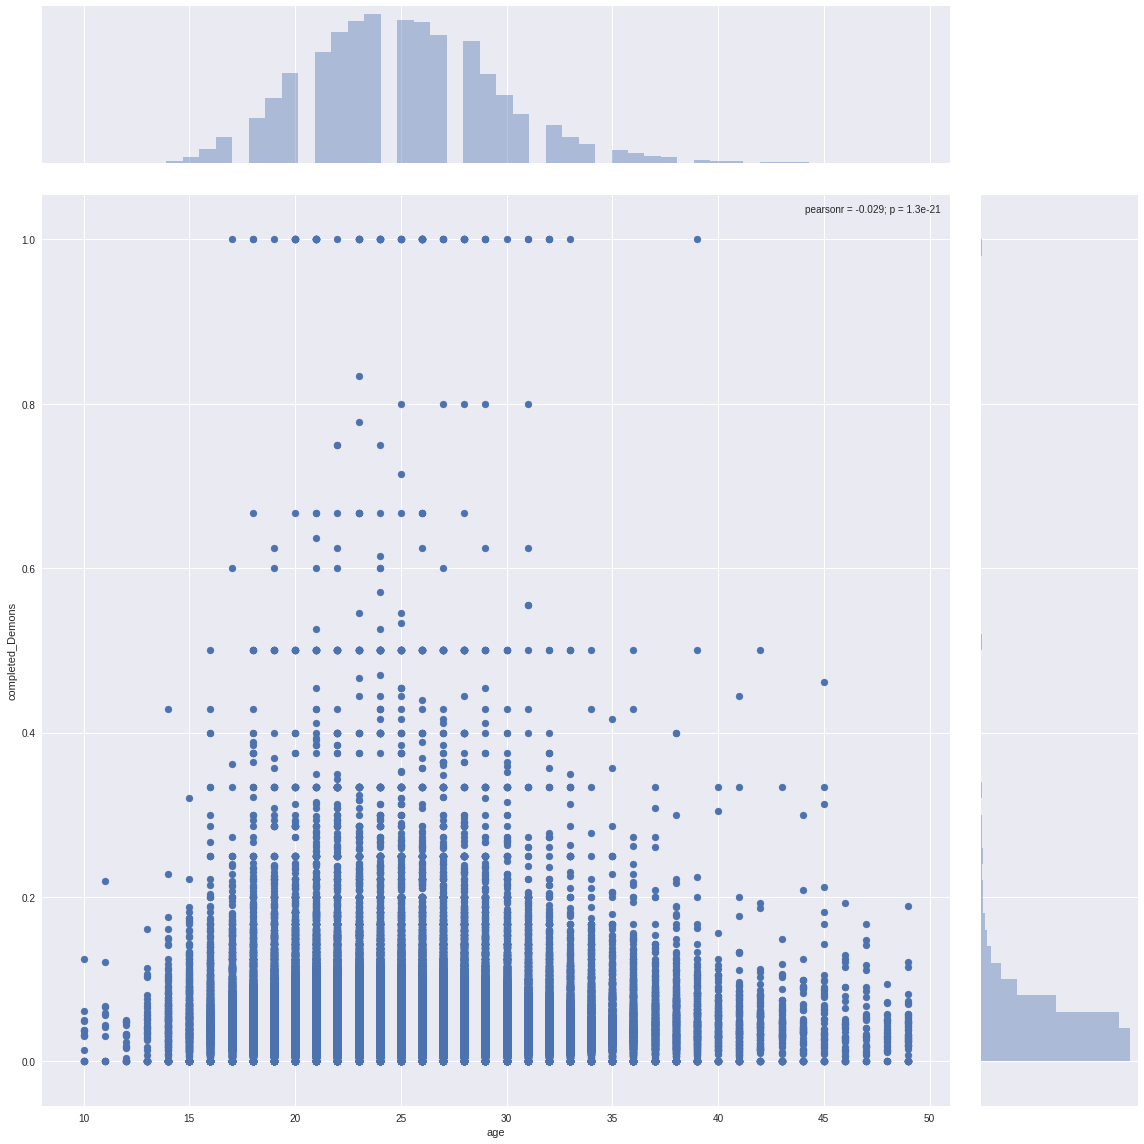

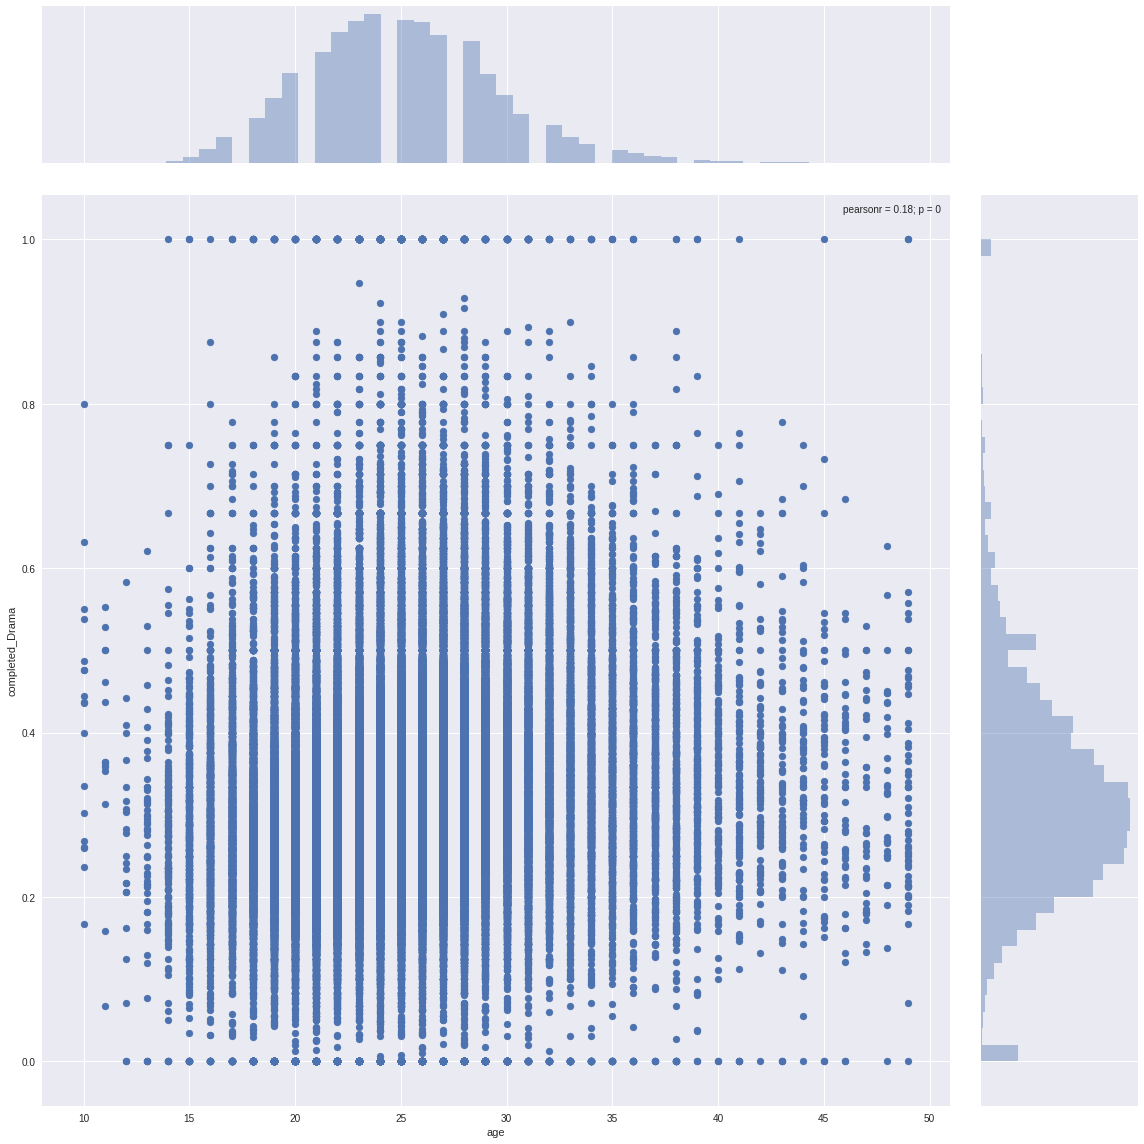

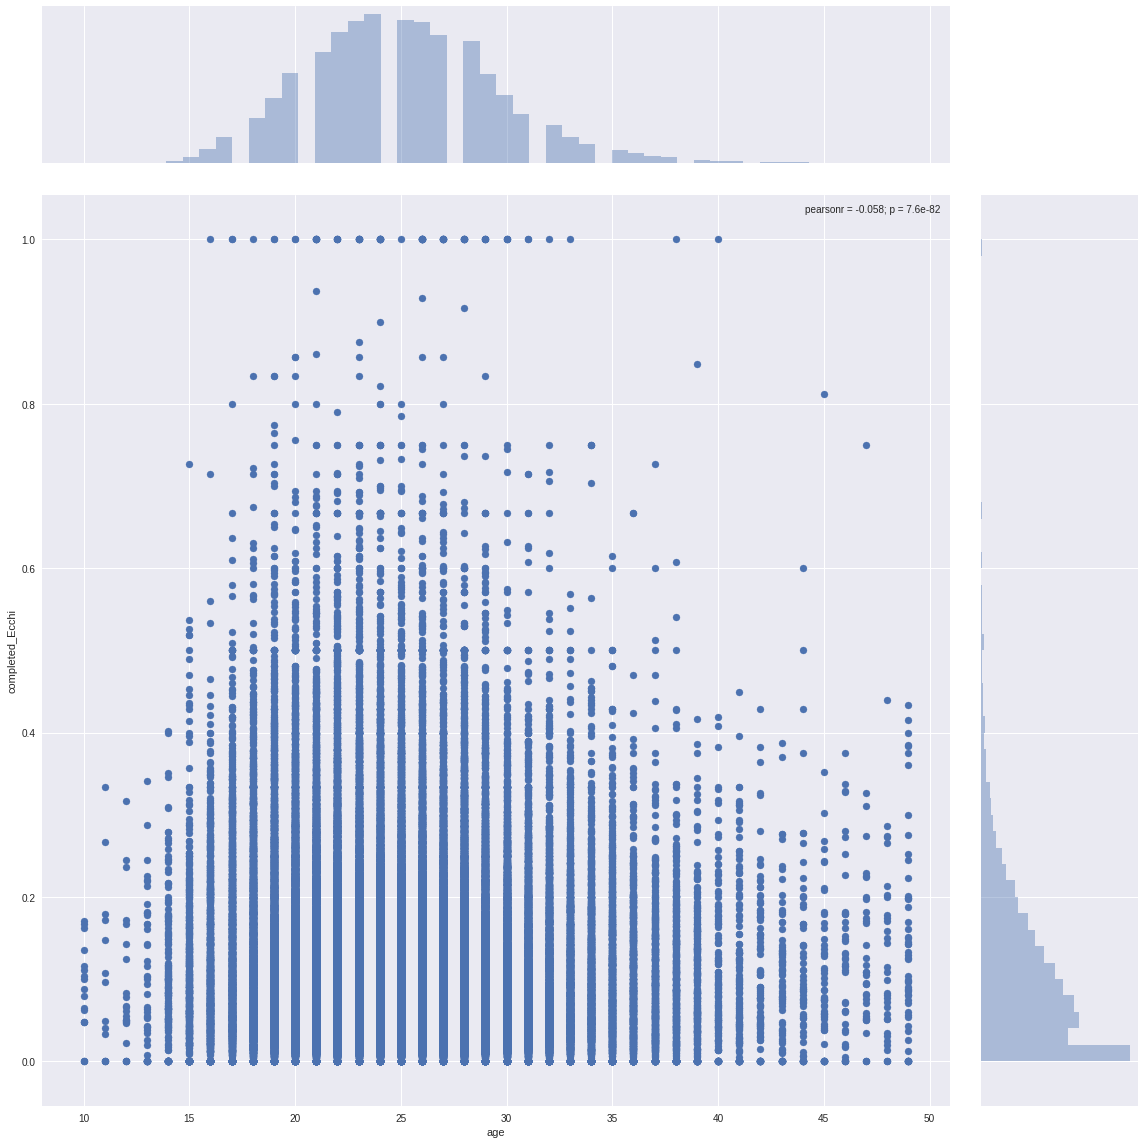

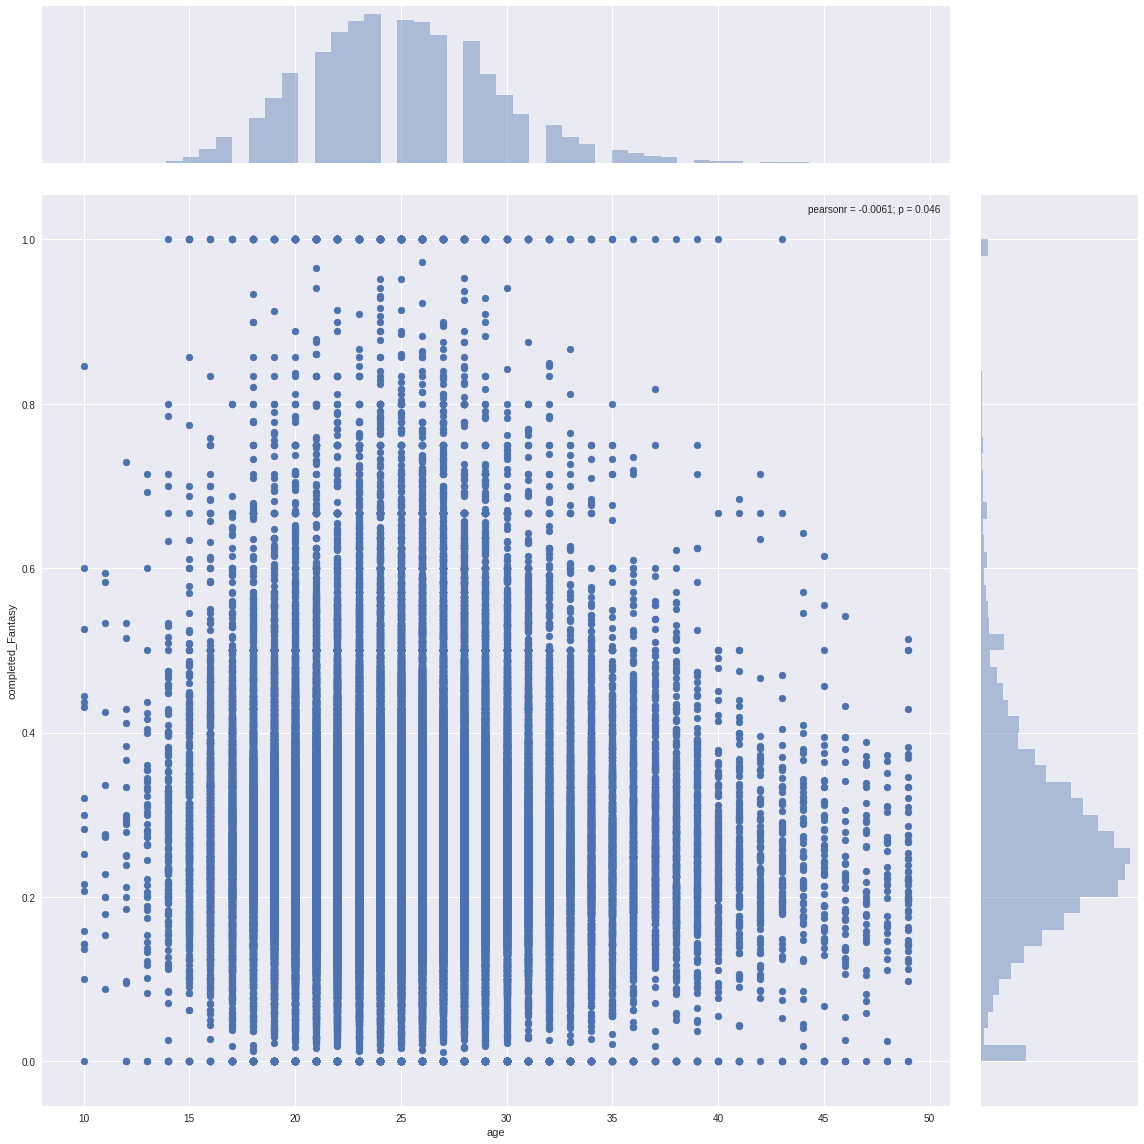

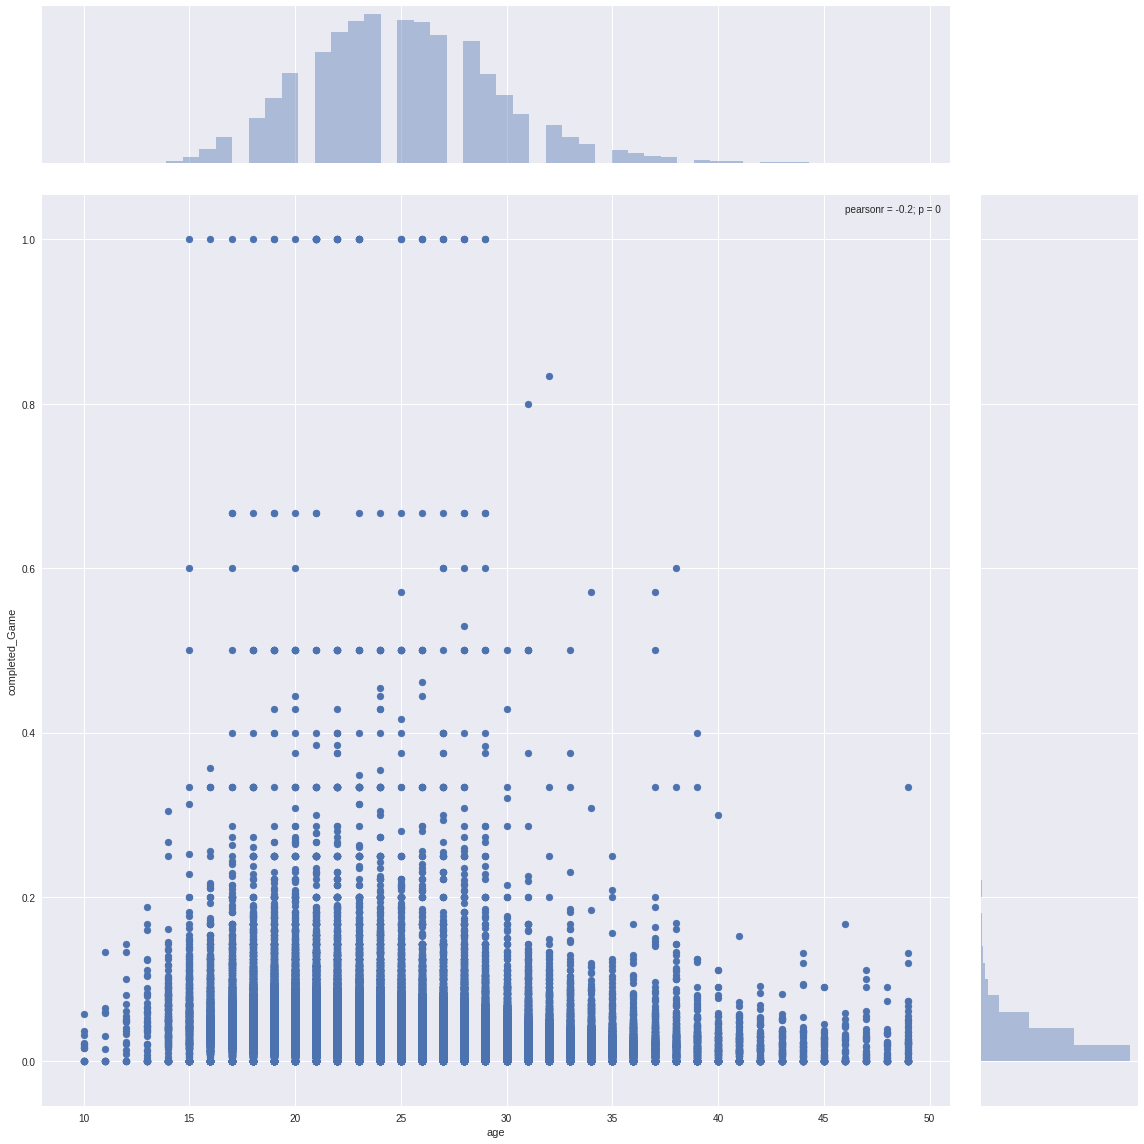

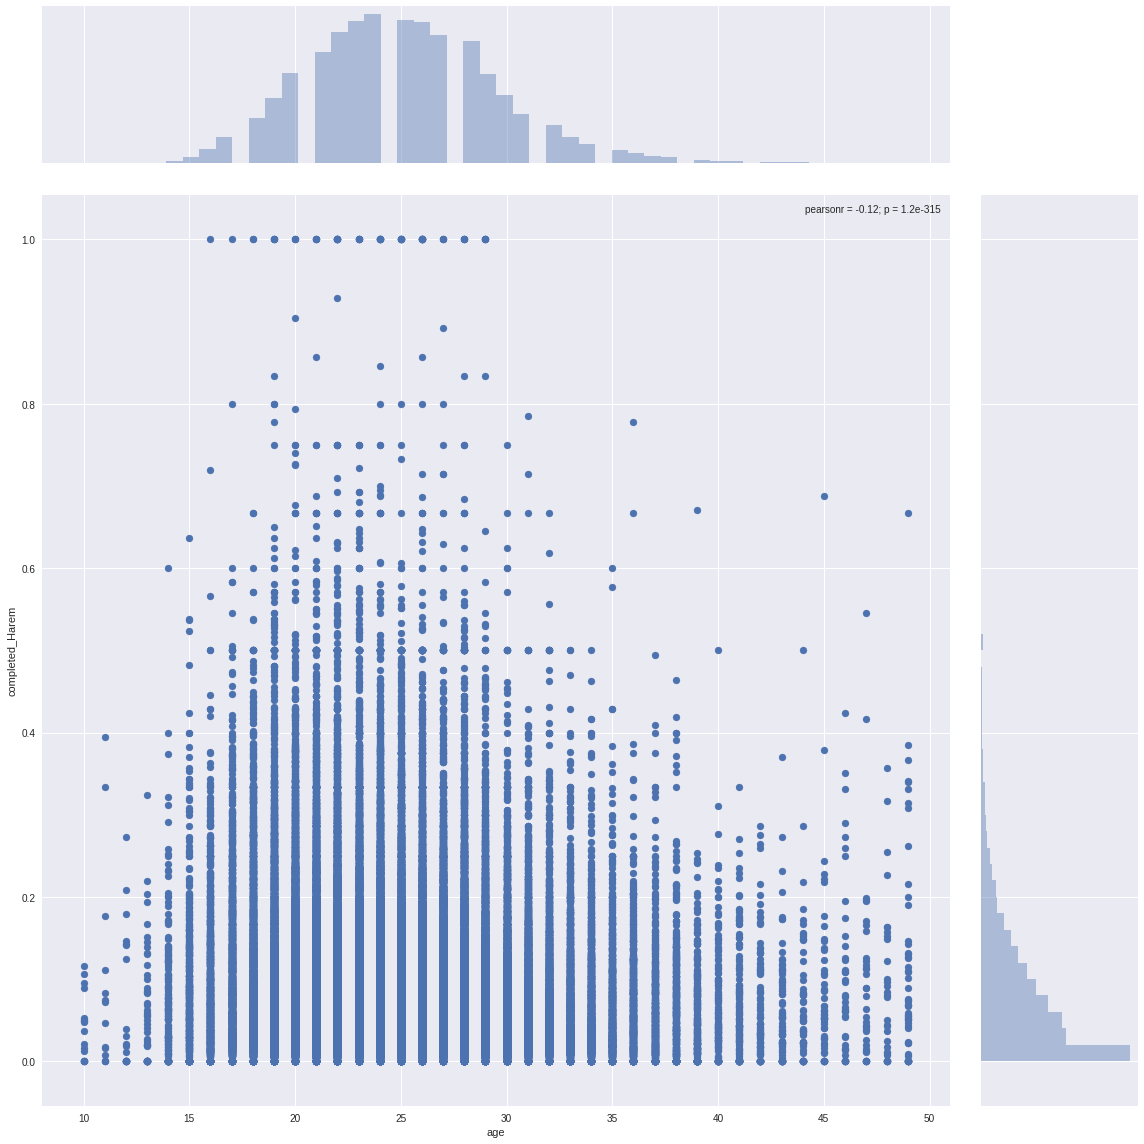

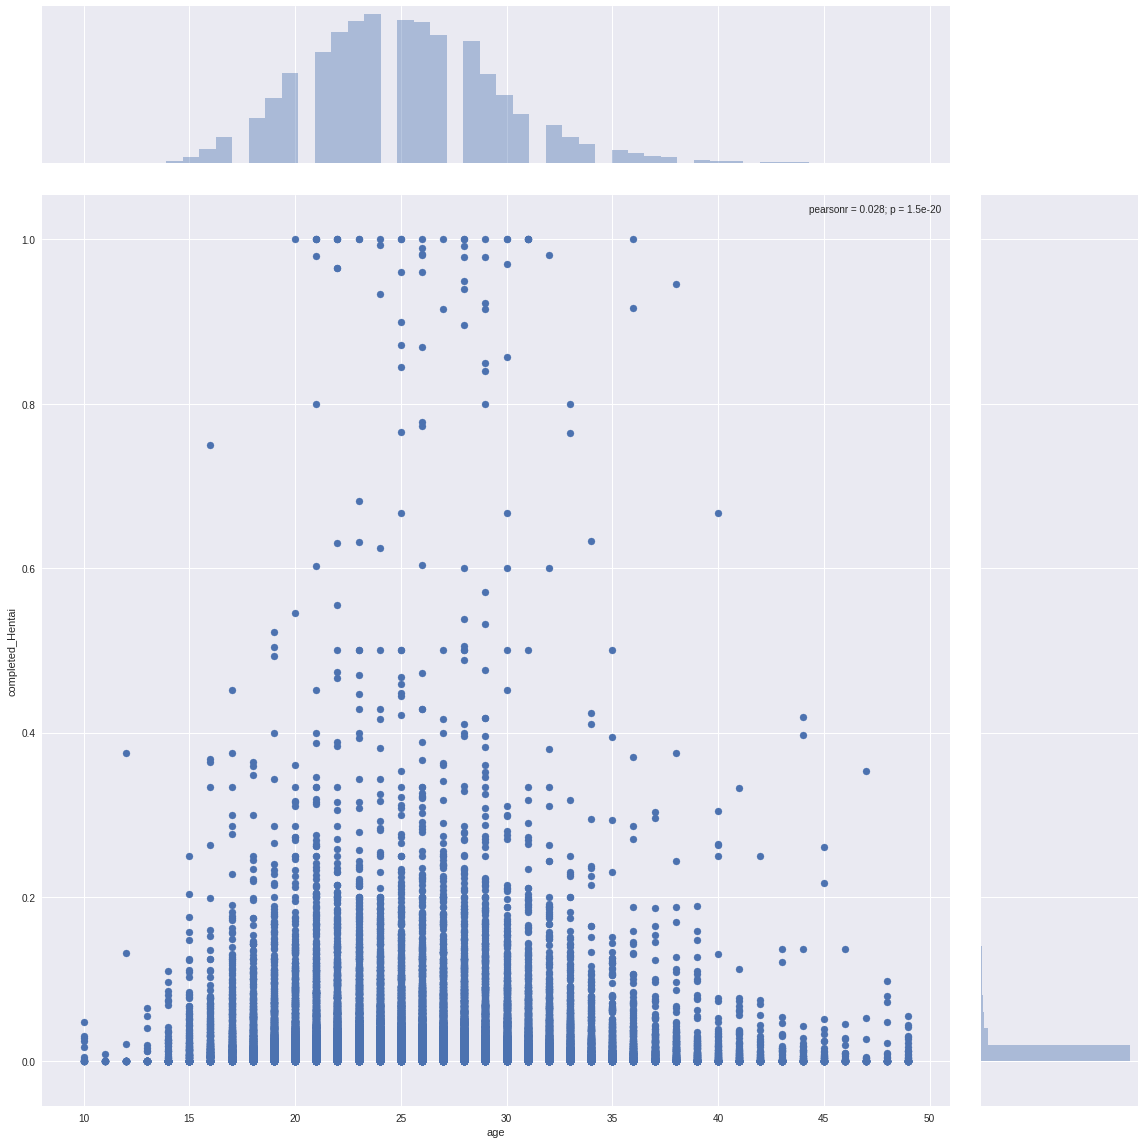

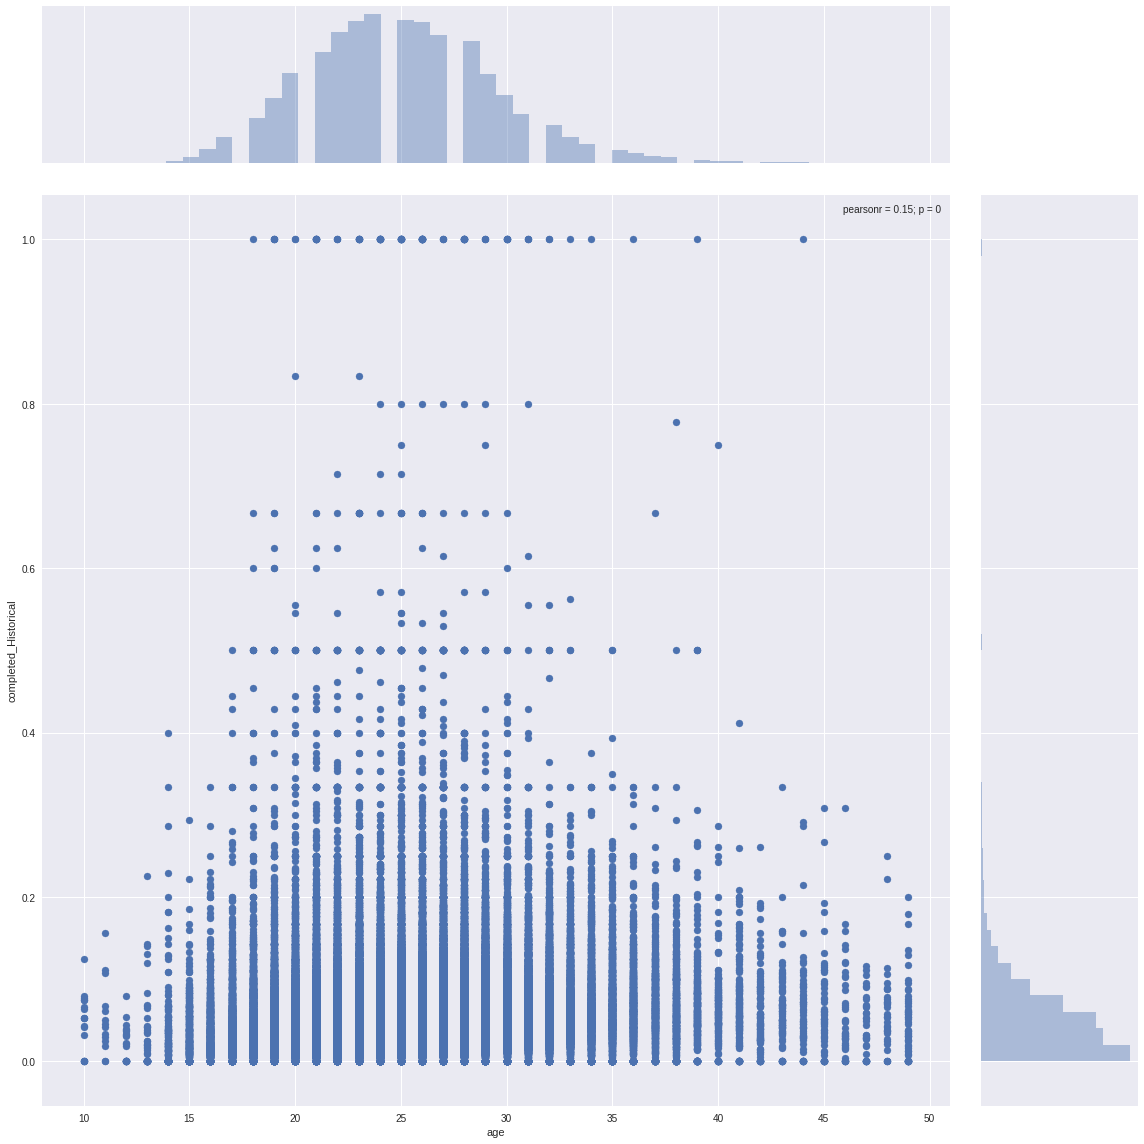

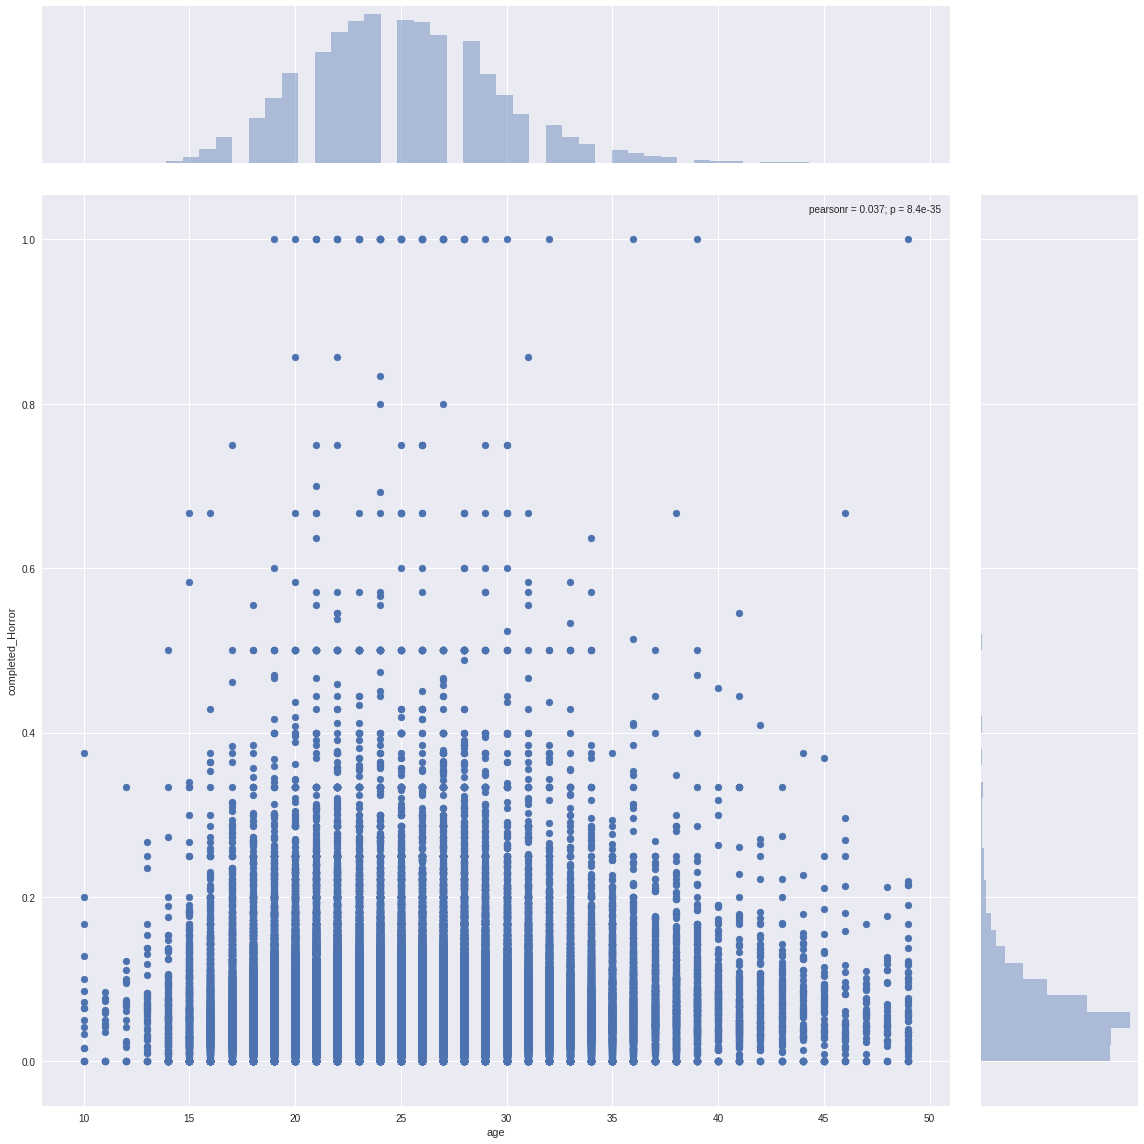

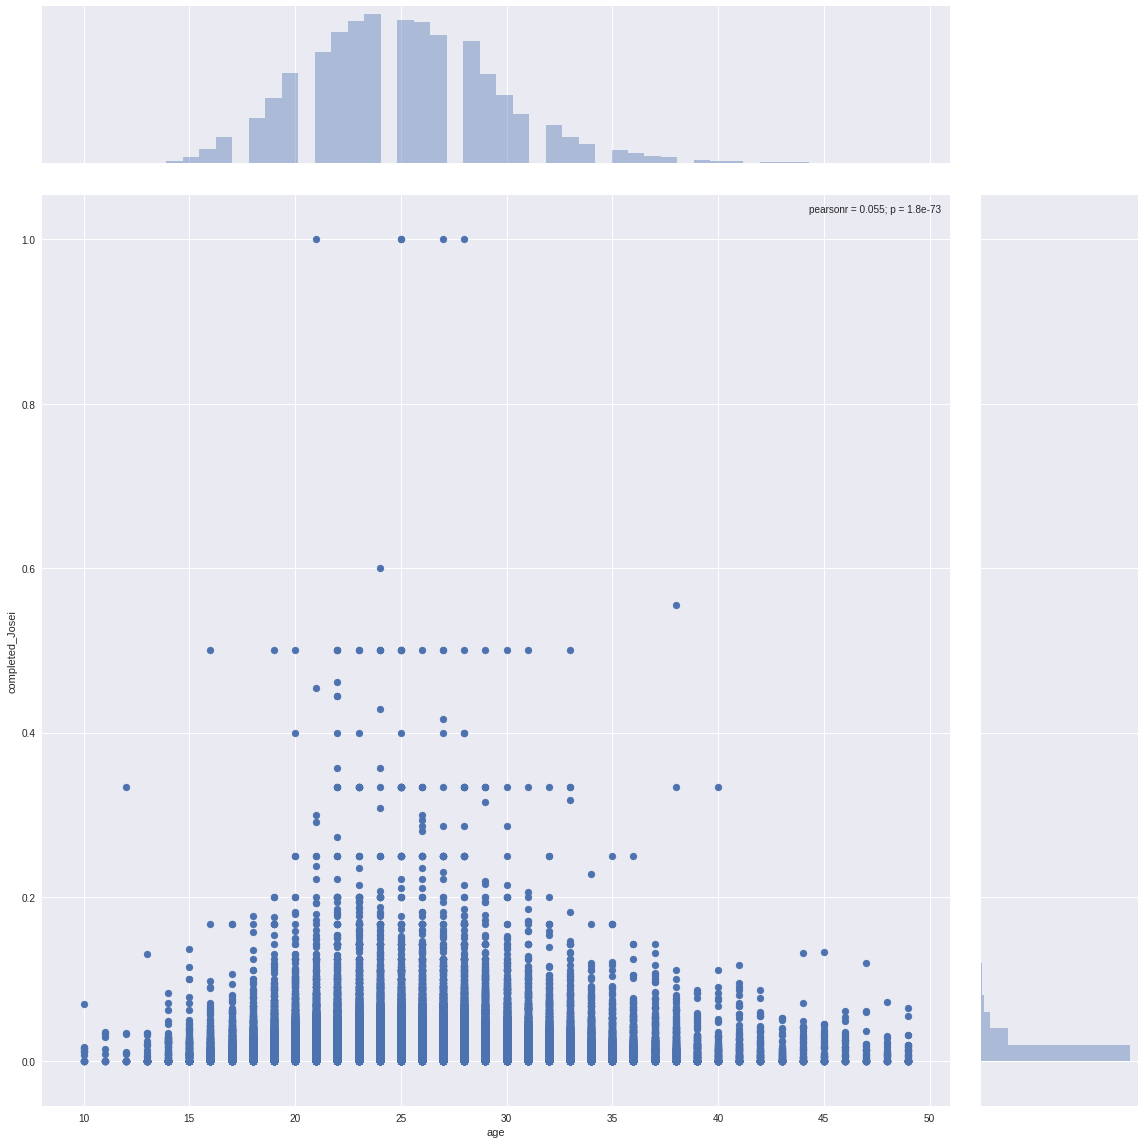

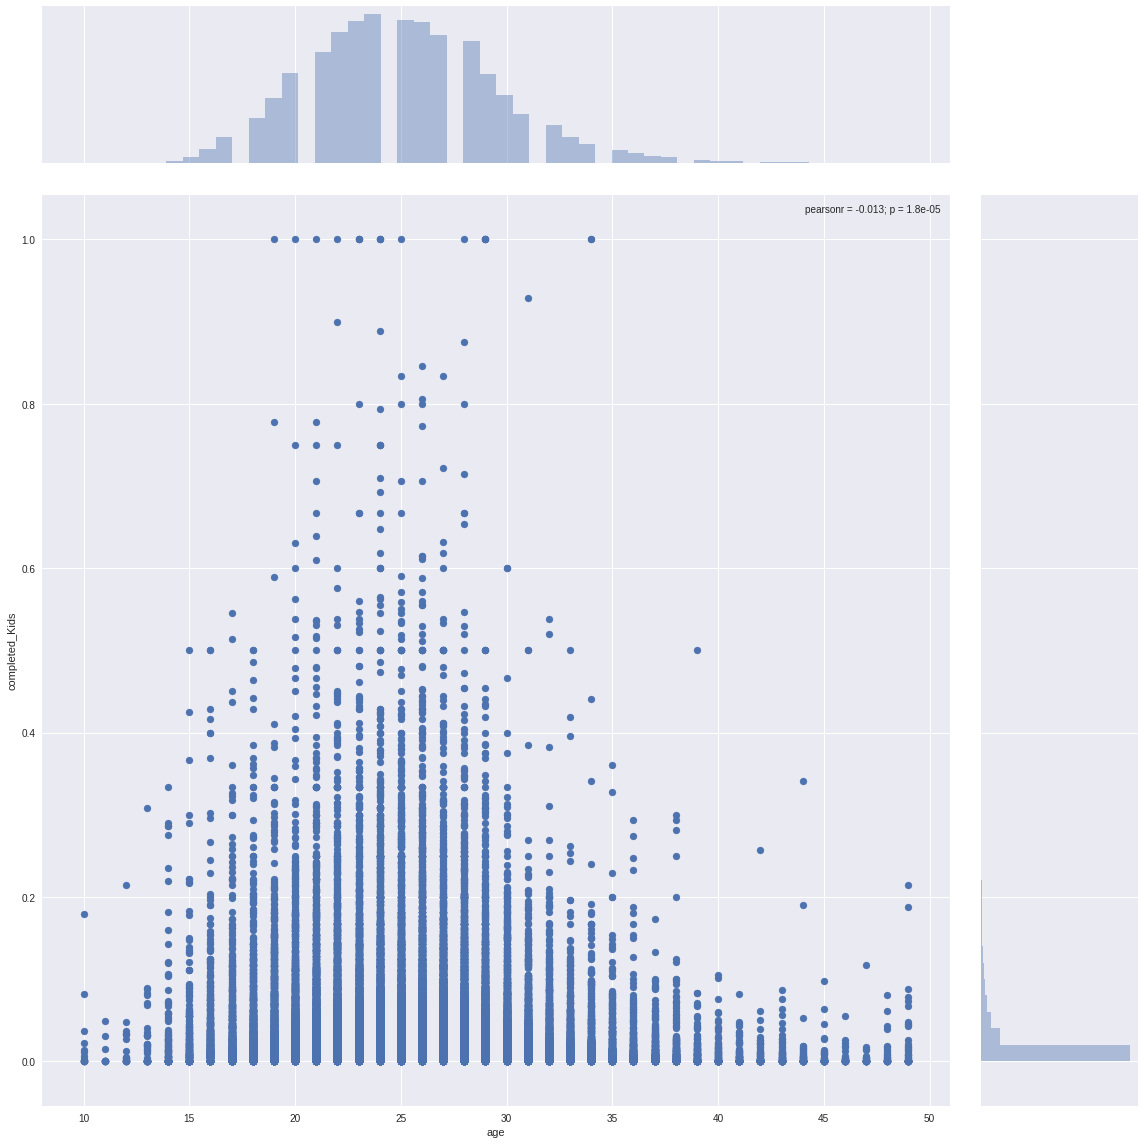

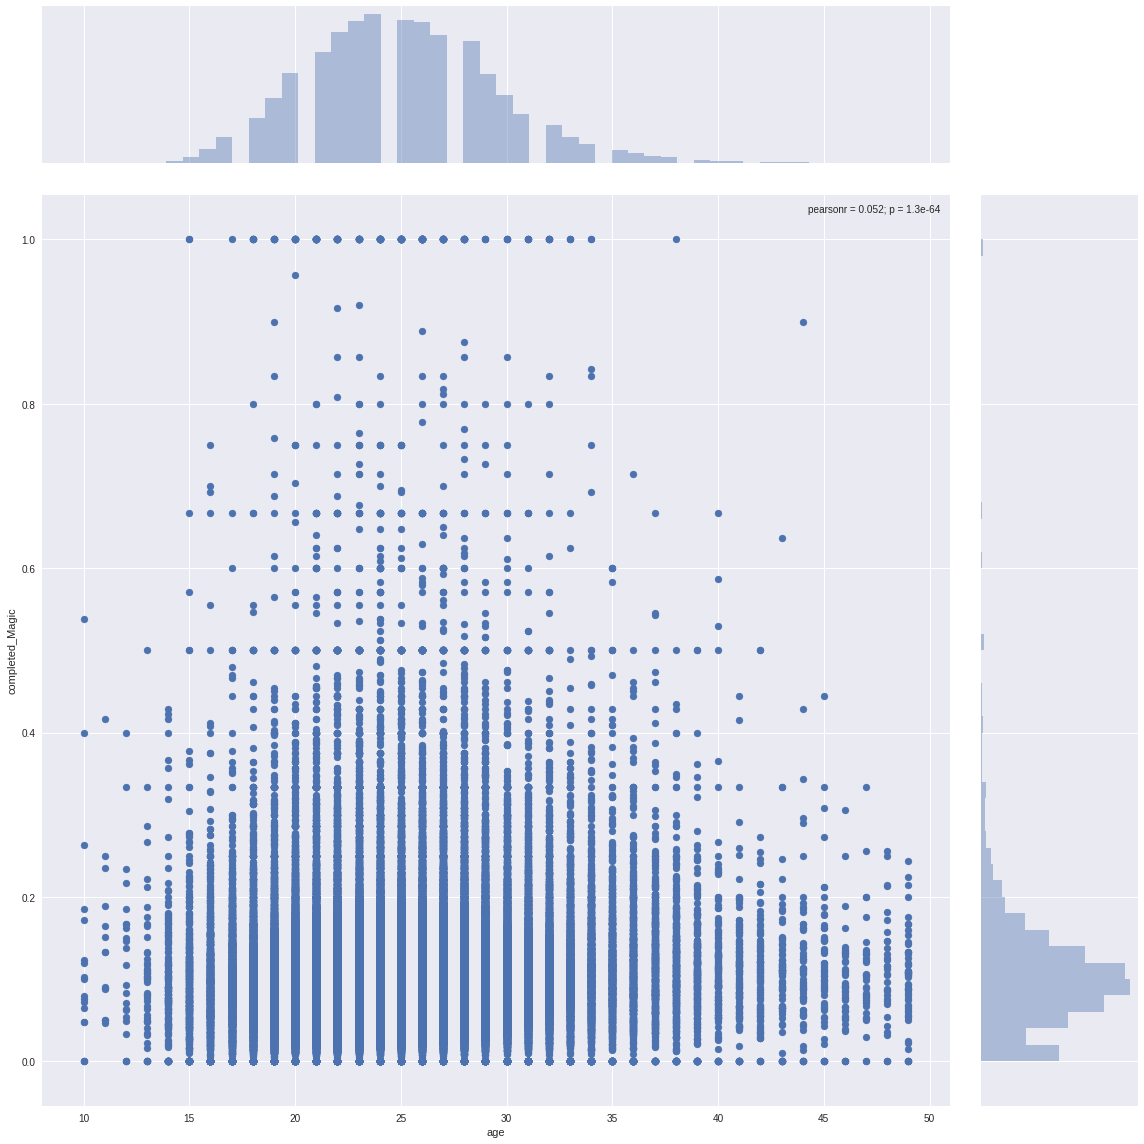

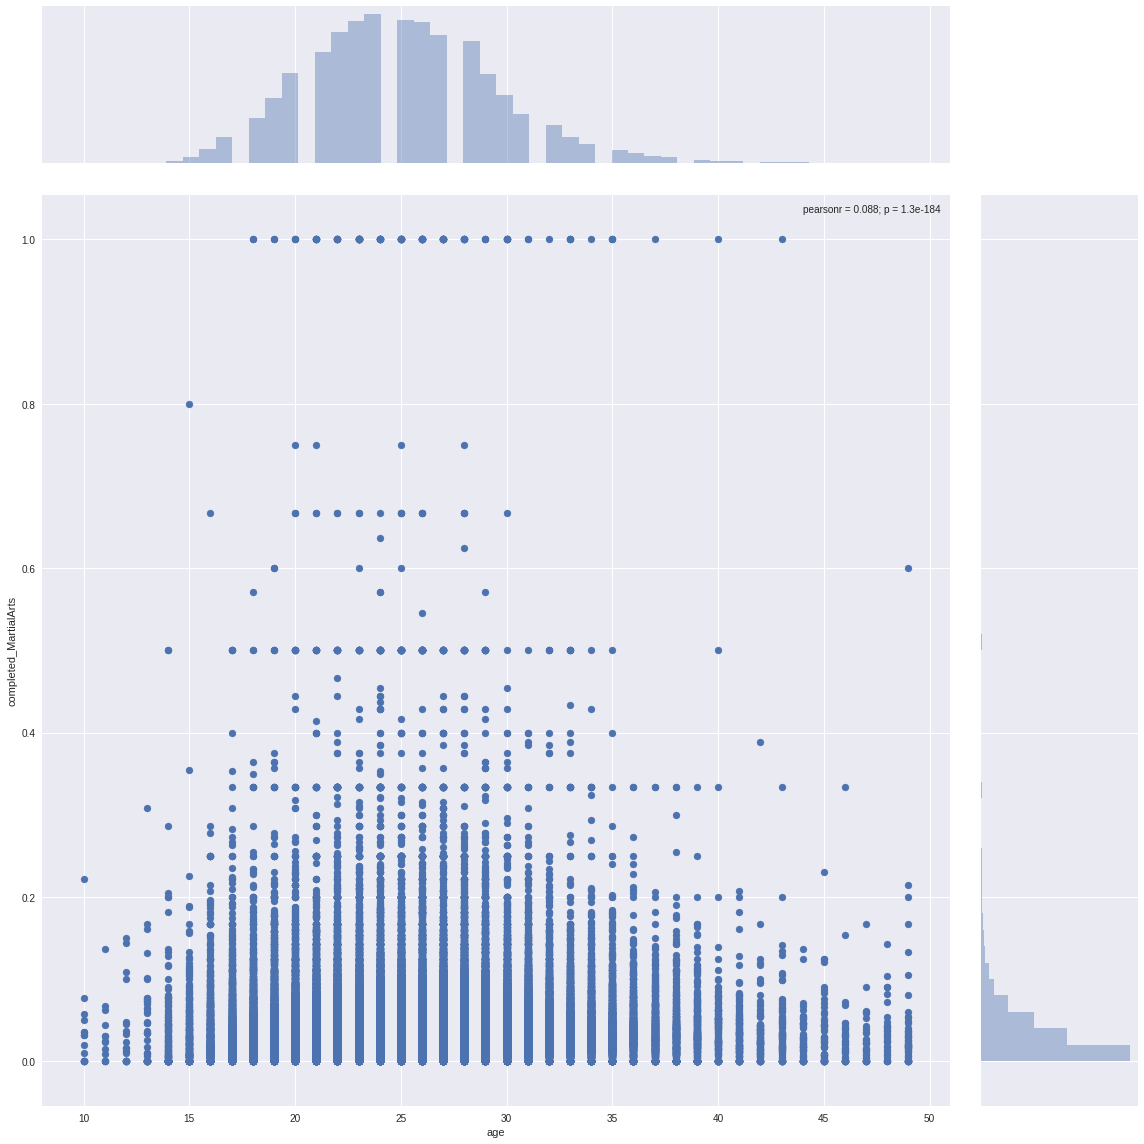

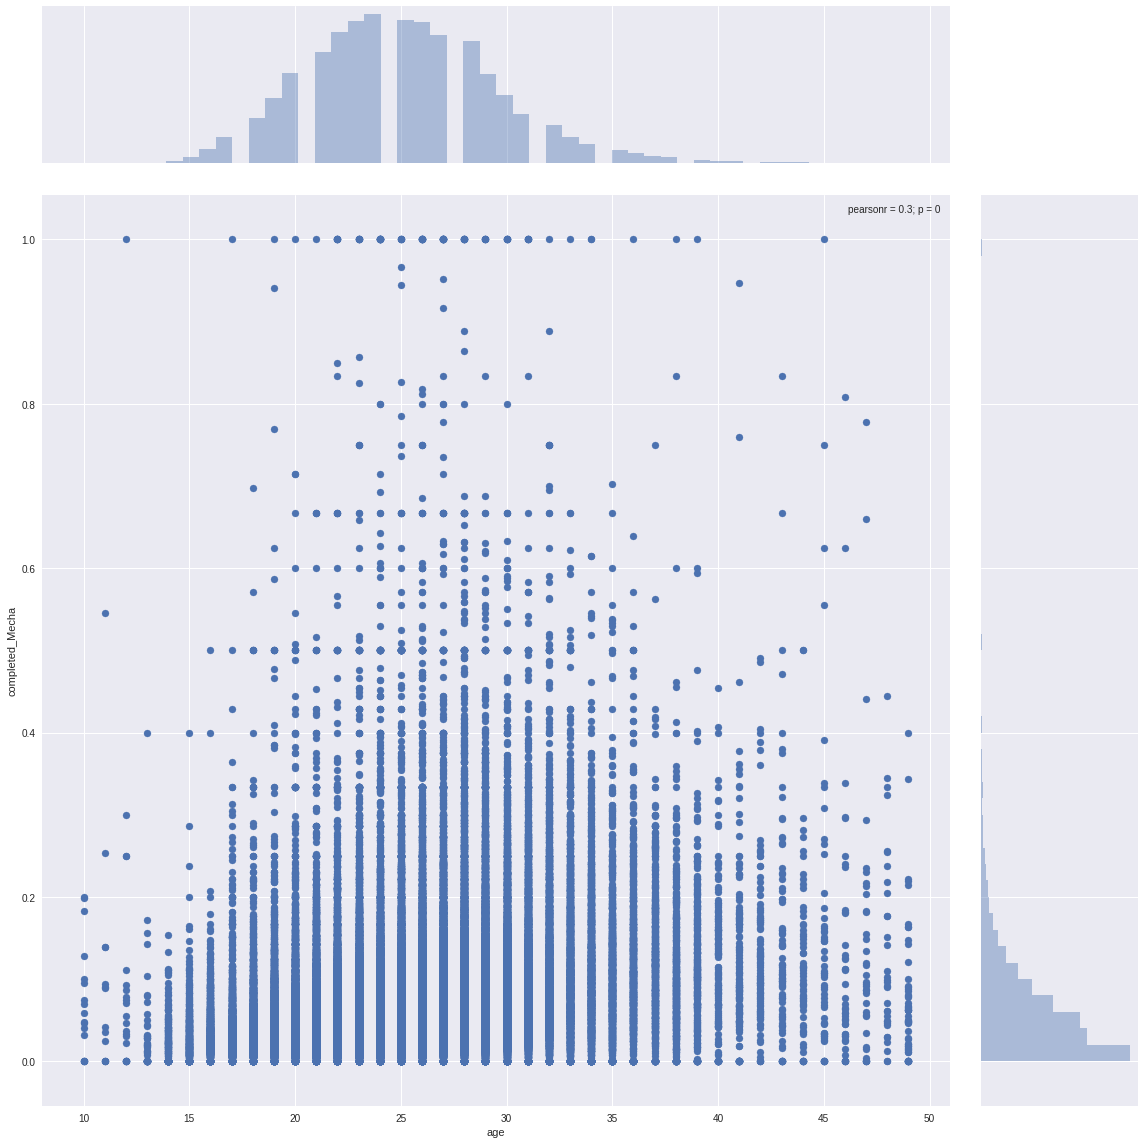

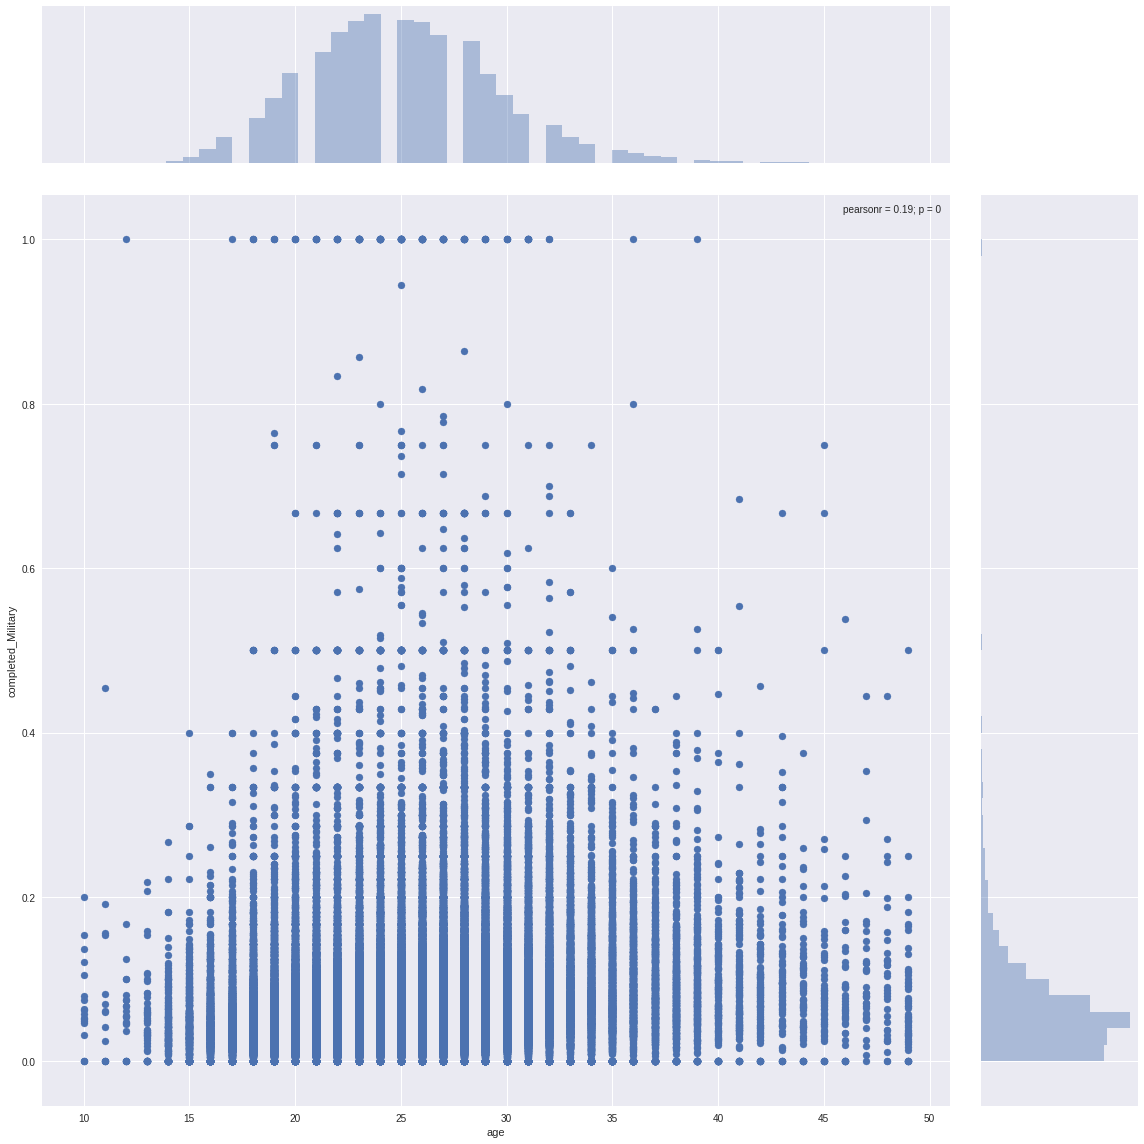

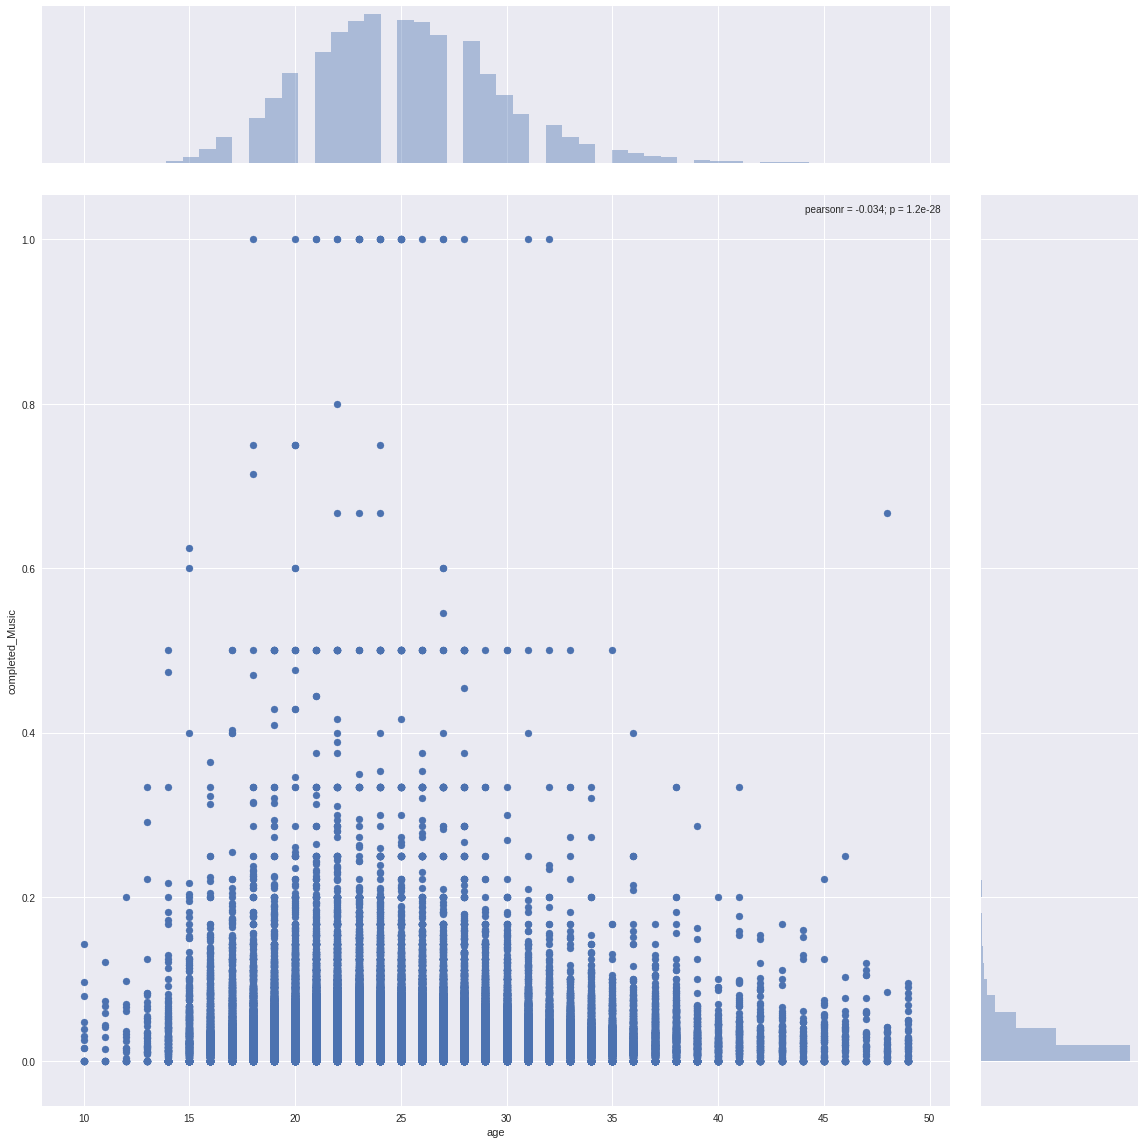

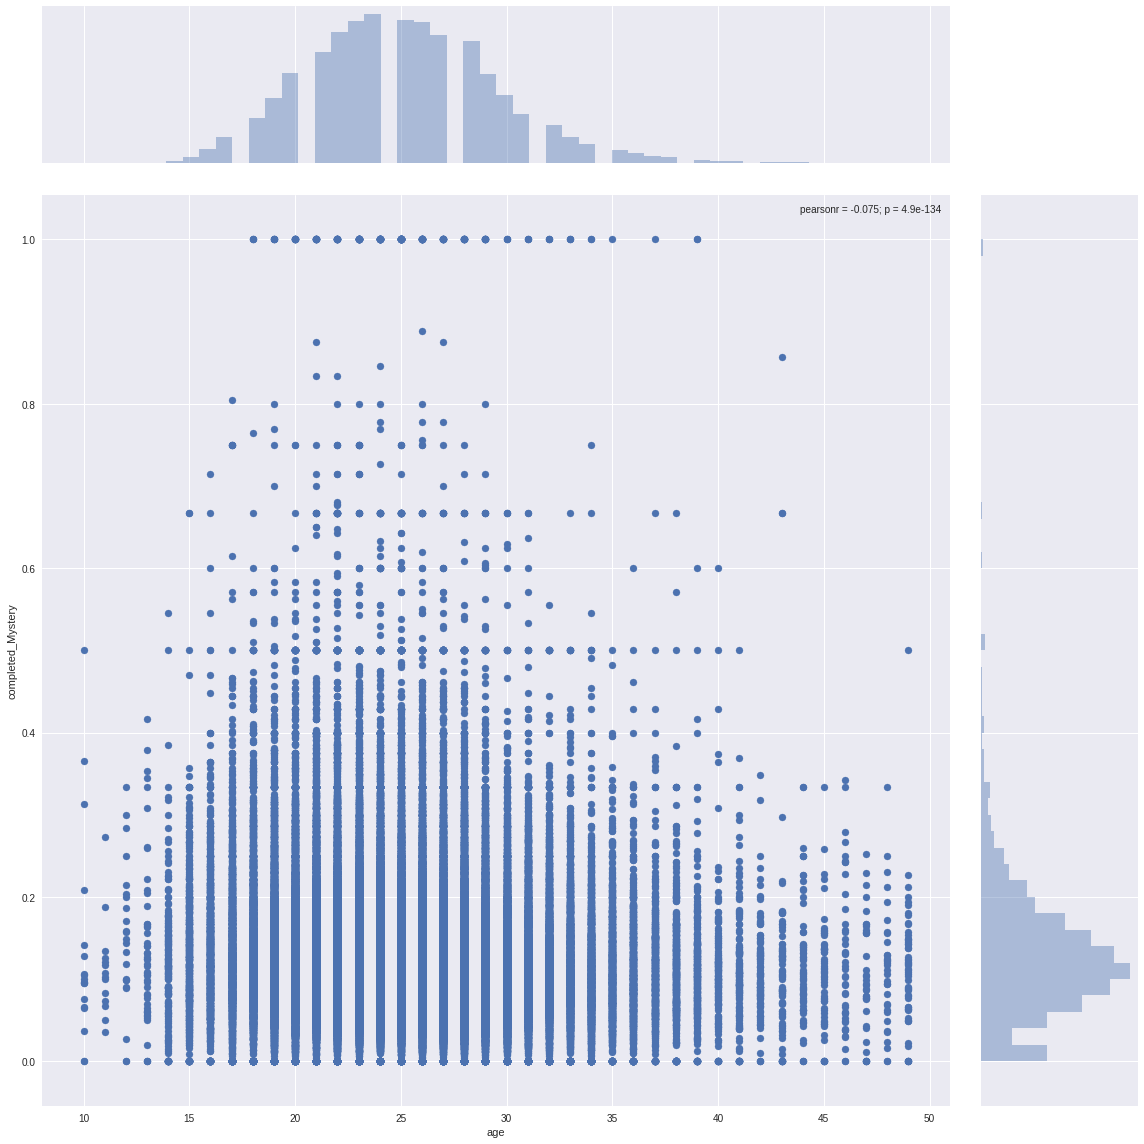

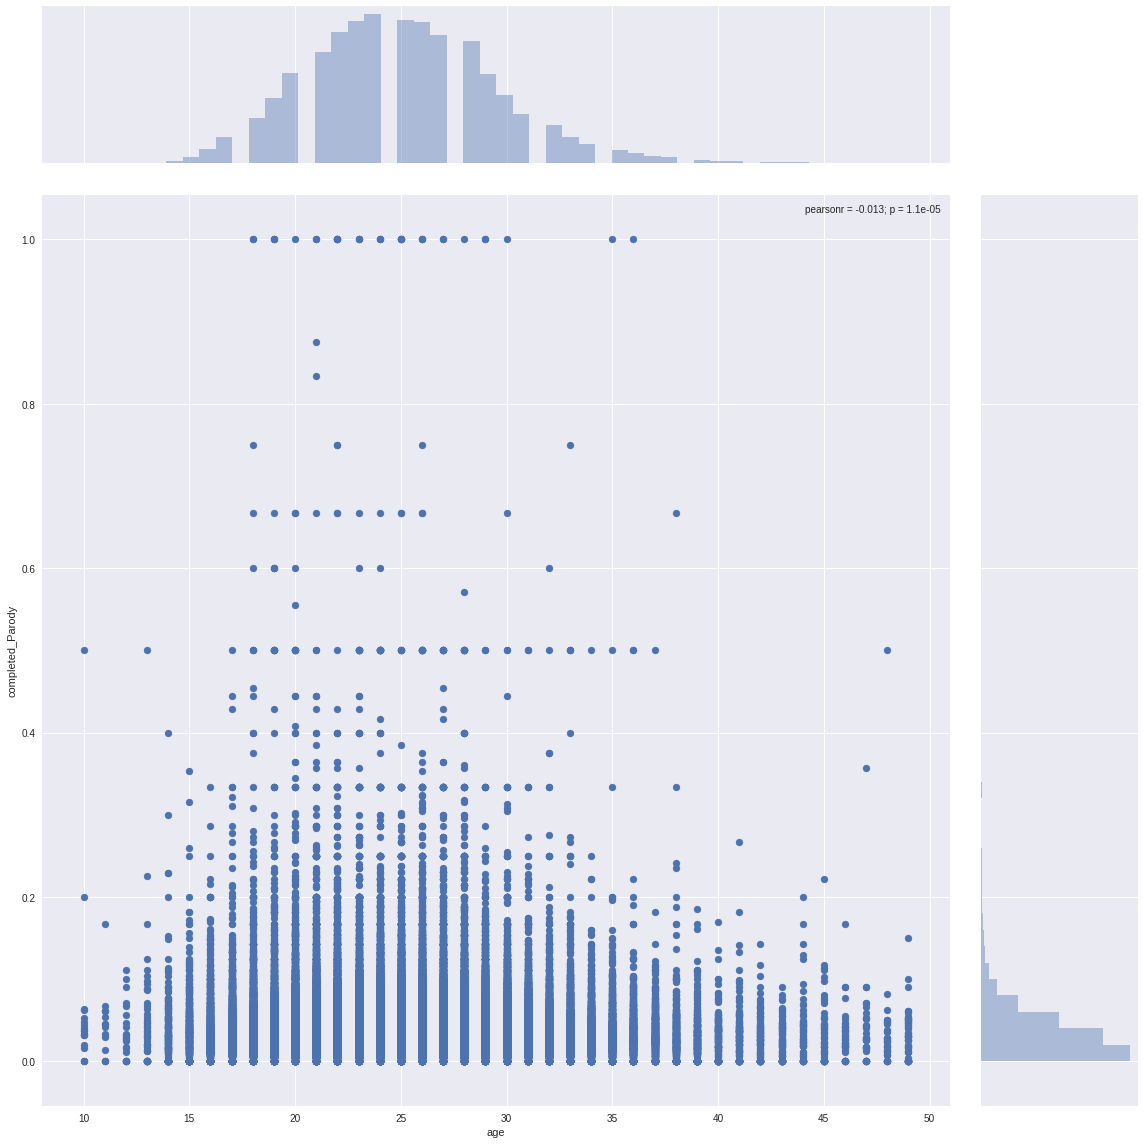

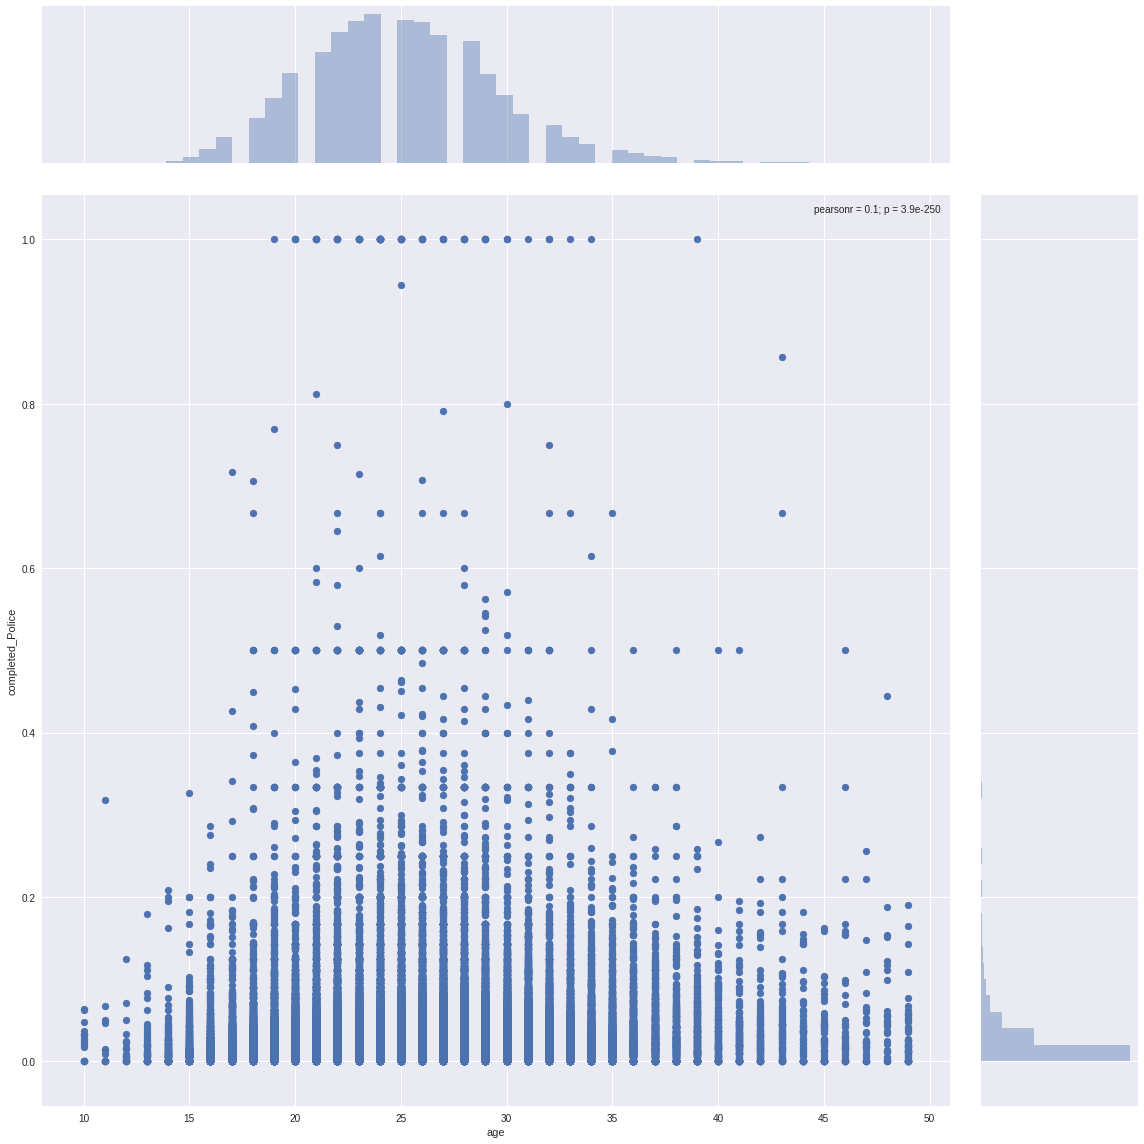

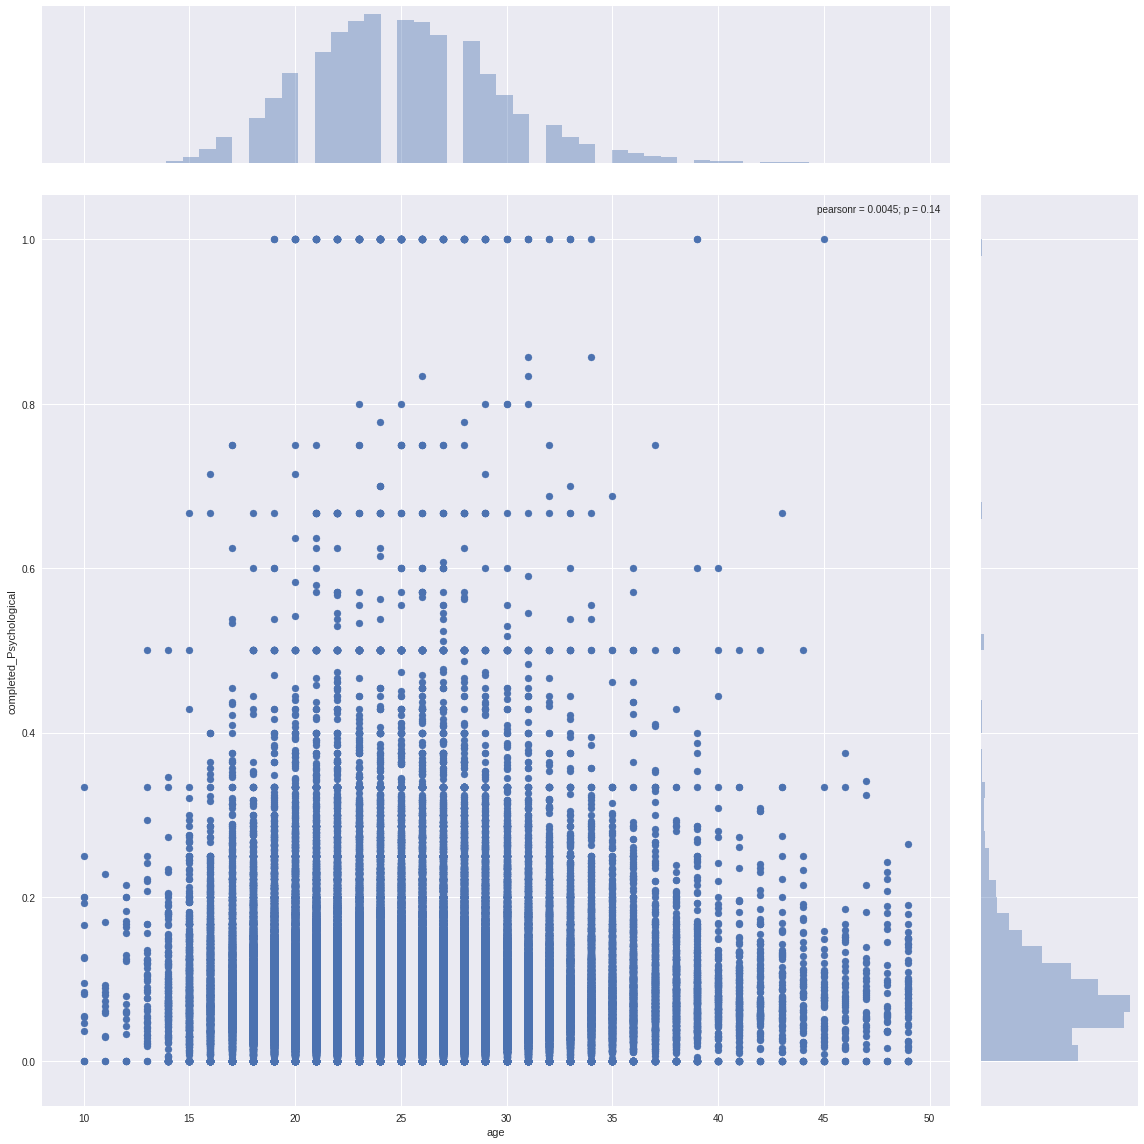

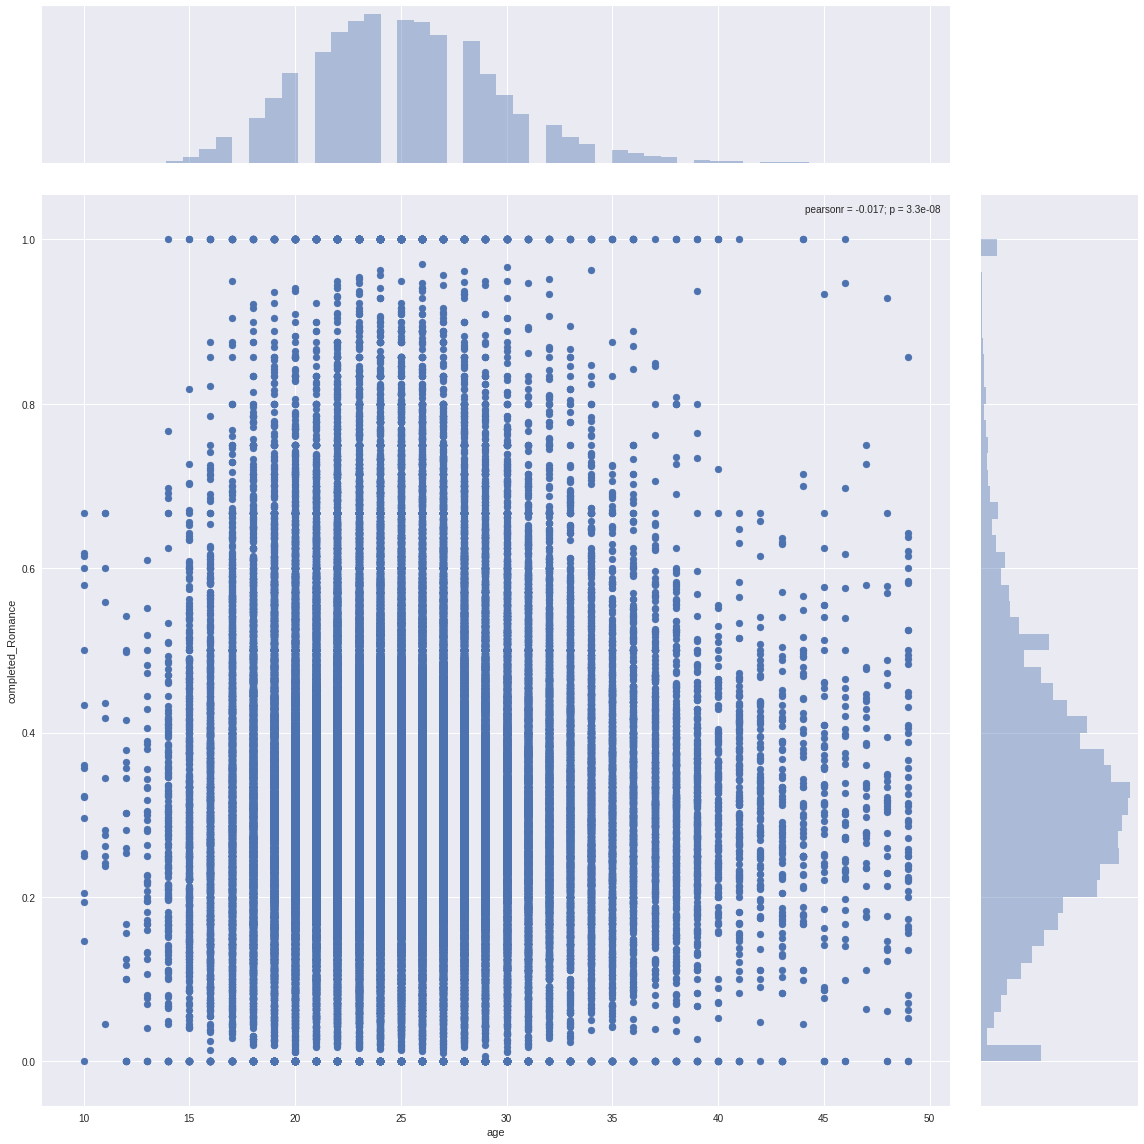

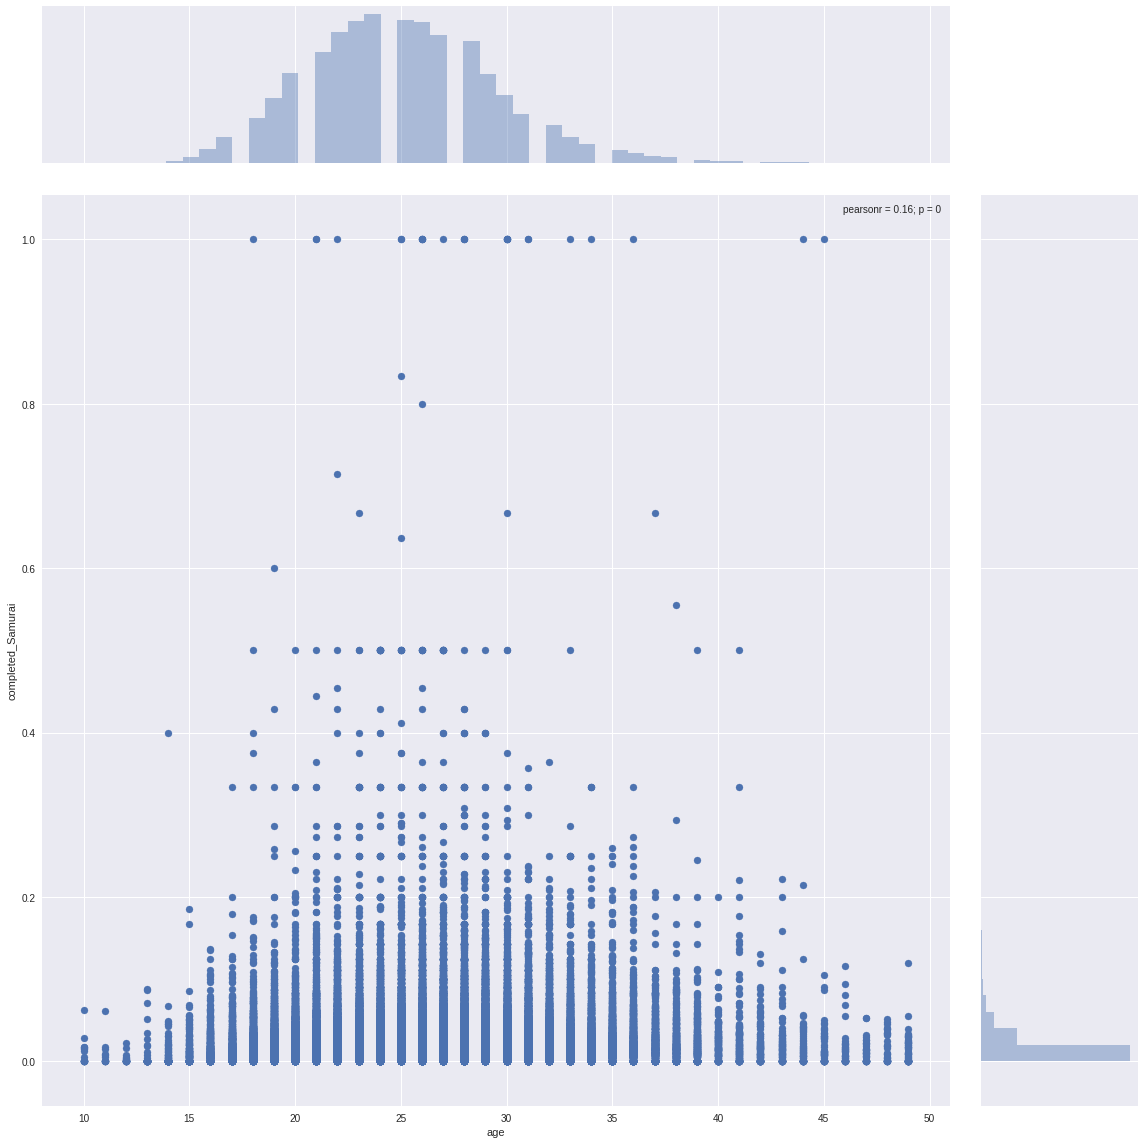

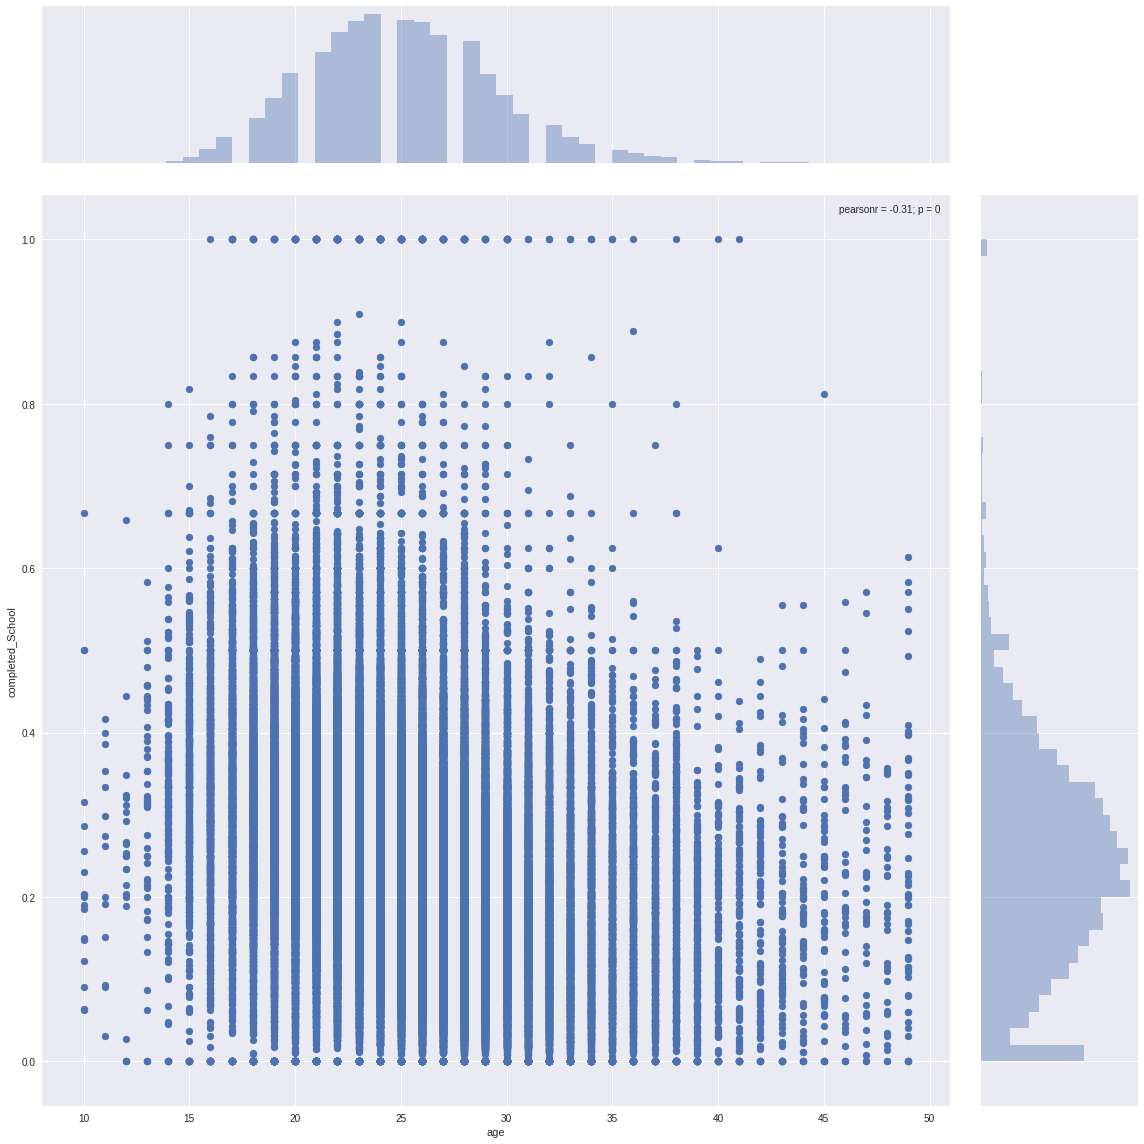

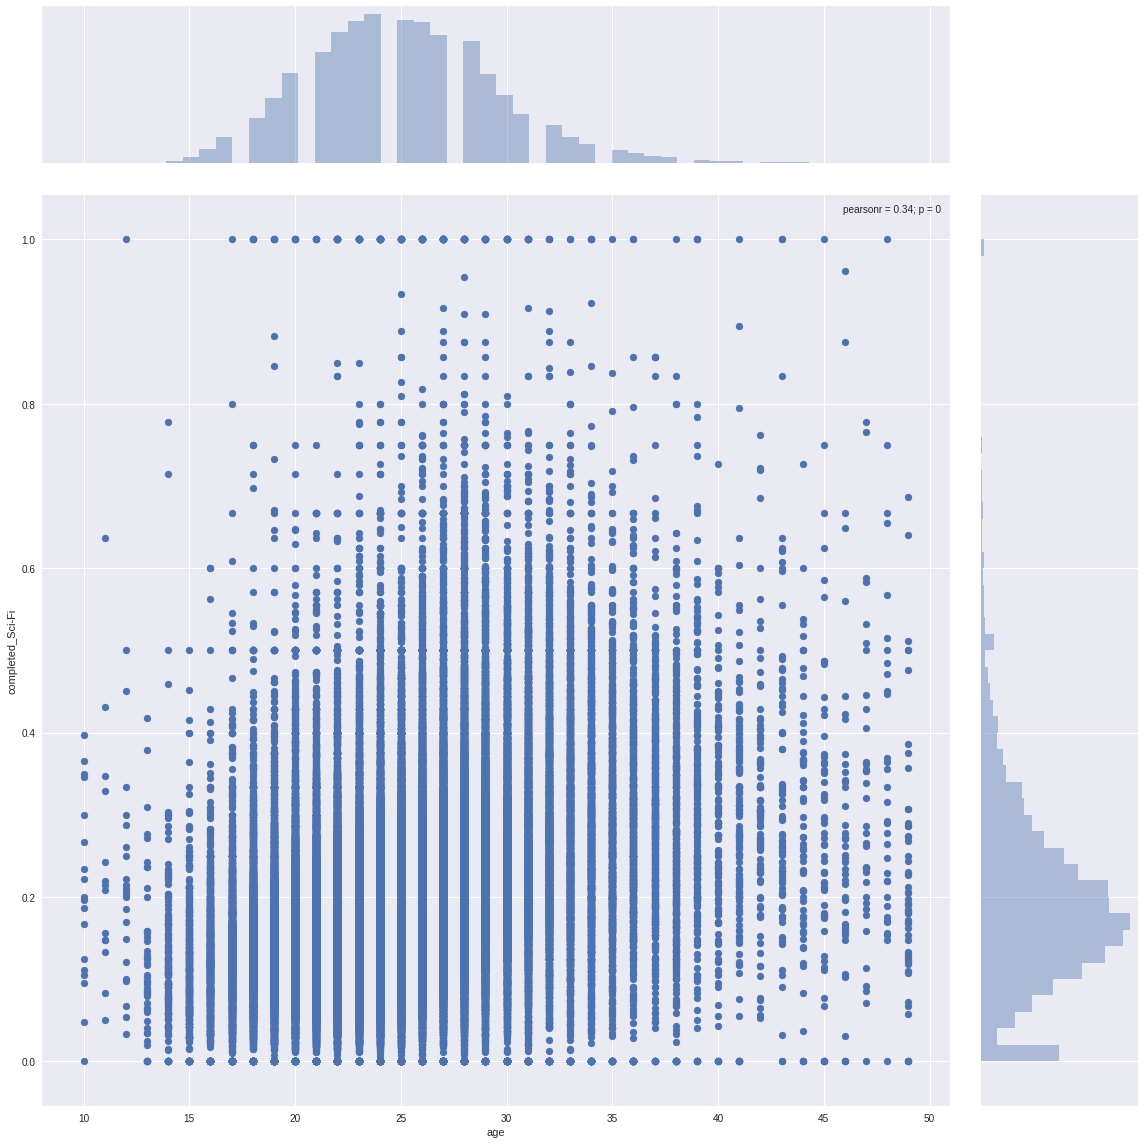

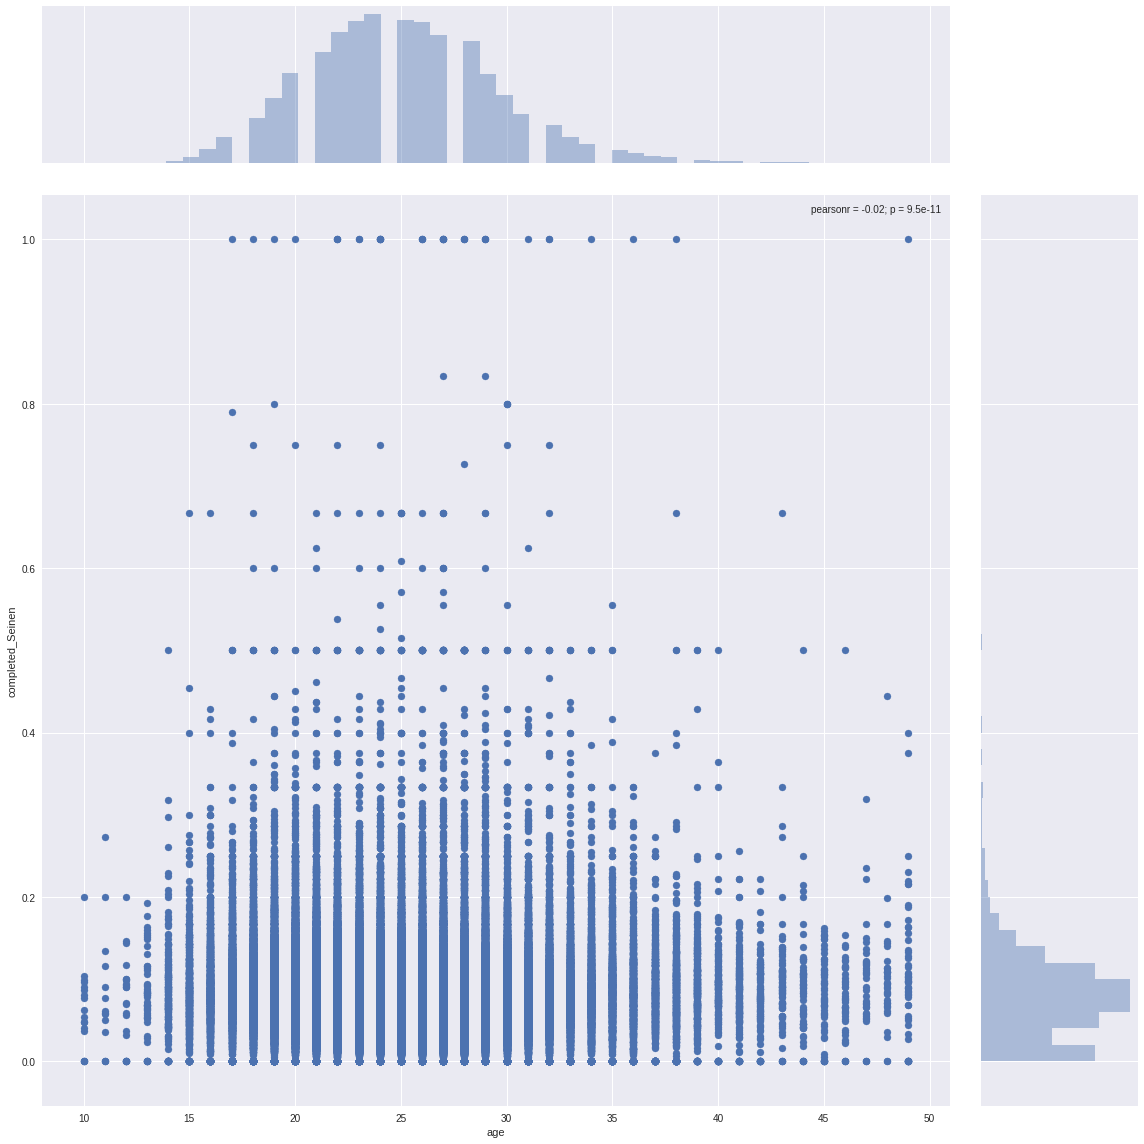

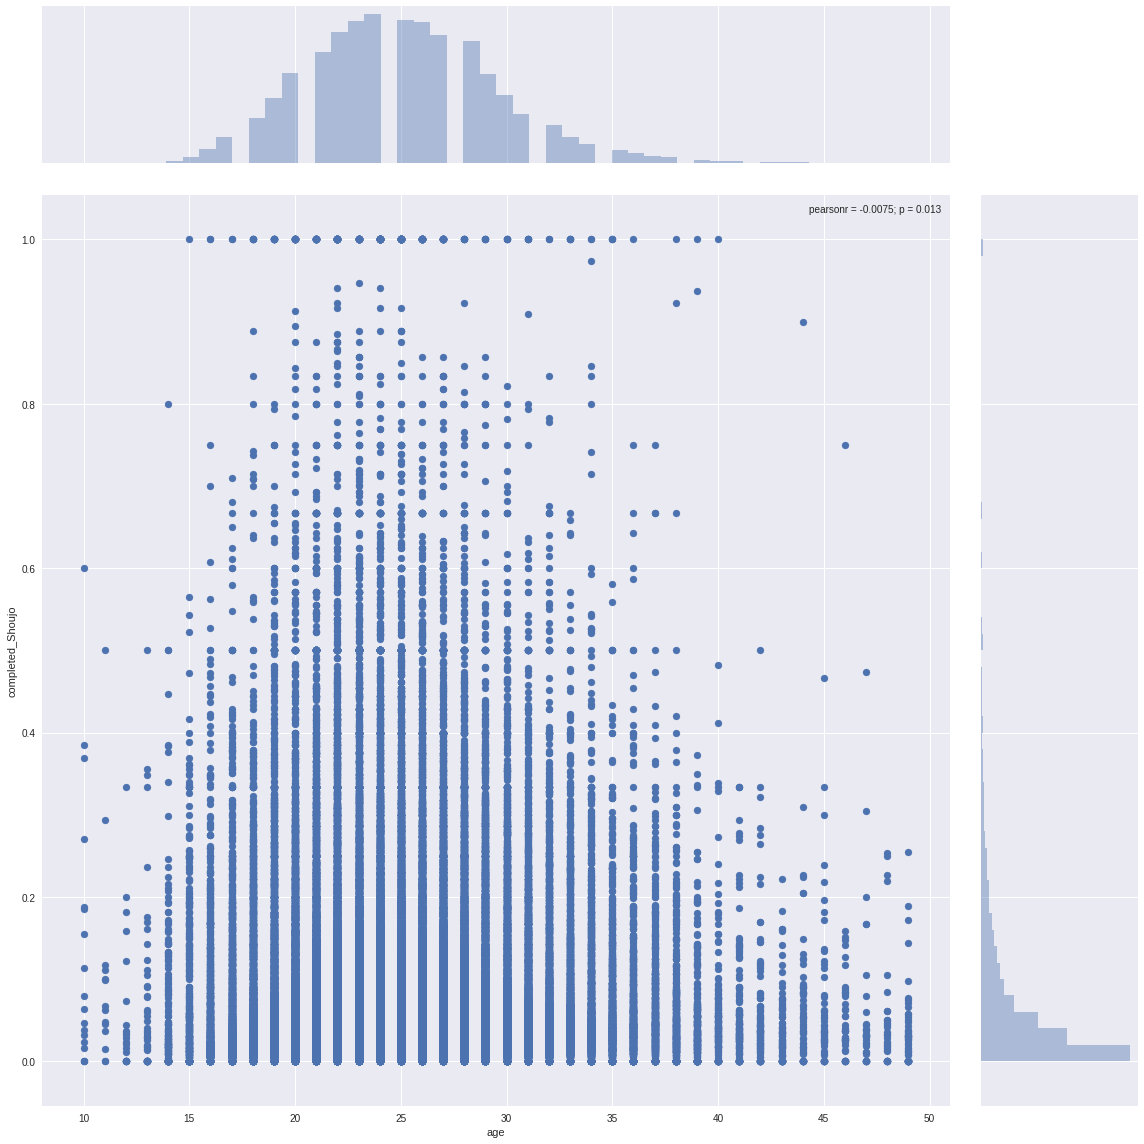

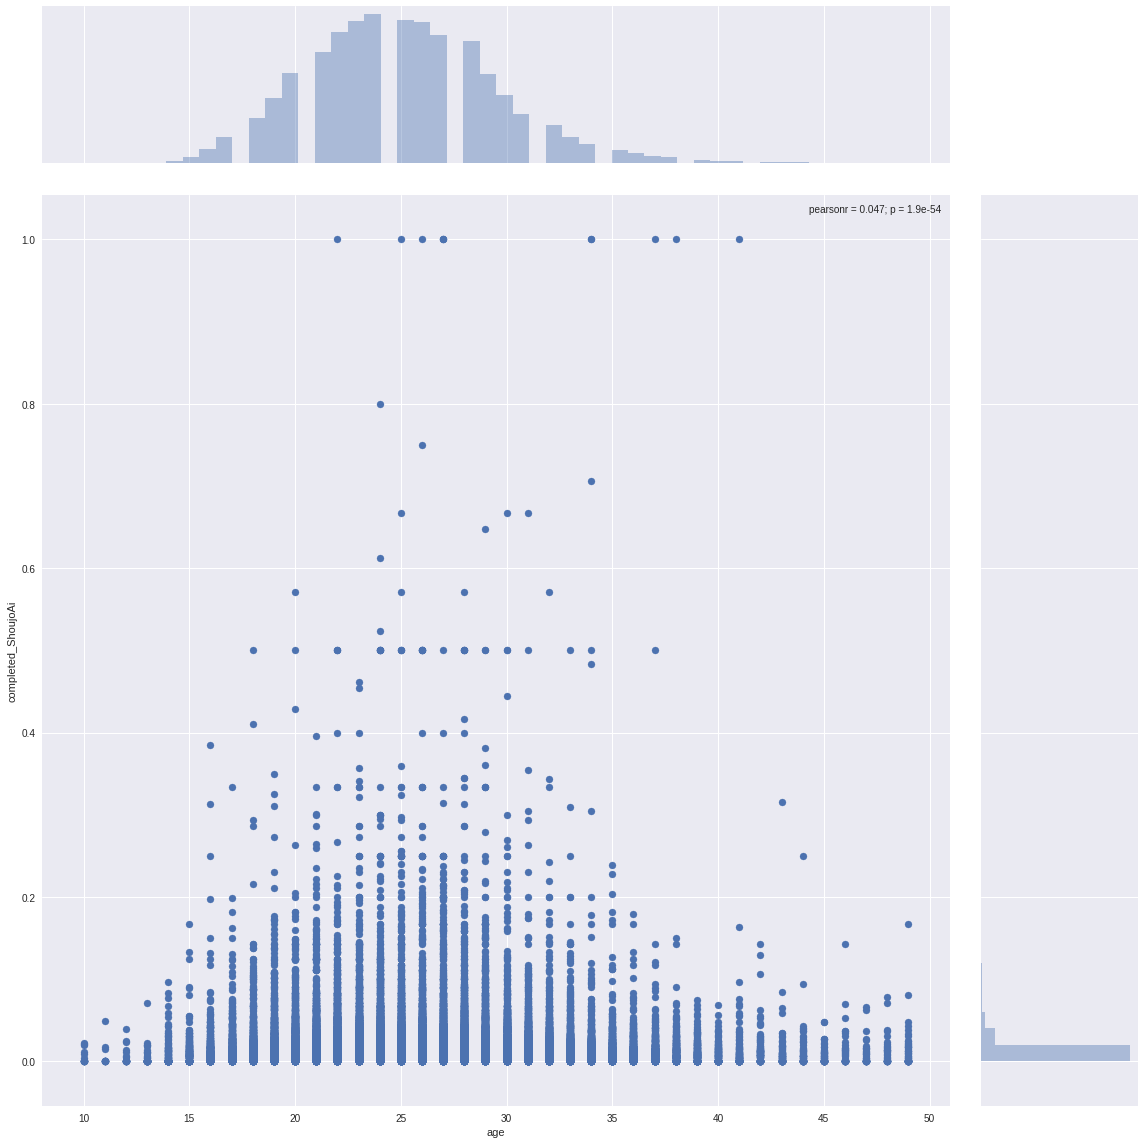

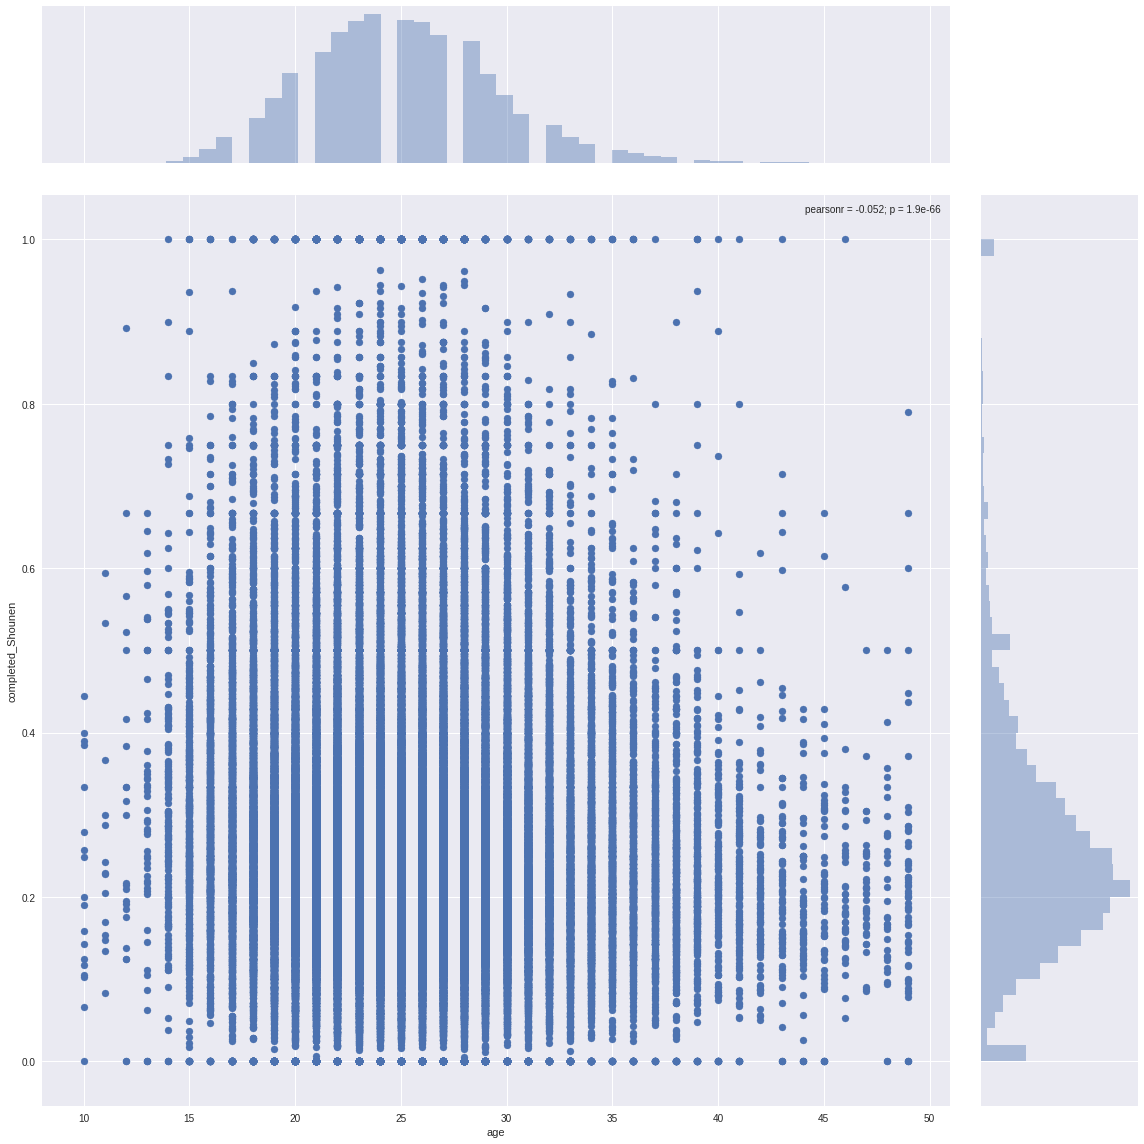

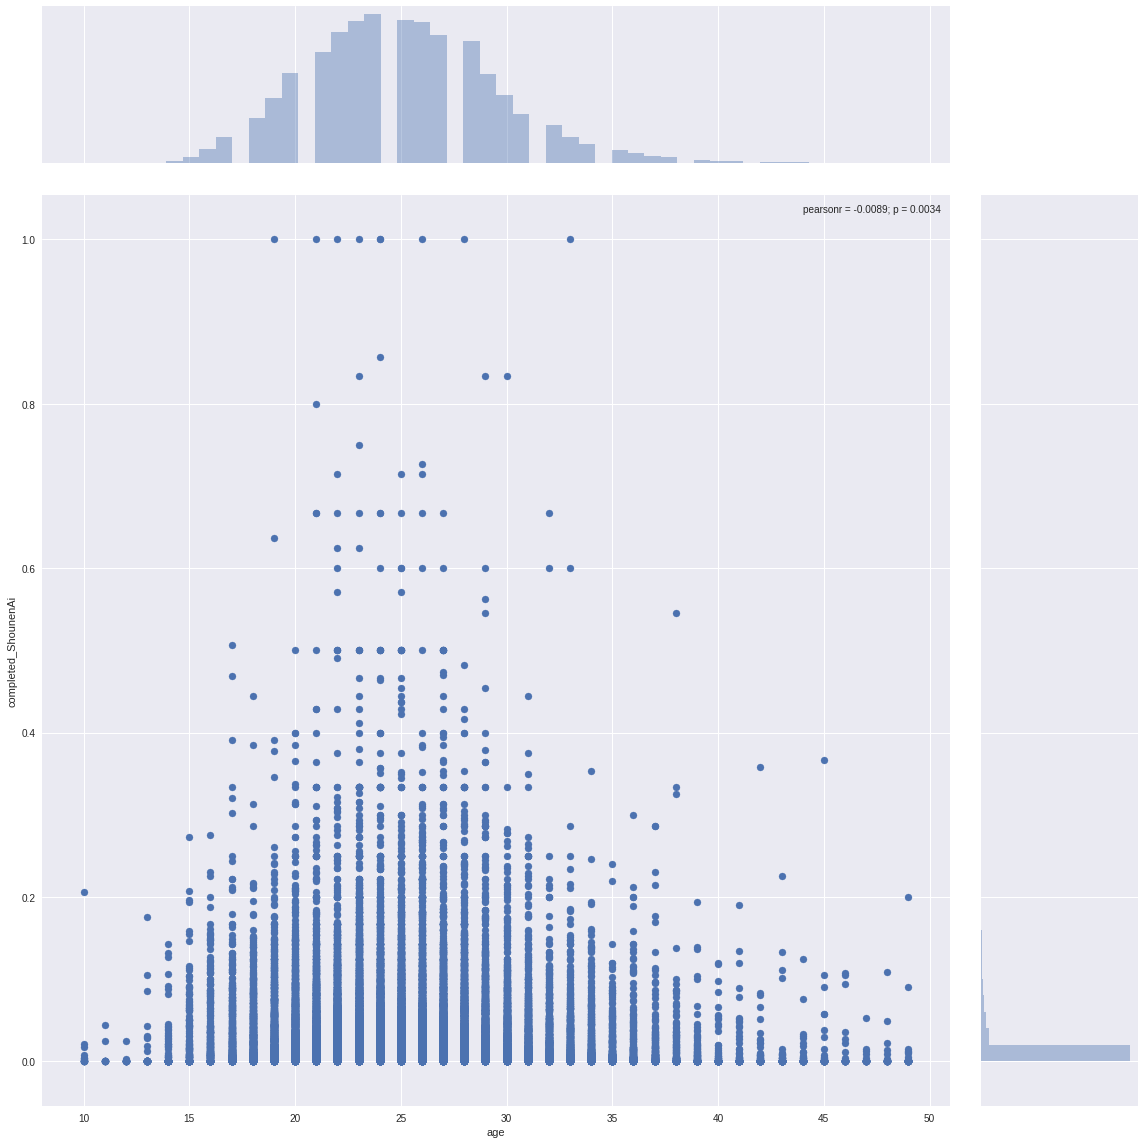

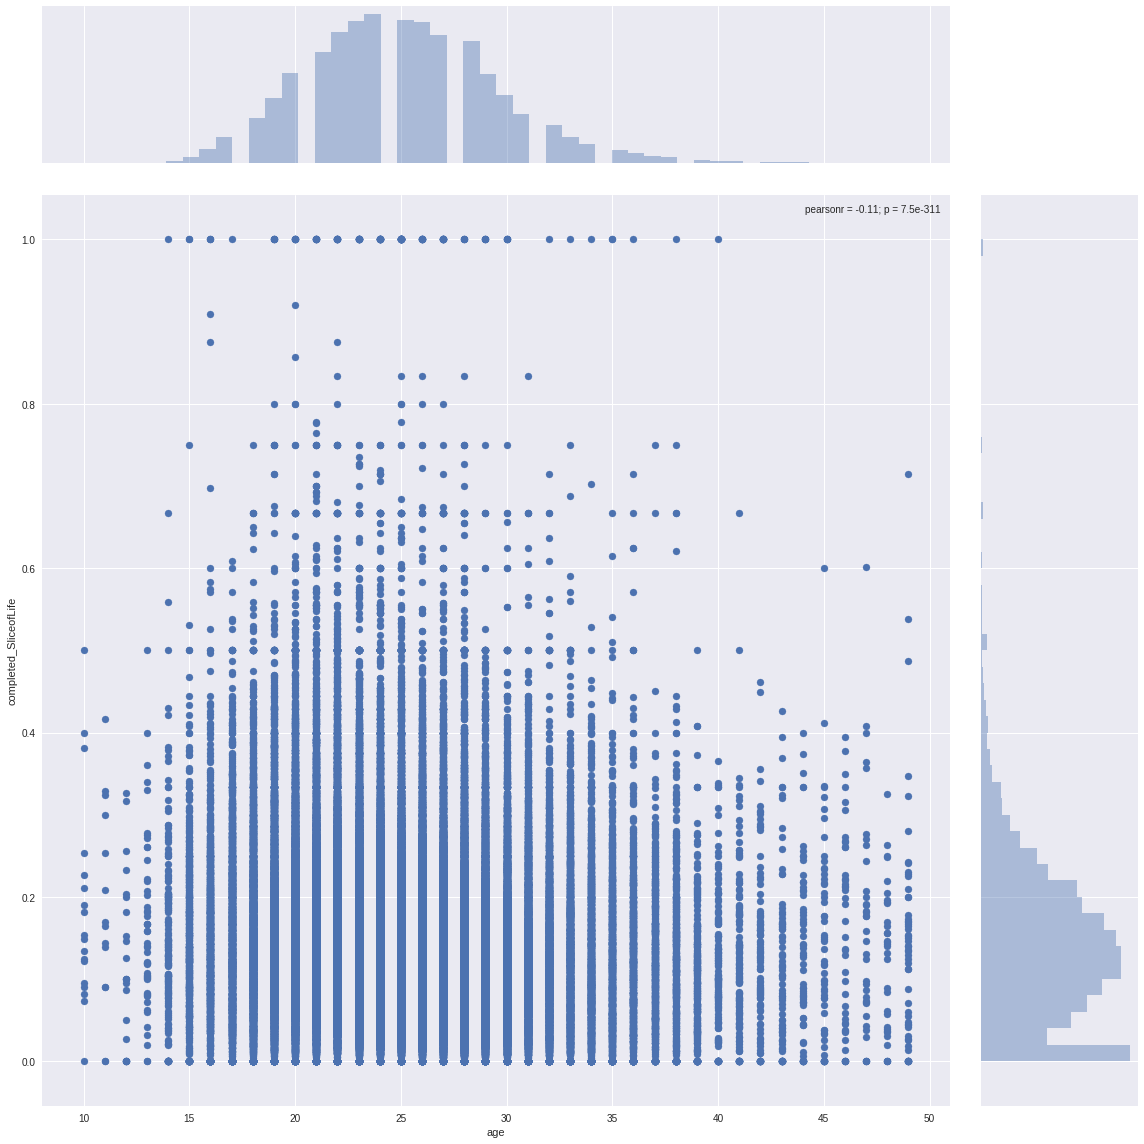

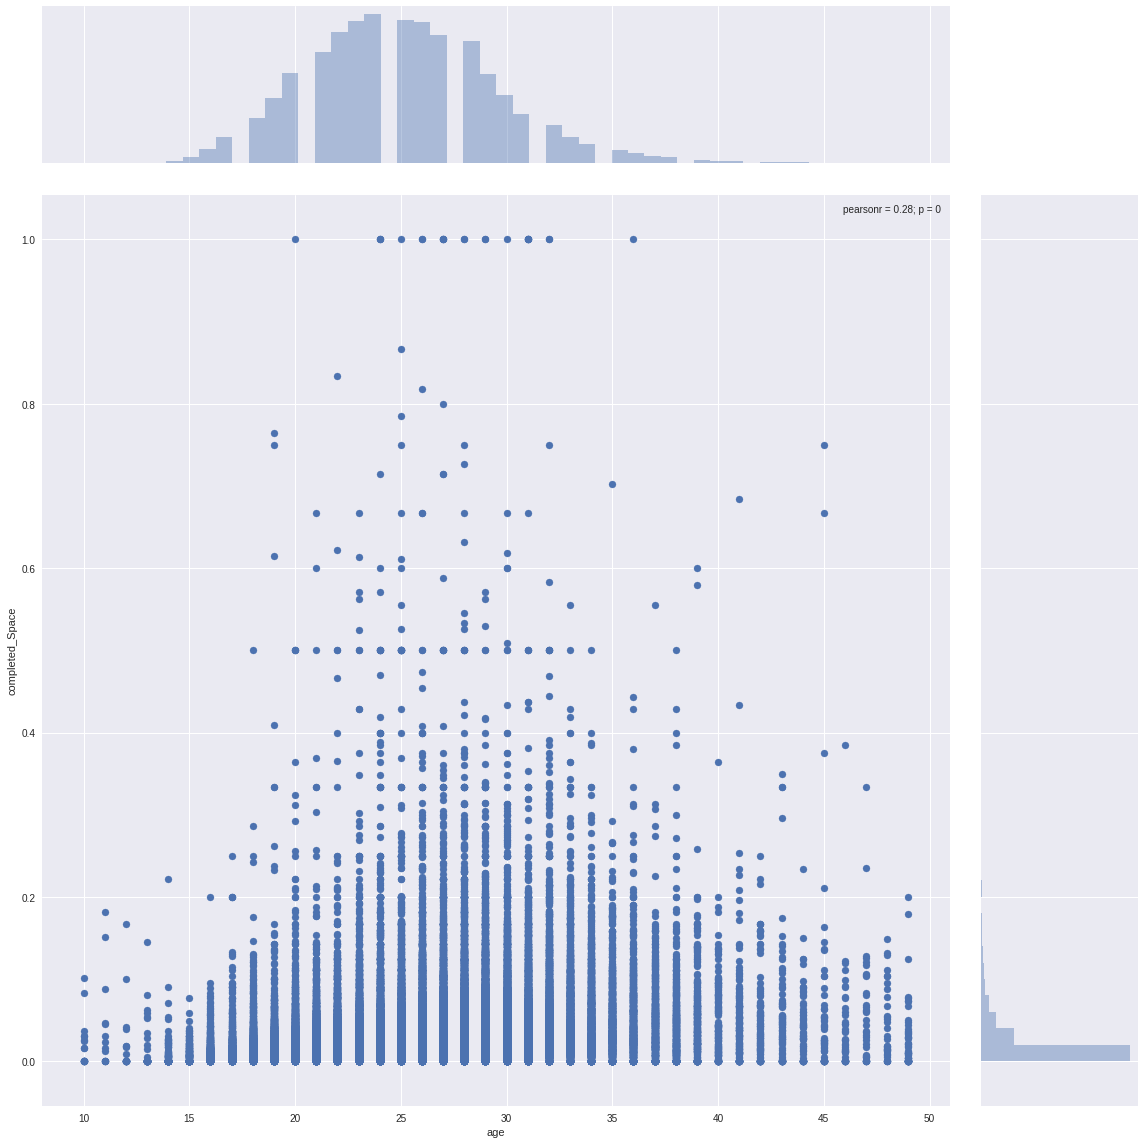

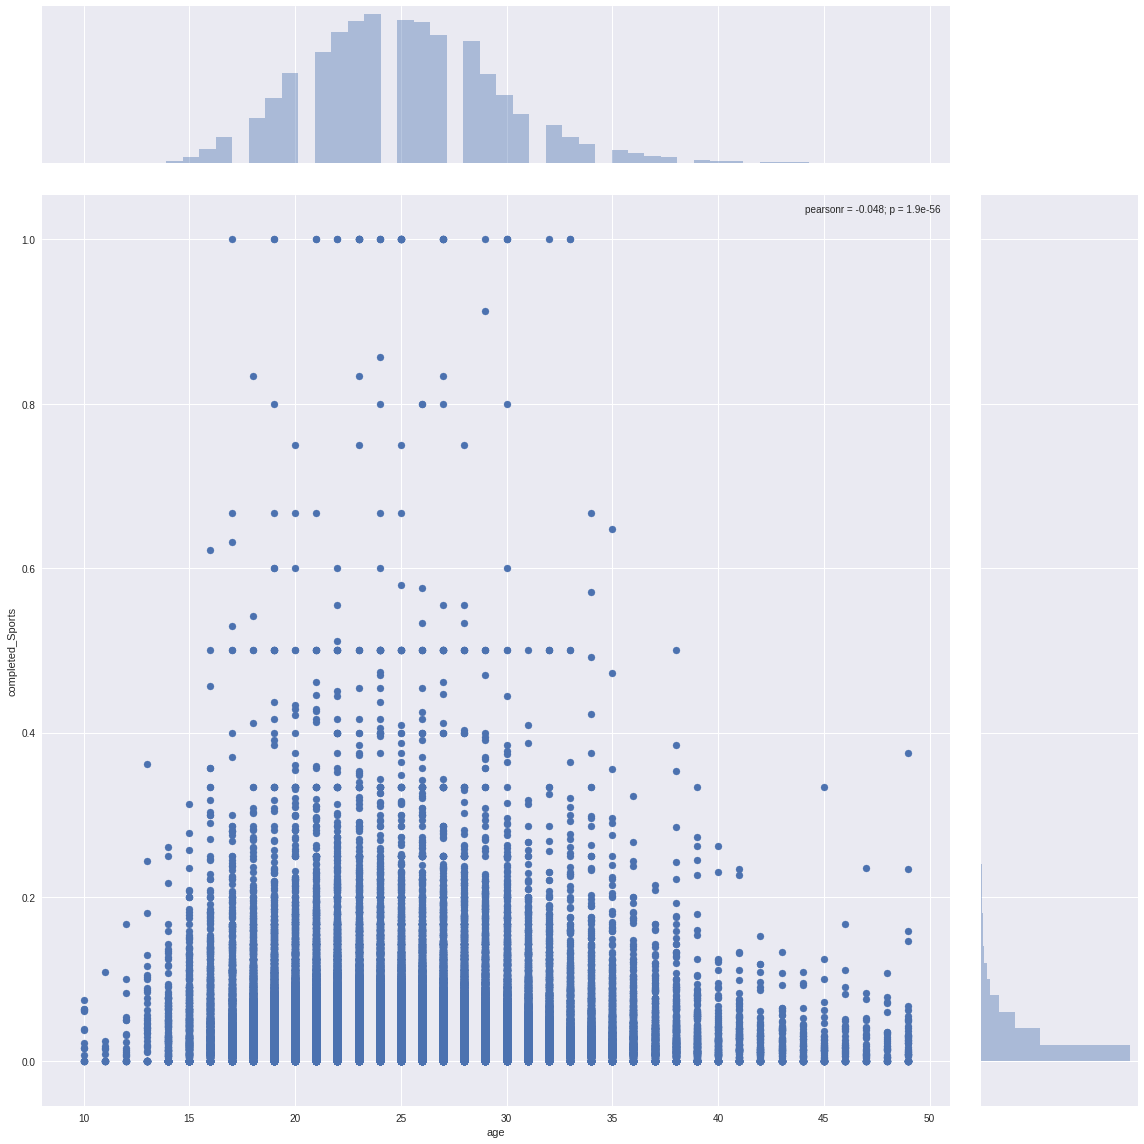

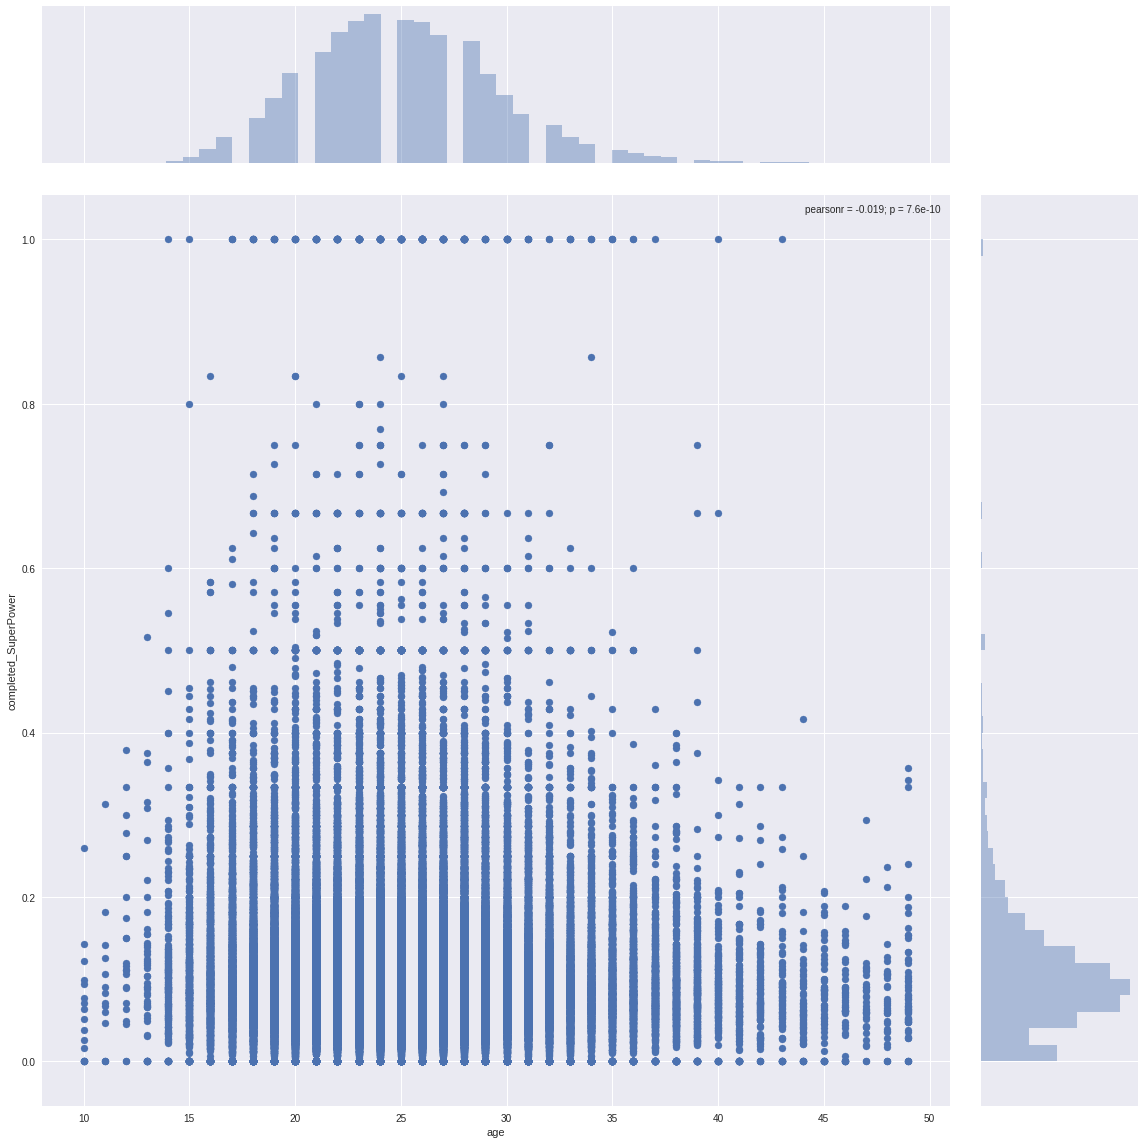

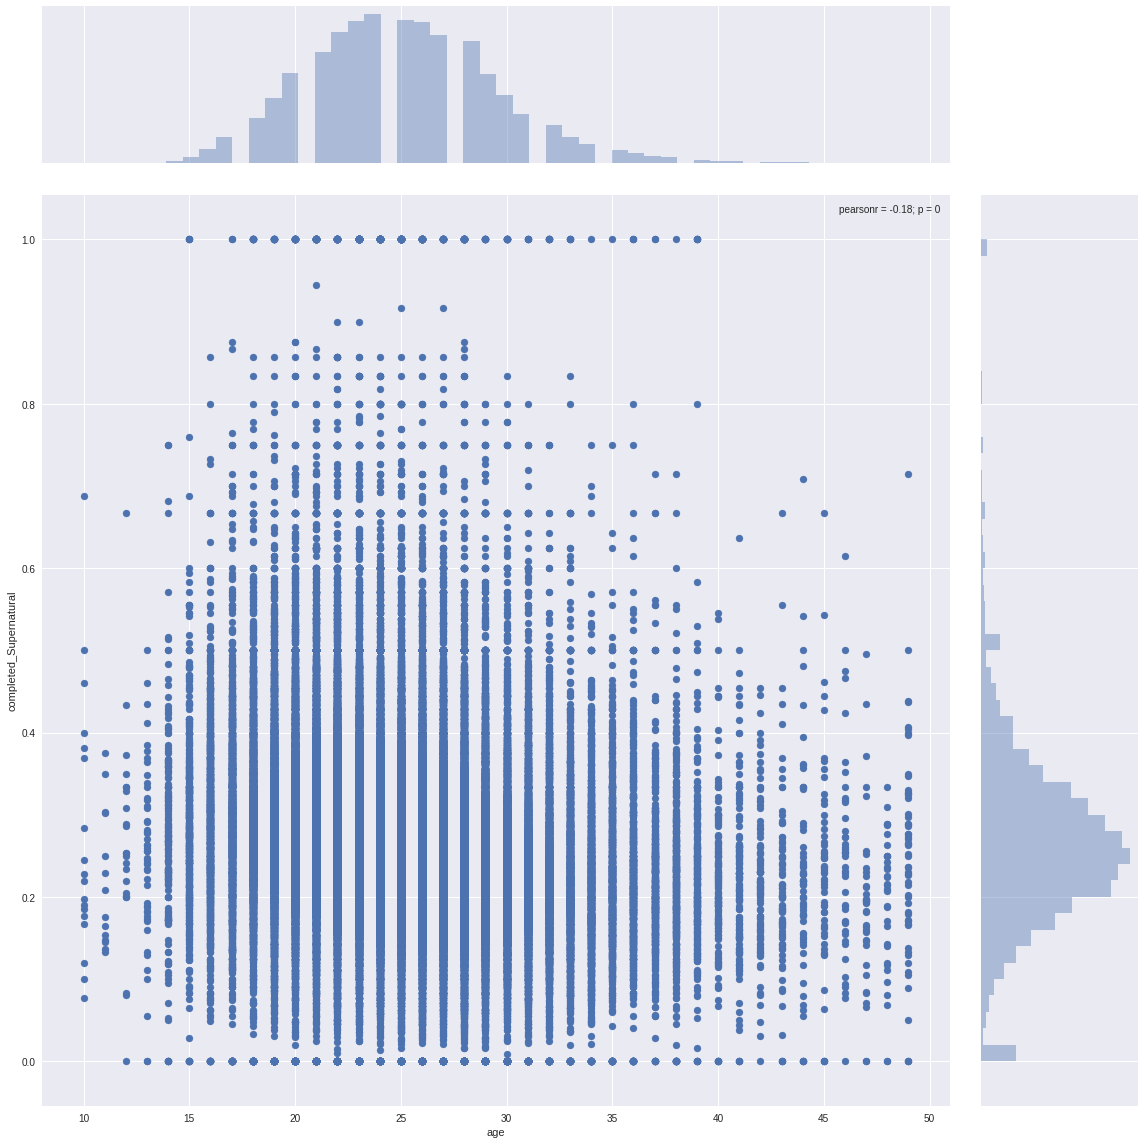

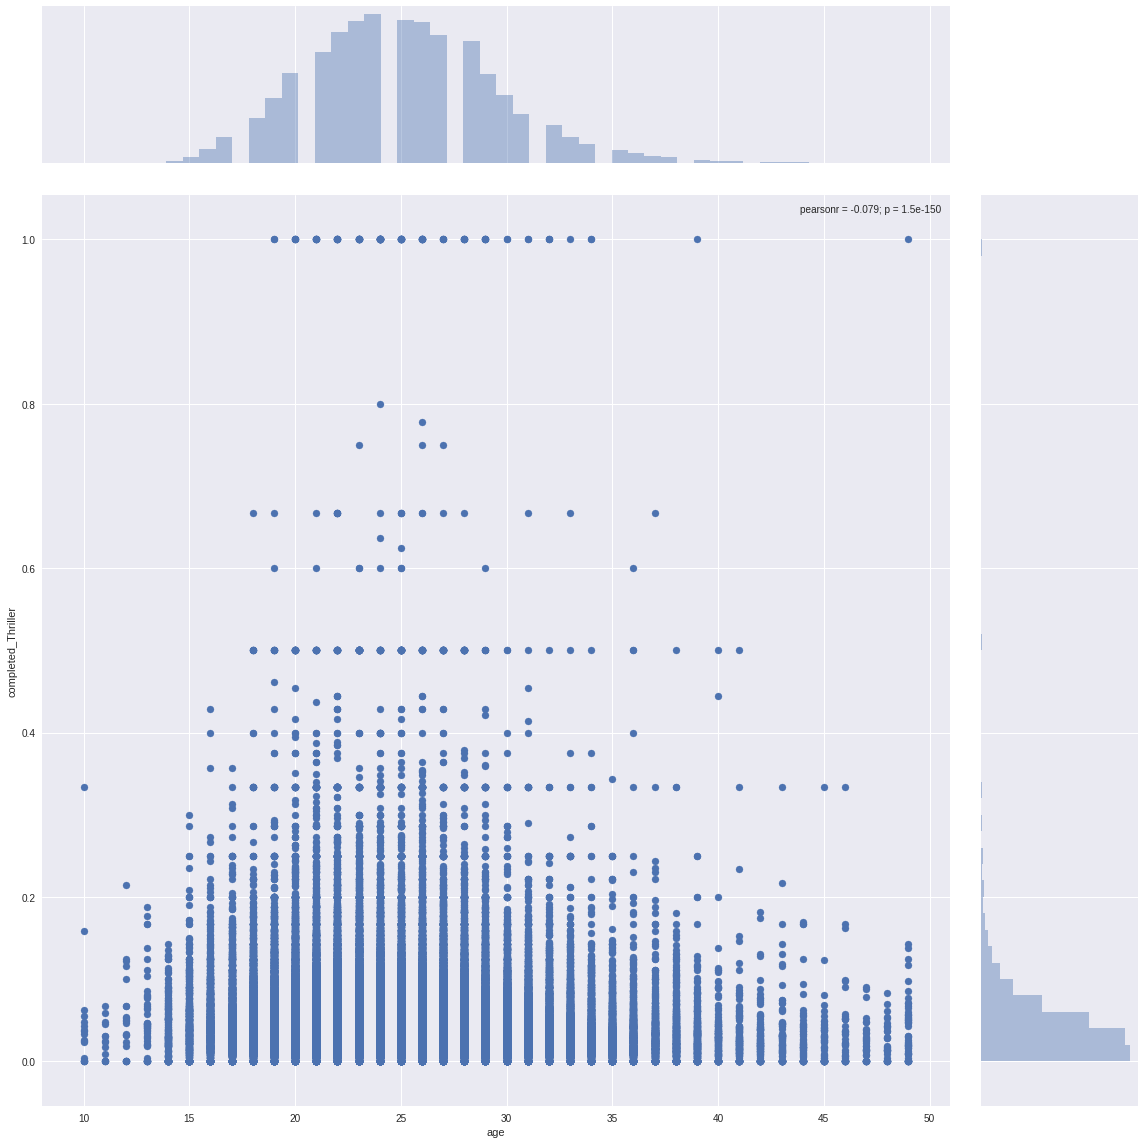

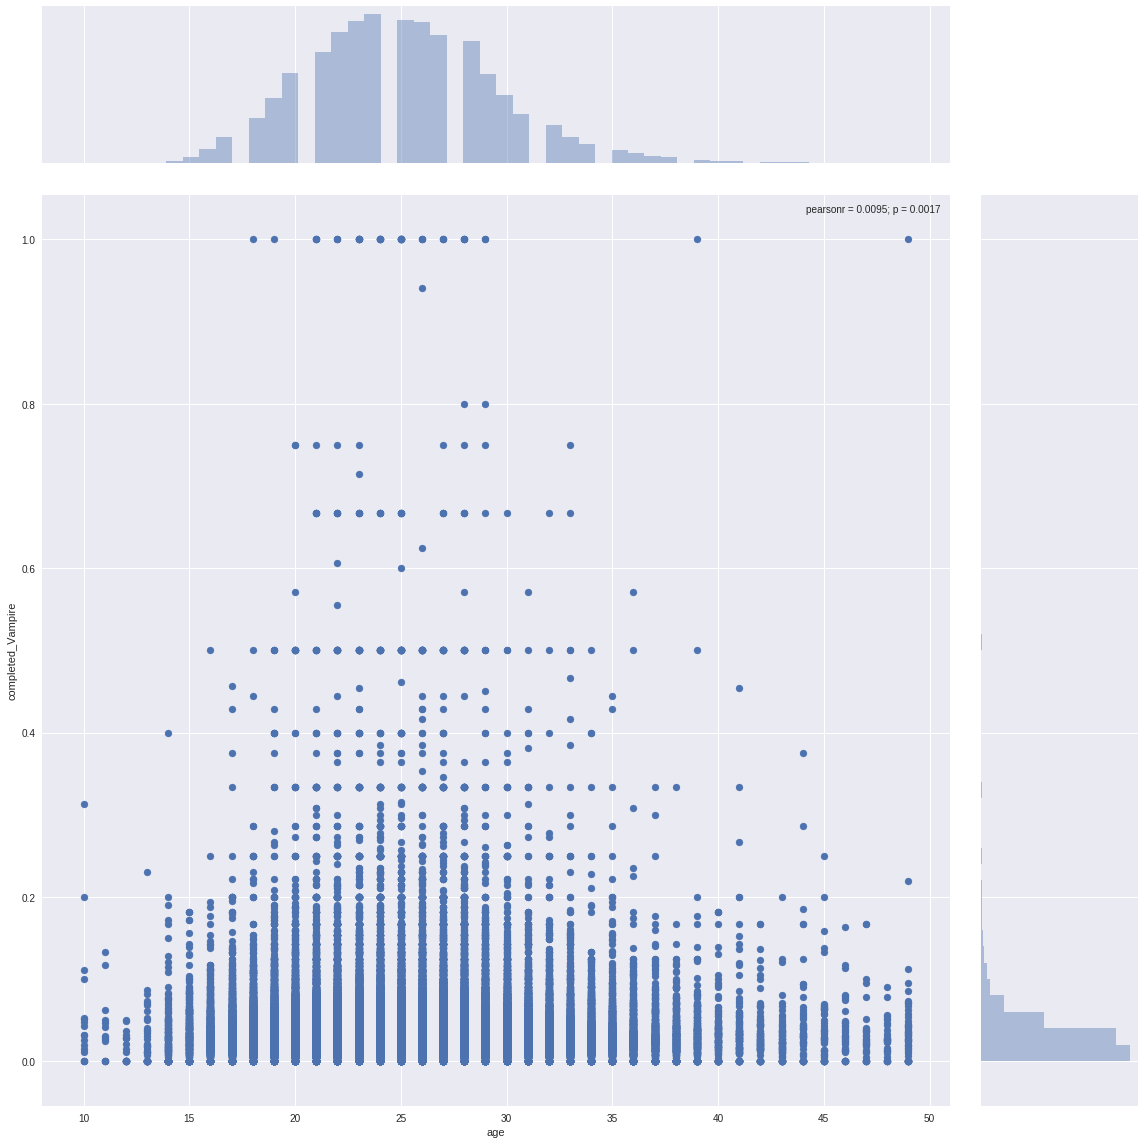

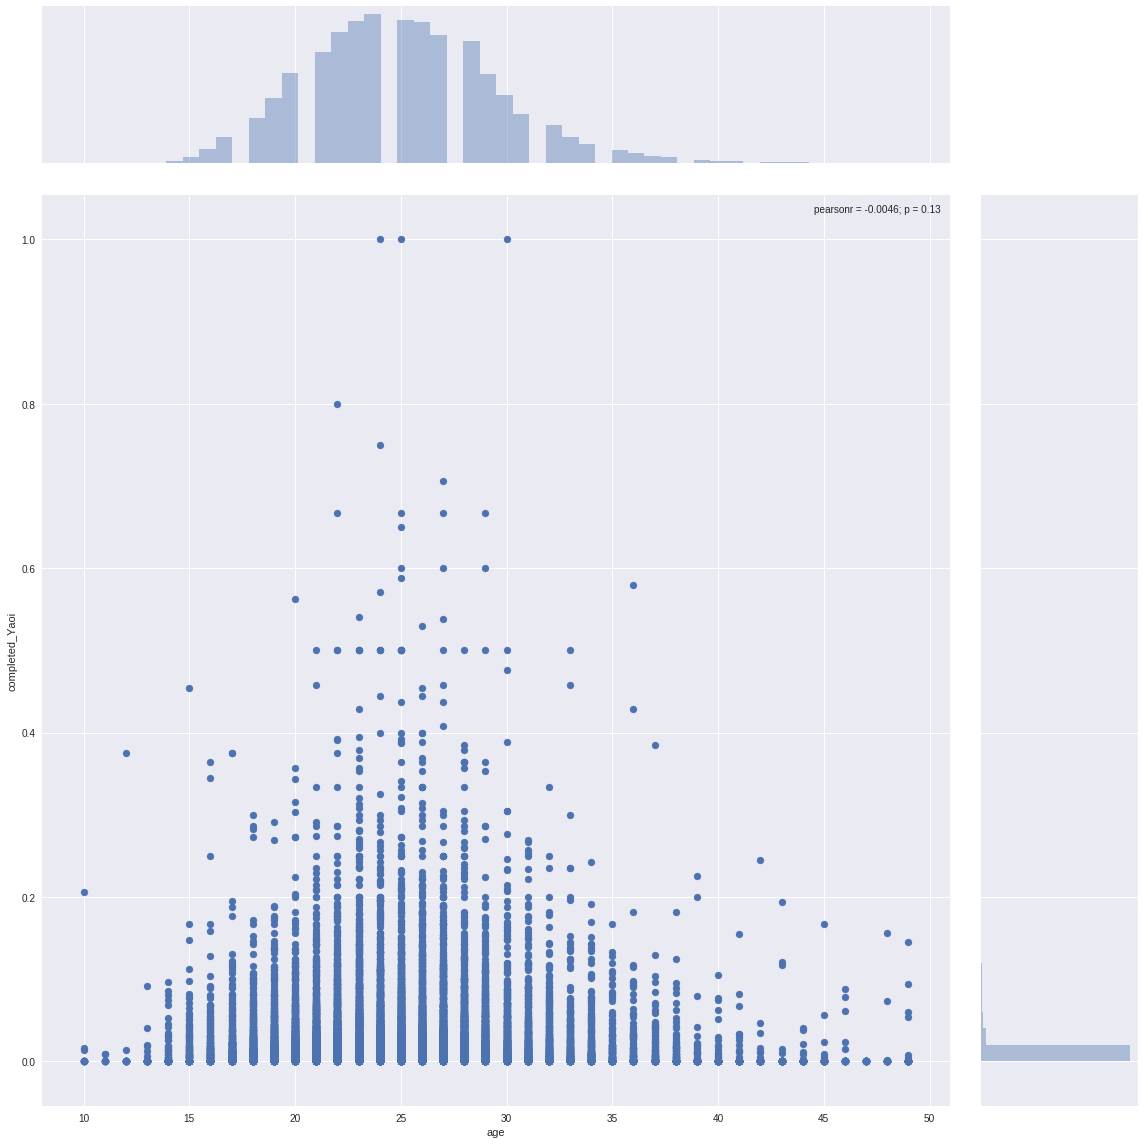

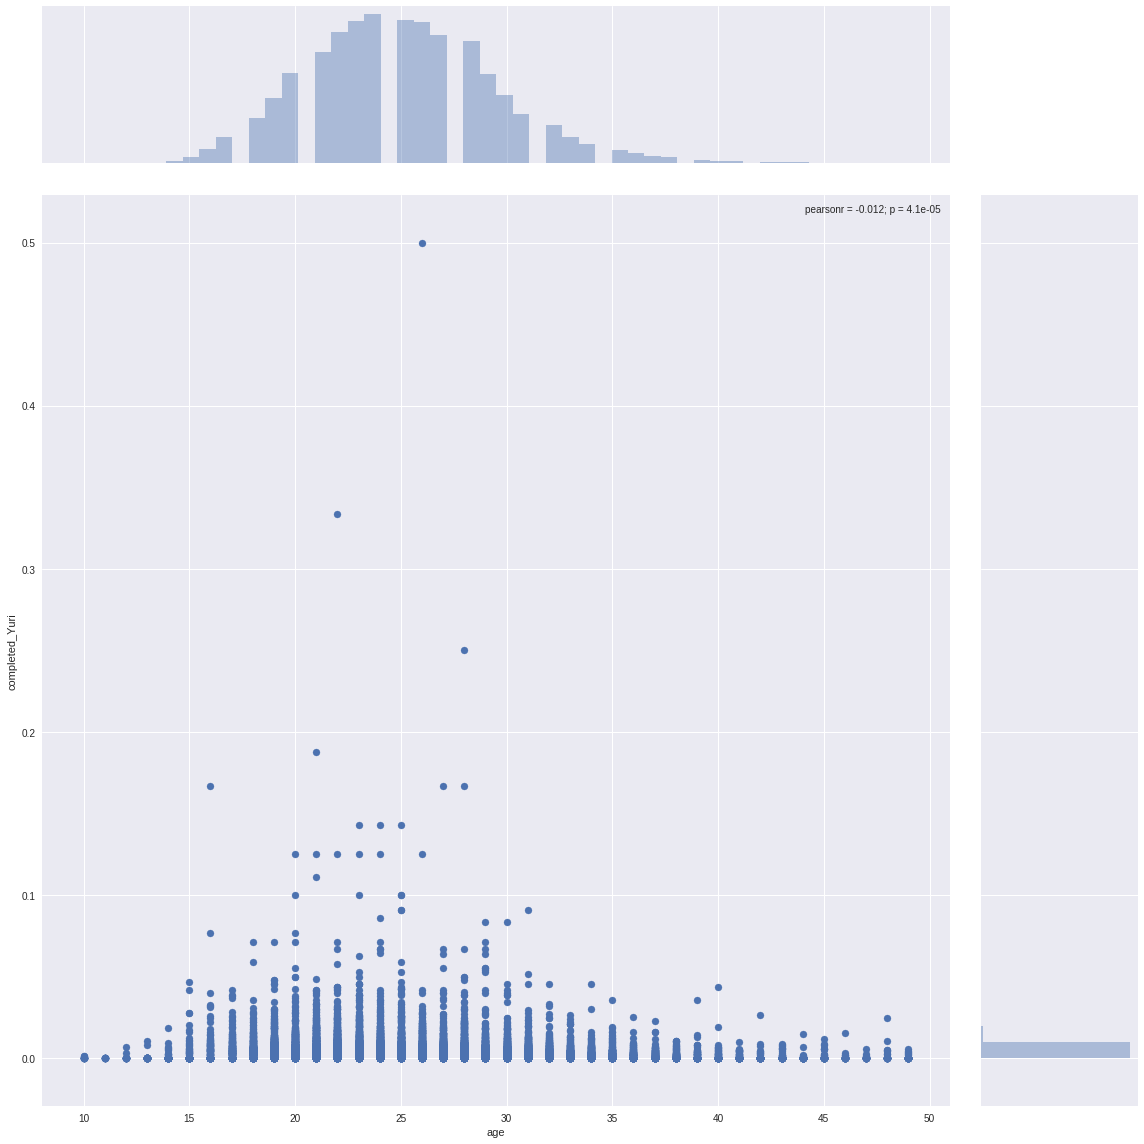

In [123]:
for genre in completed_columns:
    sns.jointplot(x='age', y=genre, data=users_ages_completed, size=16)
    plt.show()

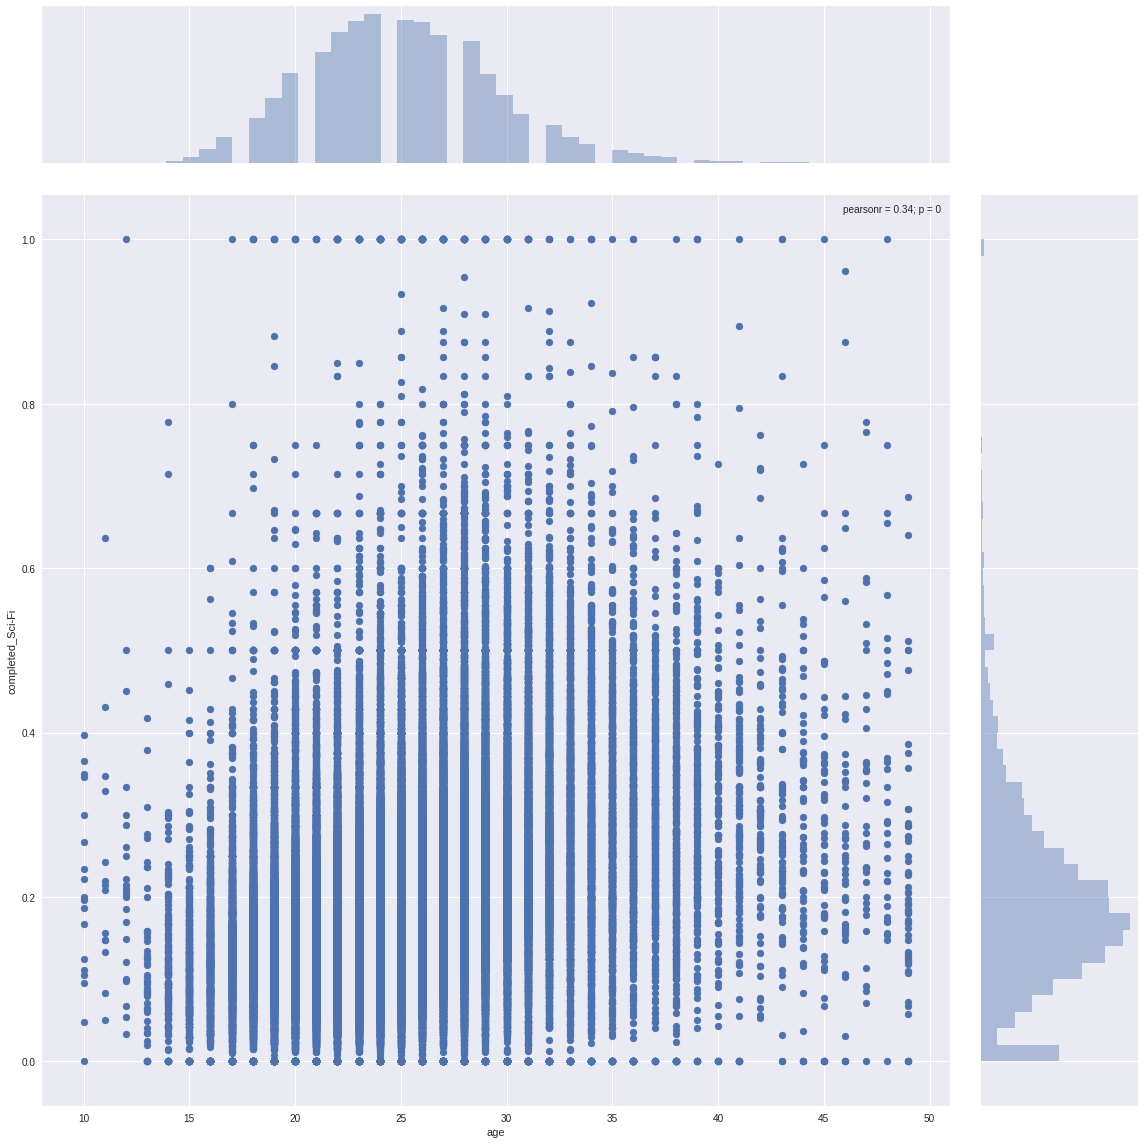

In [124]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='scatter')

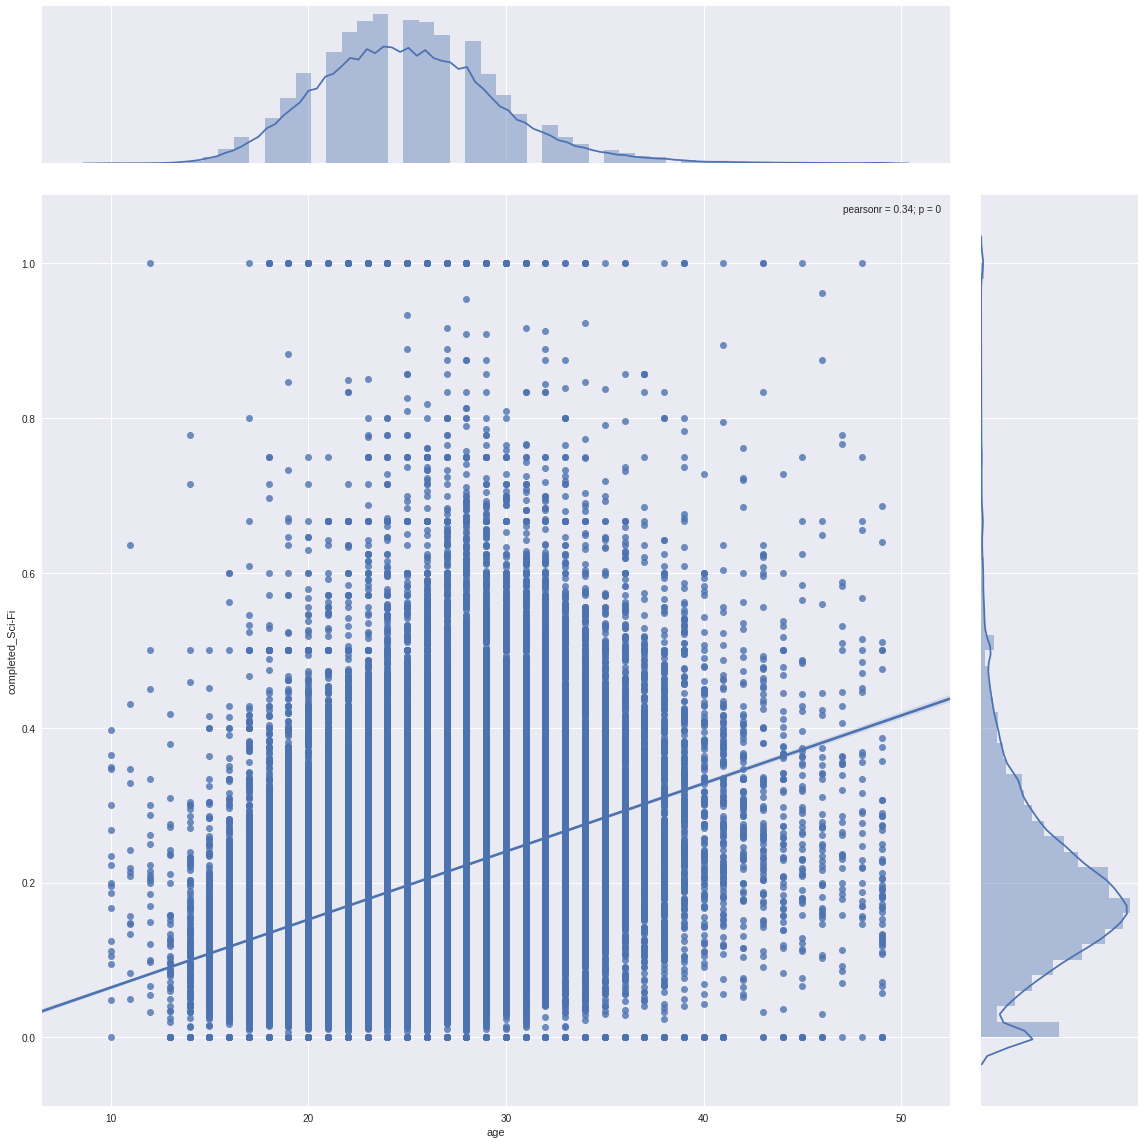

In [125]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='reg')

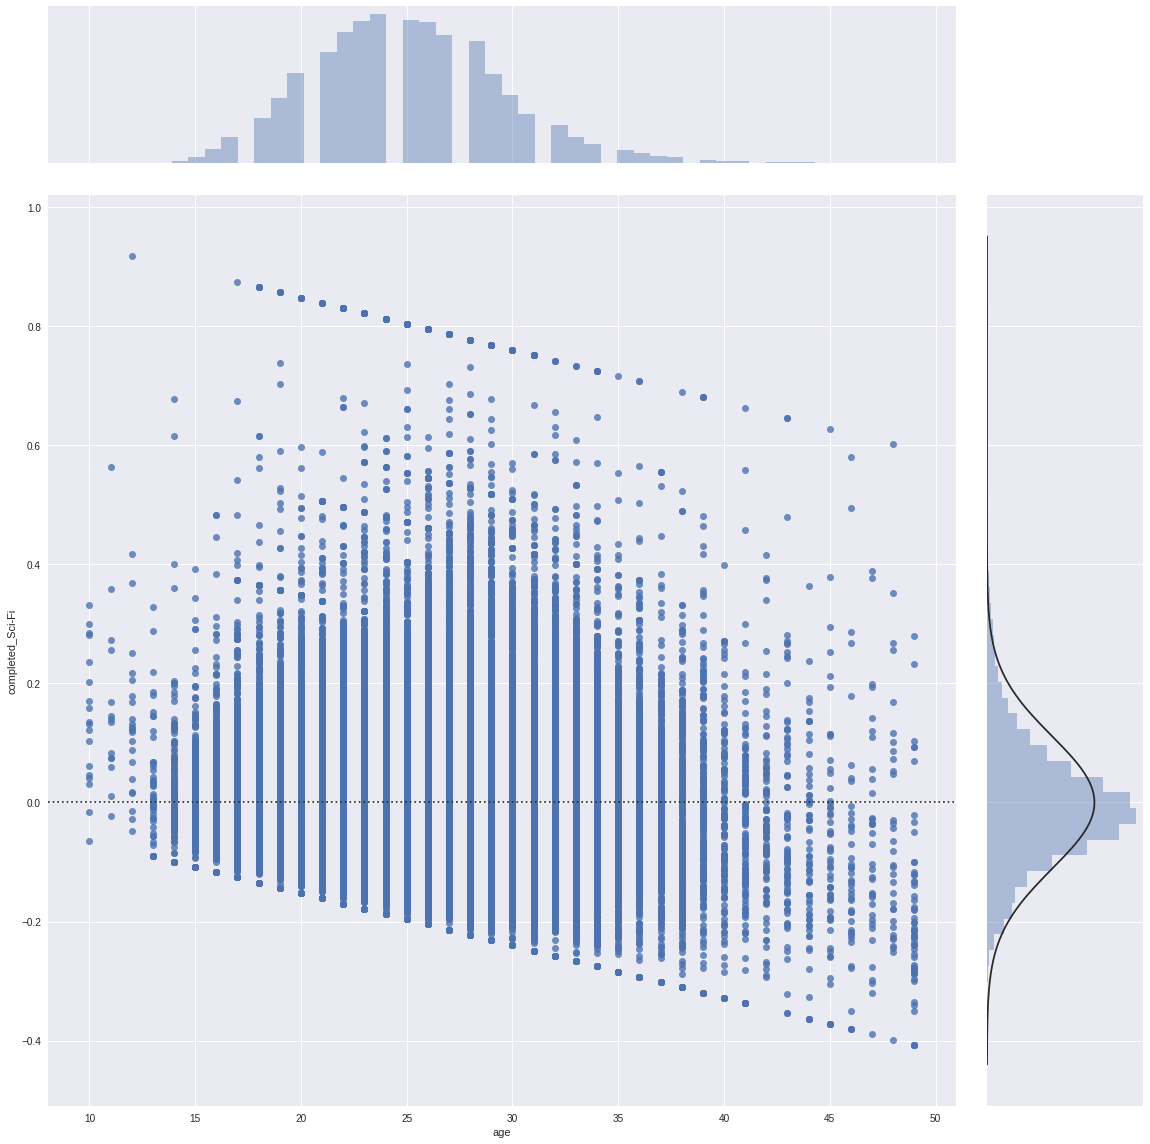

In [126]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='resid')

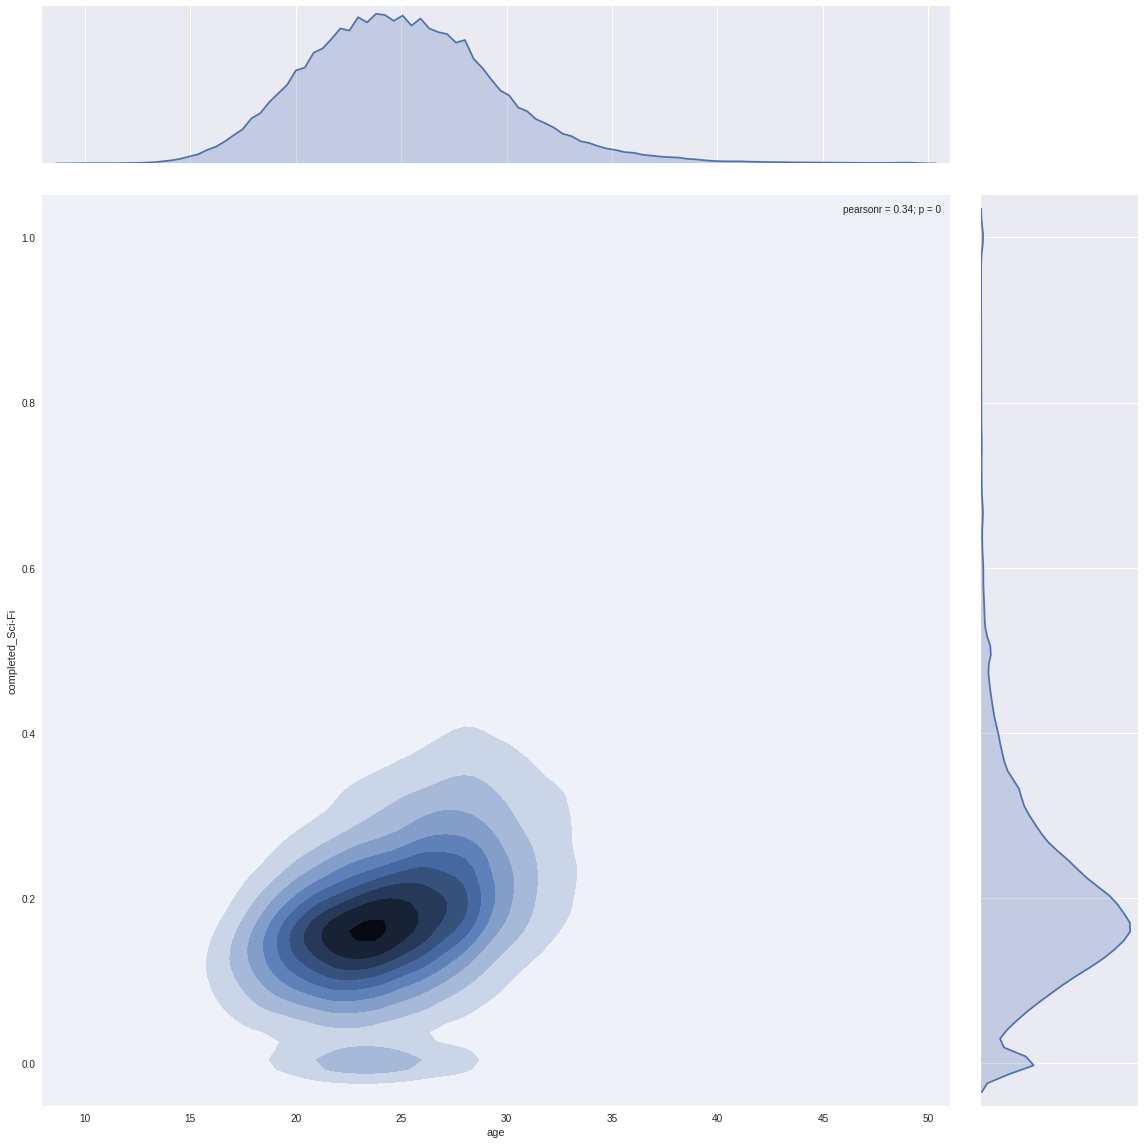

In [127]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='kde')

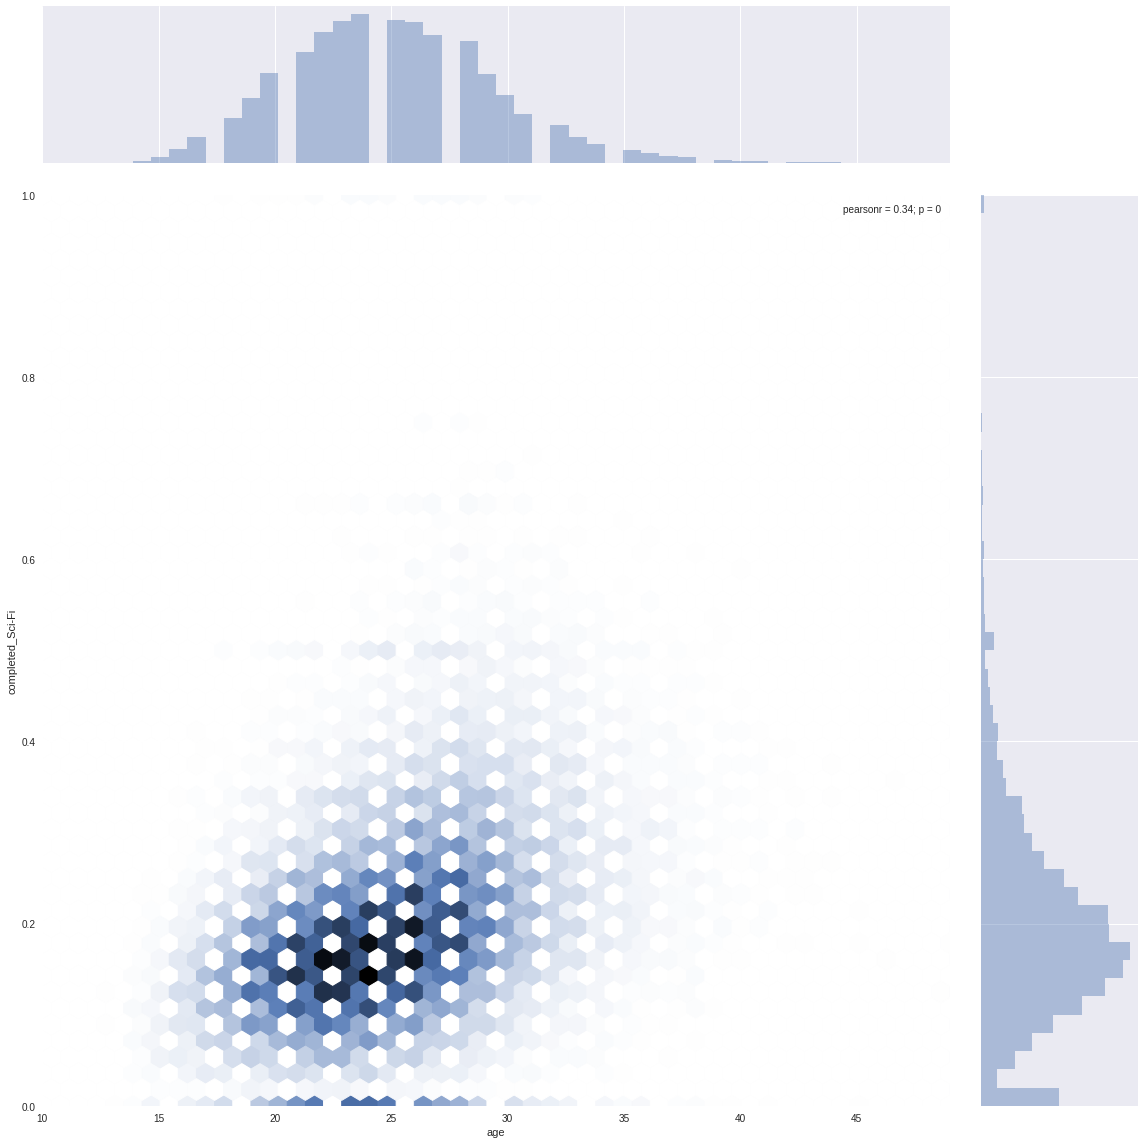

In [128]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='hex')

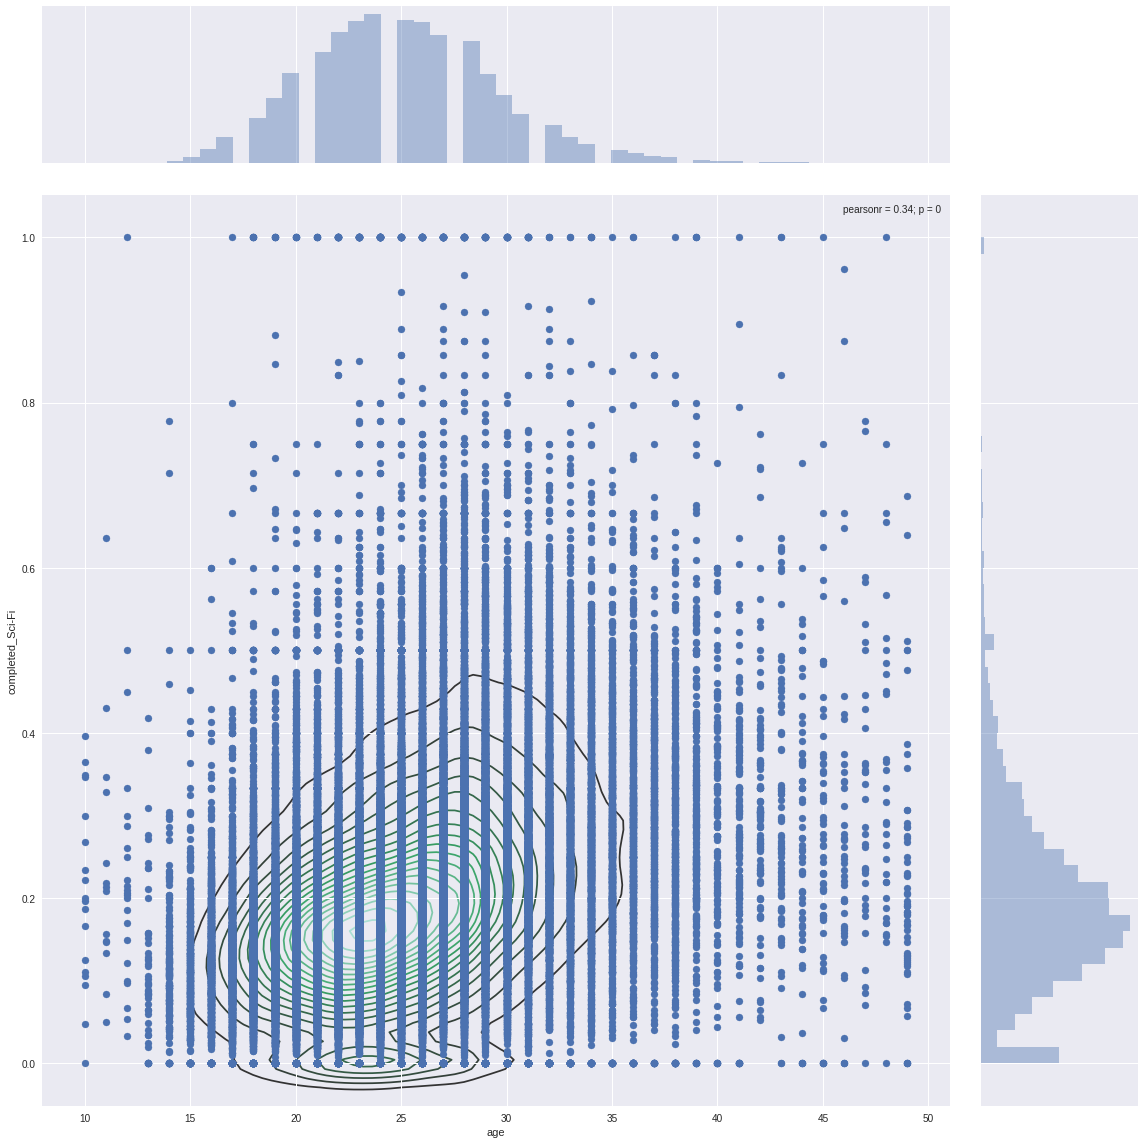

In [129]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16).plot_joint(sns.kdeplot, zorder=0, n_levels=20)

In [130]:
# entropy describes how many information it contains. Uniform distribution has highest entropy, dirac distribution lowest. 
# Lower entropy of genre means higher dependency on age
ages_genres[completed_columns].apply(entropy).sort_values()
# shows genres sorted by their dependency on age

completed_Cars             3.485755
completed_Space            3.492585
completed_Yaoi             3.562014
completed_Samurai          3.563176
completed_Mecha            3.584458
completed_Game             3.588546
completed_Kids             3.594753
completed_Yuri             3.599509
completed_Hentai           3.605697
completed_Police           3.624464
completed_Dementia         3.627963
completed_ShounenAi        3.635320
completed_ShoujoAi         3.641369
completed_Sci-Fi           3.643923
completed_Historical       3.648569
completed_Military         3.649589
completed_Josei            3.654252
completed_School           3.659482
completed_Thriller         3.662874
completed_Sports           3.663217
completed_Shoujo           3.665148
completed_Harem            3.667687
completed_Vampire          3.668165
completed_MartialArts      3.669000
completed_Parody           3.674628
completed_Demons           3.675401
completed_SuperPower       3.675914
completed_Music            3

In [131]:
arr = np.ones(ages_genres.index.size)
entropy(arr / arr.sum())

3.6888794541139363

In [132]:
dependent_genres = ages_genres[completed_columns]..apply(entropy).sort_values().index[0:6]

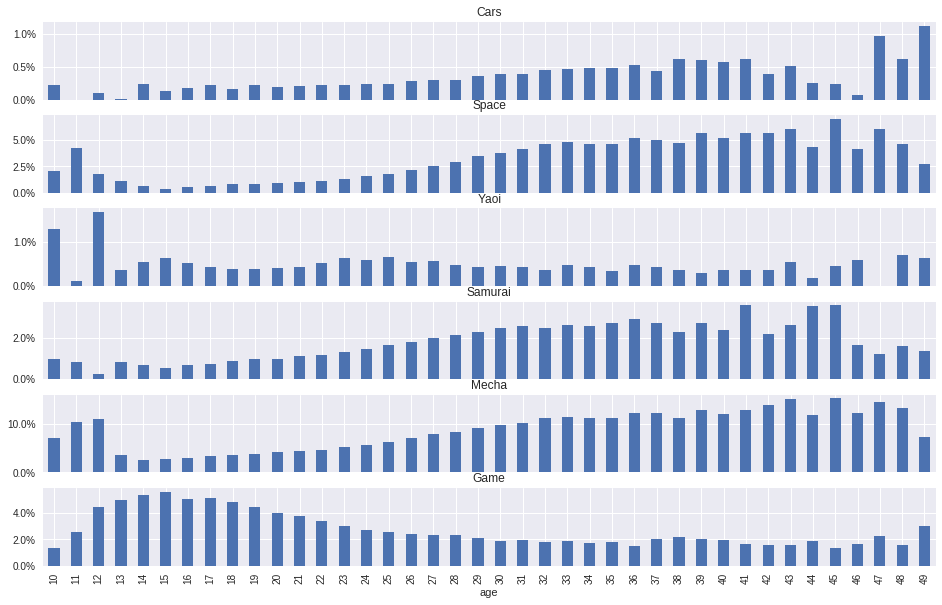

In [133]:
fig, ax = plt.subplots(len(dependent_genres), 1, sharex=True, figsize=(16, 10))
for i, genre in enumerate(dependent_genres):
    ages_genres[genre].plot(kind='bar', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

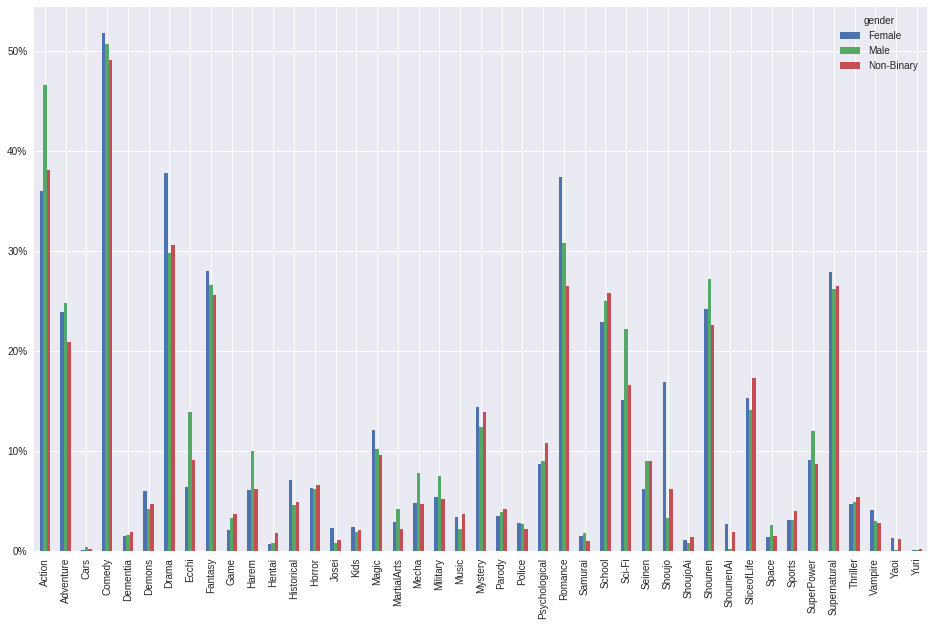

In [134]:
genders_genres.T.plot(kind='bar', figsize=(16, 10))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: genders_genres.columns[y].replace('completed_', '')))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [135]:
genders_genres[completed_columns].apply(entropy).sort_values()

completed_ShounenAi        0.817397
completed_Yaoi             0.844270
completed_Shoujo           0.882756
completed_Cars             0.968583
completed_Josei            0.992285
completed_Yuri             1.001992
completed_Hentai           1.008232
completed_Ecchi            1.048022
completed_Space            1.054504
completed_MartialArts      1.061397
completed_Mecha            1.067301
completed_Harem            1.069691
completed_Game             1.071183
completed_Samurai          1.071417
completed_Music            1.075303
completed_ShoujoAi         1.076443
completed_Historical       1.079173
completed_Military         1.083970
completed_Seinen           1.084376
completed_Sci-Fi           1.084549
completed_Vampire          1.085150
completed_Demons           1.087056
completed_SuperPower       1.087909
completed_Romance          1.088550
completed_Sports           1.091679
completed_Dementia         1.092227
completed_Action           1.092308
completed_Drama            1

In [136]:
genders_genres[completed_columns].apply(np.var).sort_values(ascending=False)

completed_Shoujo           3.431323e-03
completed_Action           2.082840e-03
completed_Romance          2.015803e-03
completed_Drama            1.300314e-03
completed_Ecchi            9.761156e-04
completed_Sci-Fi           9.305689e-04
completed_Shounen          3.708065e-04
completed_Harem            3.335962e-04
completed_Adventure        2.865685e-04
completed_Mecha            2.161236e-04
completed_SuperPower       2.146788e-04
completed_SliceofLife      1.772677e-04
completed_Seinen           1.759742e-04
completed_School           1.496529e-04
completed_Comedy           1.227786e-04
completed_Historical       1.219895e-04
completed_Magic            1.145358e-04
completed_Military         1.087560e-04
completed_ShounenAi        1.069863e-04
completed_Fantasy          1.012226e-04
completed_Psychological    8.507352e-05
completed_Mystery          7.421166e-05
completed_MartialArts      7.155444e-05
completed_Demons           5.818295e-05
completed_Supernatural     5.757436e-05


In [137]:
arr = np.ones(genders_genres.index.size)
entropy(arr / arr.sum())

1.0986122886681096

In [138]:
# variance is better than entropy now
dependent_genres = genders_genres[completed_columns].apply(np.var).sort_values(ascending=False).index[0:12]

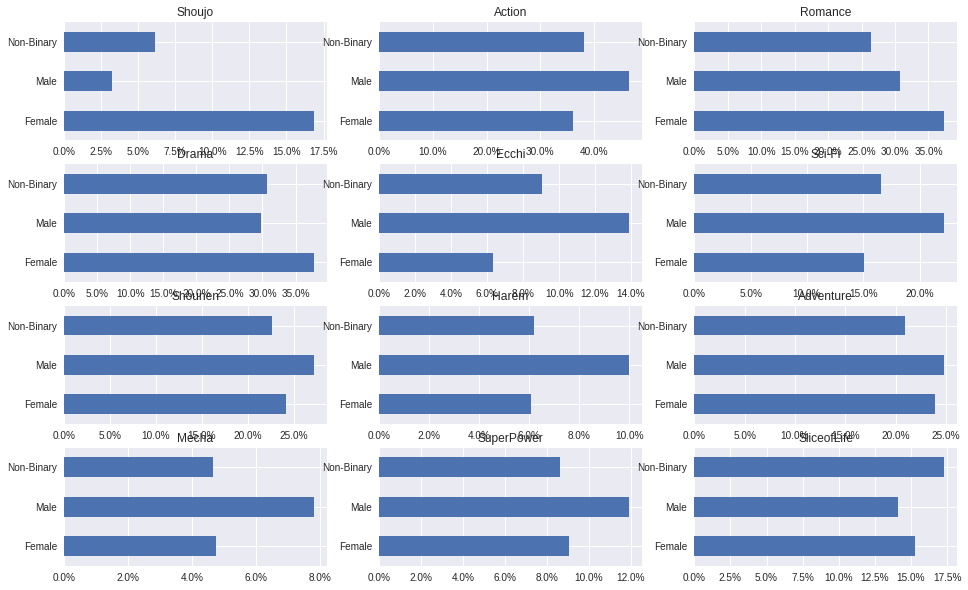

In [139]:
sqrt_num = np.ceil(np.sqrt(len(dependent_genres))).astype('int')
#fig, ax = plt.subplots(sqrt_num, sqrt_num, figsize=(16, 10), squeeze=False)
fig, ax = plt.subplots(4, 3, figsize=(16, 10), squeeze=False)
ax = ax.flatten()
for i, genre in enumerate(dependent_genres):
    genders_genres[genre].plot(kind='barh', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    ax[i].set_ylabel('')


In [140]:
### and now binning ages into equi-sized bins
age_bins, intervals = pd.qcut(users['age'], 10, retbins=True)
intervals

array([10., 20., 21., 23., 24., 25., 26., 27., 29., 31., 49.])

In [141]:
age_bins.value_counts()
# these intervals suck, they fit 10-20 into one interval

(21.0, 23.0]     17871
(9.999, 20.0]    16448
(27.0, 29.0]     13788
(23.0, 24.0]      9760
(24.0, 25.0]      9379
(25.0, 26.0]      9231
(31.0, 49.0]      8927
(26.0, 27.0]      8383
(29.0, 31.0]      7690
(20.0, 21.0]      7234
Name: age, dtype: int64

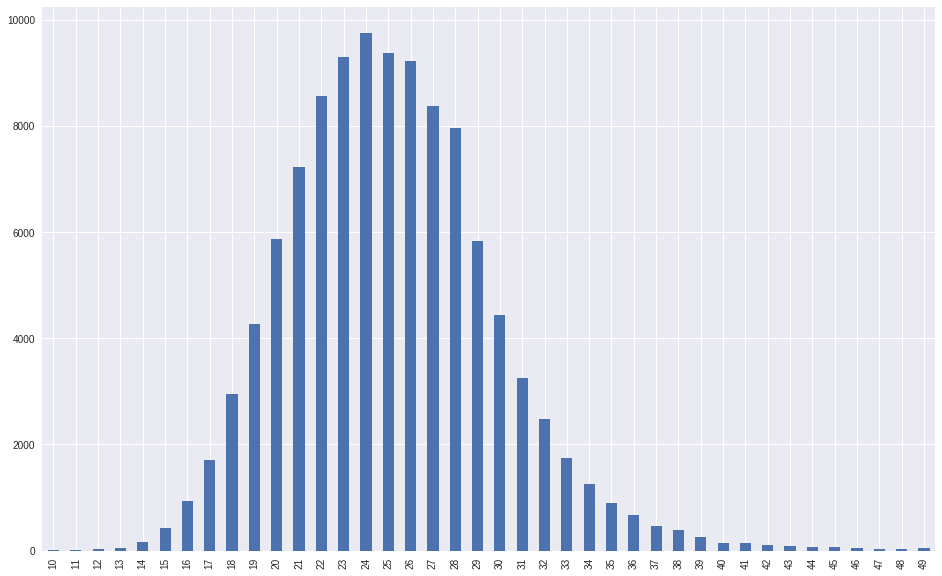

In [142]:
users_ages_completed['age'].value_counts().sort_index().plot(kind='bar', figsize=(16, 10))

In [143]:
bins = [9, 14, 17, 20, 23, 26, 30, 40, 50]
pd.cut(users_ages_completed['age'], bins, right=True).value_counts()
# hand-crafted by intuition

(23, 26]    28370
(26, 30]    26617
(20, 23]    25105
(17, 20]    13097
(30, 40]    11555
(14, 17]     3077
(40, 50]      616
(9, 14]       274
Name: age, dtype: int64

In [144]:
users_ages_completed['age_bin'] = pd.cut(users_ages_completed['age'], bins, right=True).astype(str)

In [145]:
users_ages_completed['age_bin'].value_counts()

(23, 26]    28370
(26, 30]    26617
(20, 23]    25105
(17, 20]    13097
(30, 40]    11555
(14, 17]     3077
(40, 50]      616
(9, 14]       274
Name: age_bin, dtype: int64

In [146]:
def tree_to_table(clf, target_column):
    def expand_node(curr_node, prefix):
        # three is balanced
        thr_percent = "{0:.1%}".format(threshold[curr_node])
        fname = fnames[feature[curr_node]]
        if children_left[curr_node] == -1 and children_right[curr_node] == -1:
            return [prefix], [targets[curr_node]], [value[curr_node, 0, :]]
        l_res, l_target, l_distr = expand_node(children_left[curr_node], prefix + [fname + ' <= ' + thr_percent])
        r_res, r_target, r_distr = expand_node(children_right[curr_node], prefix + [fname + ' > ' + thr_percent])
        return l_res + r_res, l_target + r_target, l_distr + r_distr

    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    value = clf.tree_.value

    fnames = [i.replace('completed_', '') for i in completed_columns]
    targets = [target_names[np.argmax(v)] for v in value]
    paths, classes, distr = expand_node(0, [])
    distr = np.array(distr)
    indices = pd.MultiIndex.from_tuples(paths)
    df = pd.DataFrame({target_column: classes, 'precision': (distr.max(axis=1) / distr.sum(axis=1))},
                      index=indices)
    df['precision'] = df['precision'].apply(lambda x: "{0:.2f}%".format(x * 100))
    # precision in classification terminology is # correctly classified / # totally classified (correctly + incorrectly)
    return df

In [147]:
# guessing gender based on completed genres histogram
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.82      0.79      0.80     37330
       Male       0.89      0.91      0.90     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.86      0.87      0.86    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


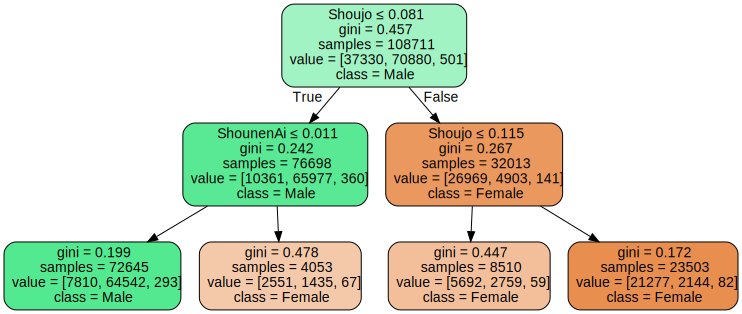

In [148]:
tree.export_graphviz(clf, out_file='gender_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [149]:
tree_to_table(clf, 'gender')

gender probability
Shoujo <= 8.1% ShounenAi <= 1.1%    Male      88.85%
               ShounenAi > 1.1%   Female      62.94%
Shoujo > 8.1%  Shoujo <= 11.5%    Female      66.89%
               Shoujo > 11.5%     Female      90.53%

In [150]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

             precision    recall  f1-score   support

     Female       0.84      0.72      0.78     37330
       Male       0.86      0.93      0.89     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.85      0.85      0.85    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender probability
Shoujo <= 8.1%    Male      86.02%
Shoujo > 8.1%   Female      84.24%

In [151]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

             precision    recall  f1-score   support

     Female       0.82      0.79      0.80     37330
       Male       0.89      0.91      0.90     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.86      0.87      0.86    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender probability
Shoujo <= 8.1% ShounenAi <= 1.1%    Male      88.85%
               ShounenAi > 1.1%   Female      62.94%
Shoujo > 8.1%  Shoujo <= 11.5%    Female      66.89%
               Shoujo > 11.5%     Female      90.53%

In [152]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

             precision    recall  f1-score   support

     Female       0.83      0.77      0.80     37330
       Male       0.88      0.92      0.90     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.86      0.87      0.86    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender probability
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%        Male      68.65%
                                 Ecchi > 2.1%         Male      91.68%
               ShounenAi > 1.1%  ShounenAi <= 2.0%    Male      51.66%
                                 ShounenAi > 2.0%   Female      72.40%
Shoujo > 8.1%  Shoujo <= 11.5%   ShounenAi <= 0.5%  Female      50.97%
                                 ShounenAi > 0.5%   Female      85.44%
               Shoujo > 11.5%    Josei <= 0.5%      Female      83.64%
                                 Josei > 0.5%       Female      94.25%

In [153]:
import pickle
with open('tree_clf.rick', 'wb+') as f:
    pickle.dump(clf, f)

In [172]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

             precision    recall  f1-score   support

     Female       0.86      0.77      0.81     37330
       Male       0.88      0.93      0.91     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.87      0.87      0.87    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender  \
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%     Sci-Fi <= 17.5%    Male   
                                                   Sci-Fi > 17.5%     Male   
                                 Ecchi > 2.1%      Shoujo <= 5.5%     Male   
                                                   Shoujo > 5.5%      Male   
               ShounenAi > 1.1%  ShounenAi <= 2.0% Shoujo <= 4.8%     Male   
                                                   Shoujo > 4.8%    Female   
                                 ShounenAi > 2.0%  Shoujo <= 4.5%   Female   
                                                   Shoujo > 4.5%    Female   
Shoujo > 8.1%  Shoujo <= 11.5%   ShounenAi <= 0.5% Ecchi <= 9.3%    Female   
                                                   Ecchi > 9.3%       Male   
                                 ShounenAi > 0.5%  Harem <= 11.2%   Female   
                                                   Harem > 11.2%    Female   
               Shoujo > 11.5%    Josei <= 0.5%     Shoujo <= 17.4%  Female   
                                                   Shoujo > 17.4%   Female   
                                 Josei > 0.5%      Shoujo <= 16.8%  Female   
                                                   Shoujo > 16.8%   Female   

                                                                   probability  
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%     Sci-Fi <= 17.5%      57.43%  
                                                   Sci-Fi > 17.5%       77.21%  
                                 Ecchi > 2.1%      Shoujo <= 5.5%       93.72%  
                                                   Shoujo > 5.5%        77.38%  
               ShounenAi > 1.1%  ShounenAi <= 2.0% Shoujo <= 4.8%       68.90%  
                                                   Shoujo > 4.8%        60.99%  
                                 ShounenAi > 2.0%  Shoujo <= 4.5%       61.23%  
                                                   Shoujo > 4.5%        79.06%  
Shoujo > 8.1%  Shoujo <= 11.5%   ShounenAi <= 0.5% Ecchi <= 9.3%        63.13%  
                                                   Ecchi > 9.3%         66.88%  
                                 ShounenAi > 0.5%  Harem <= 11.2%       87.39%  
                                                   Harem > 11.2%        61.74%  
               Shoujo > 11.5%    Josei <= 0.5%     Shoujo <= 17.4%      71.03%  
                                                   Shoujo > 17.4%       89.59%  
                                 Josei > 0.5%      Shoujo <= 16.8%      90.70%  
                                                   Shoujo > 16.8%       96.79%

In [173]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender')

             precision    recall  f1-score   support

     Female       0.87      0.76      0.81     37330
       Male       0.88      0.94      0.91     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.87      0.87      0.87    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender  \
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%     Sci-Fi <= 17.5% MartialArts <= 3.7%    Male   
                                                                   MartialArts > 3.7%     Male   
                                                   Sci-Fi > 17.5%  Shoujo <= 5.2%         Male   
                                                                   Shoujo > 5.2%          Male   
                                 Ecchi > 2.1%      Shoujo <= 5.5%  MartialArts <= 0.2%    Male   
                                                                   MartialArts > 0.2%     Male   
                                                   Shoujo > 5.5%   Romance <= 30.0%       Male   
                                                                   Romance > 30.0%        Male   
               ShounenAi > 1.1%  ShounenAi <= 2.0% Shoujo <= 4.8%  Harem <= 3.9%          Male   
                                                                   Harem > 3.9%           Male   
                                                   Shoujo > 4.8%   Harem <= 12.1%       Female   
                                                                   Harem > 12.1%          Male   
                                 ShounenAi > 2.0%  Shoujo <= 4.5%  Space <= 0.9%        Female   
                                                                   Space > 0.9%           Male   
                                                   Shoujo > 4.5%   Mecha <= 8.1%        Female   
                                                                   Mecha > 8.1%         Female   
Shoujo > 8.1%  Shoujo <= 11.5%   ShounenAi <= 0.5% Ecchi <= 9.3%   Mecha <= 8.2%        Female   
                                                                   Mecha > 8.2%           Male   
                                                   Ecchi > 9.3%    Mystery <= 14.4%       Male   
                                                                   Mystery > 14.4%      Female   
                                 ShounenAi > 0.5%  Harem <= 11.2%  Space <= 5.0%        Female   
                                                                   Space > 5.0%         Female   
                                                   Harem > 11.2%   Mecha <= 2.3%        Female   
                                                                   Mecha > 2.3%         Female   
               Shoujo > 11.5%    Josei <= 0.5%     Shoujo <= 17.4% ShounenAi <= 0.7%    Female   
                                                                   ShounenAi > 0.7%     Female   
                                                   Shoujo > 17.4%  Shoujo <= 25.7%      Female   
                                                                   Shoujo > 25.7%       Female   
                                 Josei > 0.5%      Shoujo <= 16.8% ShounenAi <= 0.1%    Female   
                                                                   ShounenAi > 0.1%     Female   
                                                   Shoujo > 16.8%  Action <= 80.9%      Female   
                                                                   Action > 80.9%         Male   

                                                                                       probability  
Shoujo <= 8.1% ShounenAi <= 1.1% Ecchi <= 2.1%     Sci-Fi <= 17.5% MartialArts <= 3.7%      52.02%  
                                                                   MartialArts > 3.7%       70.76%  
                                                   Sci-Fi > 17.5%  Shoujo <= 5.2%           80.10%  
                                                                   Shoujo > 5.2%            55.87%  
                                 Ecchi > 2.1%      Shoujo <= 5.5%  MartialArts <= 0.2%      83.93%  
                                                                   MartialArts > 0.2%       95.45%  
                                                   Shoujo > 5.5%   Romance <= 30.0%         62.57%  
                                             

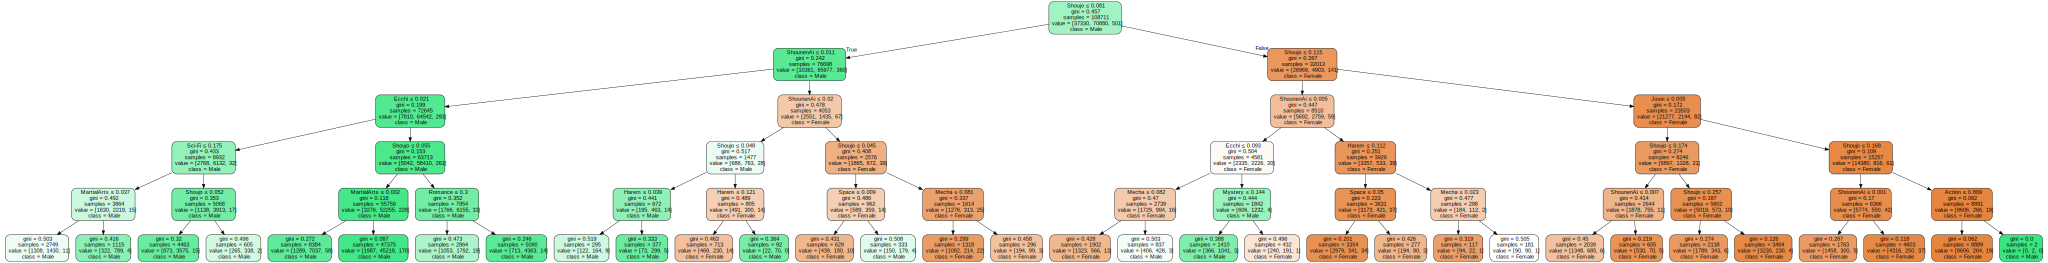

In [174]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [156]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.86      0.79      0.82     37330
       Male       0.89      0.93      0.91     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.88      0.88      0.88    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [157]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.87      0.79      0.83     37330
       Male       0.89      0.94      0.92     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.88      0.88      0.88    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [158]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.88      0.80      0.83     37330
       Male       0.89      0.94      0.92     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.88      0.89      0.89    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [159]:
# first, trying some depths

In [160]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.00      0.00      0.00     13097
   (20, 23]       0.31      0.38      0.34     25105
   (30, 40]       0.31      0.48      0.38     28370
   (23, 26]       0.36      0.45      0.40     26617
   (14, 17]       0.00      0.00      0.00     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.24      0.32      0.28    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [161]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.00      0.00      0.00     13097
   (20, 23]       0.33      0.26      0.29     25105
   (30, 40]       0.30      0.66      0.41     28370
   (23, 26]       0.38      0.37      0.38     26617
   (14, 17]       0.00      0.00      0.00     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.25      0.32      0.27    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [162]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.00      0.00      0.00     13097
   (20, 23]       0.32      0.56      0.41     25105
   (30, 40]       0.32      0.33      0.32     28370
   (23, 26]       0.38      0.44      0.41     26617
   (14, 17]       0.44      0.18      0.25     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.30      0.34      0.31    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [163]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.33      0.14      0.19     13097
   (20, 23]       0.33      0.41      0.37     25105
   (30, 40]       0.32      0.40      0.36     28370
   (23, 26]       0.39      0.48      0.43     26617
   (14, 17]       0.49      0.15      0.23     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.35      0.35      0.33    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [164]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.34      0.14      0.19     13097
   (20, 23]       0.34      0.50      0.40     25105
   (30, 40]       0.33      0.34      0.34     28370
   (23, 26]       0.39      0.49      0.44     26617
   (14, 17]       0.49      0.15      0.23     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.35      0.36      0.33    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [165]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.36      0.21      0.26     13097
   (20, 23]       0.35      0.45      0.39     25105
   (30, 40]       0.34      0.40      0.37     28370
   (23, 26]       0.41      0.46      0.43     26617
   (14, 17]       0.49      0.19      0.27     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.36      0.37      0.35    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [166]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.64      0.00      0.00      3077
   (17, 20]       0.38      0.19      0.26     13097
   (20, 23]       0.36      0.48      0.41     25105
   (30, 40]       0.35      0.43      0.39     28370
   (23, 26]       0.42      0.46      0.44     26617
   (14, 17]       0.52      0.19      0.28     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.40      0.38      0.37    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [167]:
clf = tree.DecisionTreeClassifier(max_depth=9)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.93      0.00      0.01      3077
   (17, 20]       0.39      0.25      0.31     13097
   (20, 23]       0.37      0.49      0.42     25105
   (30, 40]       0.37      0.44      0.40     28370
   (23, 26]       0.44      0.48      0.46     26617
   (14, 17]       0.54      0.22      0.31     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.42      0.40      0.39    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [175]:
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.69      0.02      0.04      3077
   (17, 20]       0.41      0.29      0.34     13097
   (20, 23]       0.40      0.50      0.44     25105
   (30, 40]       0.40      0.44      0.42     28370
   (23, 26]       0.45      0.53      0.49     26617
   (14, 17]       0.55      0.25      0.35     11555
   (40, 50]       0.67      0.00      0.01       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.44      0.42      0.41    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [168]:
# 5 depth seems like nice tradeoff based 
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.33      0.14      0.19     13097
   (20, 23]       0.33      0.41      0.37     25105
   (30, 40]       0.32      0.40      0.36     28370
   (23, 26]       0.39      0.48      0.43     26617
   (14, 17]       0.49      0.15      0.23     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.35      0.35      0.33    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


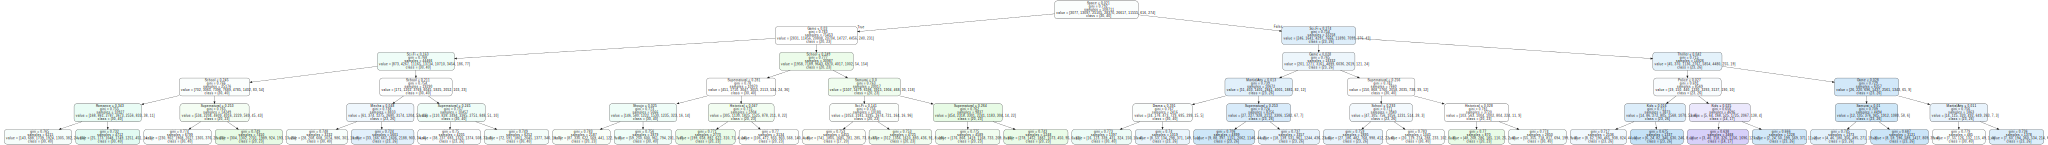

In [169]:
tree.export_graphviz(clf, out_file='age_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [170]:
tree_to_table(clf, 'age')

age  \
Space <= 2.1% Game <= 3.0%    Sci-Fi <= 16.3%  School <= 24.5%       Romance <= 34.3%       (30, 40]   
                                                                     Romance > 34.3%        (30, 40]   
                                               School > 24.5%        Supernatural <= 25.3%  (30, 40]   
                                                                     Supernatural > 25.3%   (20, 23]   
                              Sci-Fi > 16.3%   School <= 21.1%       Mecha <= 4.8%          (30, 40]   
                                                                     Mecha > 4.8%           (23, 26]   
                                               School > 21.1%        Supernatural <= 24.5%  (23, 26]   
                                                                     Supernatural > 24.5%   (30, 40]   
              Game > 3.0%     School <= 24.9%  Supernatural <= 28.1% Shoujo <= 2.5%         (20, 23]   
                                                                     Shoujo > 2.5%          (30, 40]   
                                               Supernatural > 28.1%  Historical <= 4.7%     (20, 23]   
                                                                     Historical > 4.7%      (20, 23]   
                              School > 24.9%   Samurai <= 0.0%       Sci-Fi <= 14.1%        (17, 20]   
                                                                     Sci-Fi > 14.1%         (20, 23]   
                                               Samurai > 0.0%        Supernatural <= 26.4%  (20, 23]   
                                                                     Supernatural > 26.4%   (20, 23]   
Space > 2.1%  Sci-Fi <= 27.4% Game <= 2.8%     MartialArts <= 1.3%   Drama <= 39.1%         (30, 40]   
                                                                     Drama > 39.1%          (23, 26]   
                                               MartialArts > 1.3%    Supernatural <= 25.3%  (23, 26]   
                                                                     Supernatural > 25.3%   (23, 26]   
                              Game > 2.8%      Supernatural <= 25.6% School <= 29.3%        (23, 26]   
                                                                     School > 29.3%         (30, 40]   
                                               Supernatural > 25.6%  Historical <= 2.8%     (20, 23]   
                                                                     Historical > 2.8%      (30, 40]   
              Sci-Fi > 27.4%  Thriller <= 4.2% Police <= 2.7%        Kids <= 1.6%           (23, 26]   
                                                                     Kids > 1.6%            (23, 26]   
                                               Police > 2.7%         Kids <= 2.5%           (14, 17]   
                                                                     Kids > 2.5%            (23, 26]   
                              Thriller > 4.2%  Game <= 2.8%          Samurai <= 1.0%        (23, 26]   
                                                                     Samurai > 1.0%         (23, 26]   
                                               Game > 2.8%           MartialArts <= 1.1%    (30, 40]   
                                                                     MartialArts > 1.1%     (23, 26]   

                                                                                           probability  
Space <= 2.1% Game <= 3.0%    Sci-Fi <= 16.3%  School <= 24.5%       Romance <= 34.3%           30.96%  
                                                                     Romance > 34.3%            37.12%  
                                               School > 24.5%        Supernatural <= 25.3%      29.81%  
                                                                     Supernatural > 25.3%       36.26%  
                              Sci-Fi > 16.3%   School <= 21.1%       Mecha <= 4.8%              33.23%  
                                  

### genres in completed animests, compared with genres production

In [177]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
genres_arr = genres_arr[genres_arr['genre'] != '']
genres_arr.index.levels[0].name = 'anime_id'
animes_genres = pd.merge(animes, genres_arr, how='left', left_index=True, right_index=True)

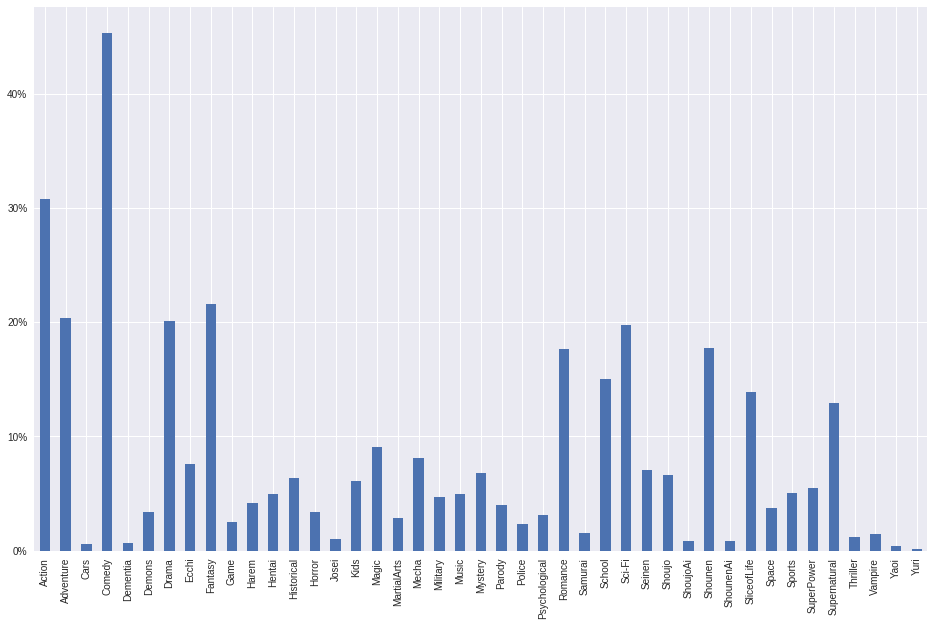

In [178]:
(animes_genres['genre'].value_counts() / animes.shape[0]).sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

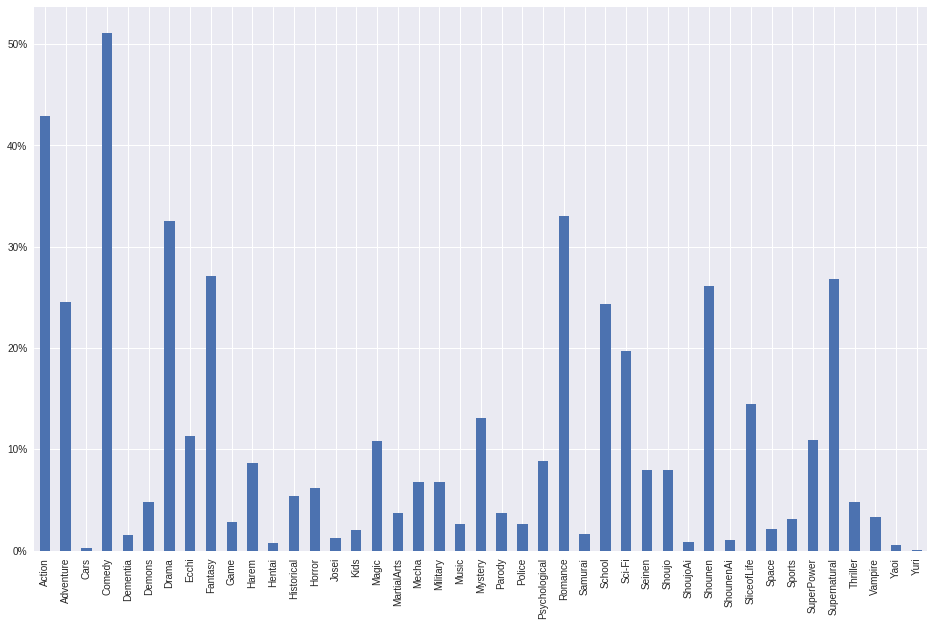

In [194]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index().plot(kind='bar', figsize=(16, 10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

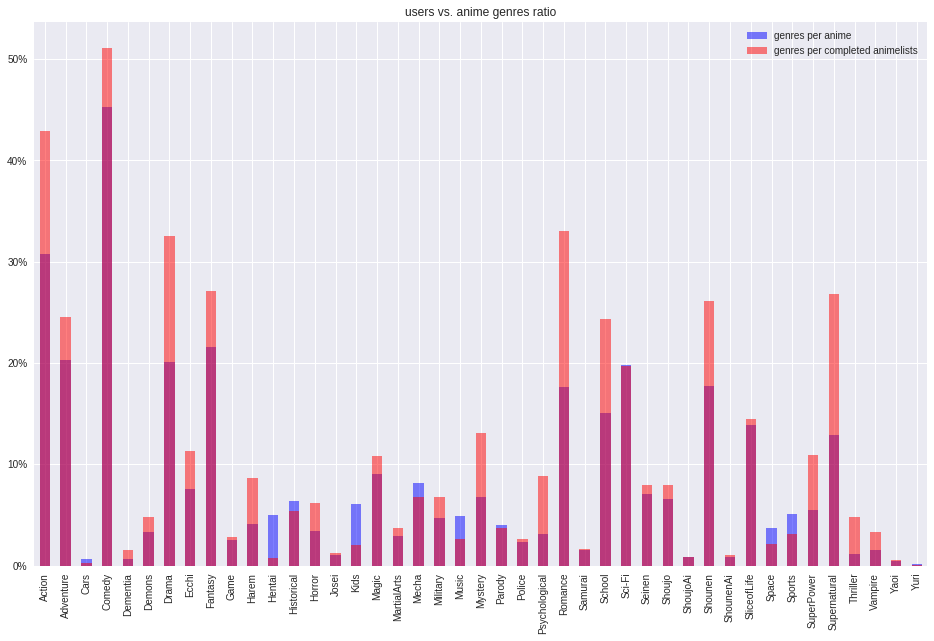

In [198]:
renaming = {x: x.replace('completed_', '') for x in completed_columns}
anime_genres_percent = (animes_genres['genre'].value_counts() / animes.shape[0]).sort_index()
anime_genres_percent.plot(kind='bar', figsize=(16, 10), title='users vs. anime genres ratio', color='blue', alpha=0.5, label='genres per anime')
users_genres_percent = users[completed_columns].rename(columns=renaming).div(users['all_completed'], axis=0).mean().sort_index()
users_genres_percent.plot(kind='bar', color='red', alpha=0.5, label='genres per completed animelists')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=1)

In [204]:
# using new classes for users, both gender and age bin will be class, will try whether decision trees will have bigger success
users_ages_genders_completed = users_ages_completed.join(users_genders_completed['gender'])
users_ages_genders_completed['age_and_gender'] = users_ages_genders_completed['age_bin'] + ', ' + users_ages_genders_completed['gender']

In [208]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       0.00      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       0.00      0.00      0.00      4337
    (20, 23], Female       0.00      0.00      0.00      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       0.27      0.49      0.35      9499
    (23, 26], Female       0.23      0.67      0.35     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       0.00      0.00      0.00     10772
    (14, 17], Female       0.00      0.00      0.00     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       0.27      0.50      0.35      8233
       (9, 14], Male       0.32      0.55      0.40     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age probability
Shoujo <= 8.1% Mecha <= 6.7%    (23, 26], Female      23.26%
               Mecha > 6.7%        (9, 14], Male      31.59%
Shoujo > 8.1%  School <= 21.9%    (40, 50], Male      27.40%
               School > 21.9%     (20, 23], Male      27.22%

In [207]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       0.00      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       0.00      0.00      0.00      4337
    (20, 23], Female       0.00      0.00      0.00      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       0.27      0.49      0.35      9499
    (23, 26], Female       0.28      0.44      0.34     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       0.31      0.28      0.30     10772
    (14, 17], Female       0.22      0.26      0.24     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       0.33      0.22      0.26      8233
       (9, 14], Male       0.32      0.55      0.40     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age probability
Shoujo <= 8.1% Mecha <= 6.7%   Game <= 2.8%     (14, 17], Female      22.30%
                               Game > 2.8%      (23, 26], Female      28.18%
               Mecha > 6.7%    Space <= 3.2%       (9, 14], Male      27.11%
                               Space > 3.2%        (9, 14], Male      36.09%
Shoujo > 8.1%  School <= 21.9% Space <= 1.7%    (30, 40], Female      31.49%
                               Space > 1.7%       (40, 50], Male      33.06%
               School > 21.9%  Shoujo <= 11.9%    (20, 23], Male      19.69%
                               Shoujo > 11.9%     (20, 23], Male      30.02%

In [209]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       0.00      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       0.00      0.00      0.00      4337
    (20, 23], Female       0.00      0.00      0.00      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       0.27      0.33      0.30      9499
    (23, 26], Female       0.28      0.53      0.37     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       0.31      0.40      0.34     10772
    (14, 17], Female       0.24      0.25      0.24     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       0.32      0.32      0.32      8233
       (9, 14], Male       0.34      0.49      0.40     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age  \
Shoujo <= 8.1% Mecha <= 6.7%   Game <= 2.8%    ShounenAi <= 1.1%   (14, 17], Female   
                                               ShounenAi > 1.1%    (30, 40], Female   
                               Game > 2.8%     Historical <= 2.2%  (23, 26], Female   
                                               Historical > 2.2%   (23, 26], Female   
               Mecha > 6.7%    Space <= 3.2%   Game <= 3.2%           (9, 14], Male   
                                               Game > 3.2%         (23, 26], Female   
                               Space > 3.2%    Game <= 2.7%           (9, 14], Male   
                                               Game > 2.7%            (9, 14], Male   
Shoujo > 8.1%  School <= 21.9% Space <= 1.7%   Sci-Fi <= 17.3%     (30, 40], Female   
                                               Sci-Fi > 17.3%        (40, 50], Male   
                               Space > 1.7%    Sci-Fi <= 25.5%       (40, 50], Male   
                                               Sci-Fi > 25.5%        (40, 50], Male   
               School > 21.9%  Shoujo <= 11.9% ShounenAi <= 0.6%     (20, 23], Male   
                                               ShounenAi > 0.6%      (20, 23], Male   
                               Shoujo > 11.9%  Drama <= 37.9%        (20, 23], Male   
                                               Drama > 37.9%       (30, 40], Female   

                                                                  probability  
Shoujo <= 8.1% Mecha <= 6.7%   Game <= 2.8%    ShounenAi <= 1.1%       23.72%  
                                               ShounenAi > 1.1%        23.41%  
                               Game > 2.8%     Historical <= 2.2%      29.73%  
                                               Historical > 2.2%       27.23%  
               Mecha > 6.7%    Space <= 3.2%   Game <= 3.2%            31.29%  
                                               Game > 3.2%             25.75%  
                               Space > 3.2%    Game <= 2.7%            37.78%  
                                               Game > 2.7%             32.84%  
Shoujo > 8.1%  School <= 21.9% Space <= 1.7%   Sci-Fi <= 17.3%         33.18%  
                                               Sci-Fi > 17.3%          29.09%  
                               Space > 1.7%    Sci-Fi <= 25.5%         36.12%  
                                               Sci-Fi > 25.5%          28.26%  
               School > 21.9%  Shoujo <= 11.9% ShounenAi <= 0.6%       14.12%  
                                               ShounenAi > 0.6%        28.30%  
                               Shoujo > 11.9%  Drama <= 37.9%          32.20%  
                                               Drama > 37.9%           29.60%

In [210]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       0.00      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       0.00      0.00      0.00      4337
    (20, 23], Female       0.30      0.12      0.17      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       0.29      0.44      0.35      9499
    (23, 26], Female       0.29      0.41      0.34     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       0.31      0.35      0.33     10772
    (14, 17], Female       0.24      0.36      0.29     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       0.34      0.28      0.31      8233
       (9, 14], Male       0.36      0.46      0.40     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age  \
Shoujo <= 8.1% Mecha <= 6.7%   Game <= 2.8%    ShounenAi <= 1.1%  MartialArts <= 0.5%  (14, 17], Female   
                                                                  MartialArts > 0.5%   (14, 17], Female   
                                               ShounenAi > 1.1%   Sci-Fi <= 15.7%        (20, 23], Male   
                                                                  Sci-Fi > 15.7%       (30, 40], Female   
                               Game > 2.8%     Historical <= 2.2% Sci-Fi <= 13.0%      (20, 23], Female   
                                                                  Sci-Fi > 13.0%       (23, 26], Female   
                                               Historical > 2.2%  ShounenAi <= 0.7%    (23, 26], Female   
                                                                  ShounenAi > 0.7%       (20, 23], Male   
               Mecha > 6.7%    Space <= 3.2%   Game <= 3.2%       MartialArts <= 1.4%  (14, 17], Female   
                                                                  MartialArts > 1.4%      (9, 14], Male   
                                               Game > 3.2%        Samurai <= 0.2%      (23, 26], Female   
                                                                  Samurai > 0.2%       (14, 17], Female   
                               Space > 3.2%    Game <= 2.7%       Police <= 1.9%          (9, 14], Male   
                                                                  Police > 1.9%           (9, 14], Male   
                                               Game > 2.7%        Sci-Fi <= 31.7%         (9, 14], Male   
                                                                  Sci-Fi > 31.7%          (9, 14], Male   
Shoujo > 8.1%  School <= 21.9% Space <= 1.7%   Sci-Fi <= 17.3%    Drama <= 35.6%       (30, 40], Female   
                                                                  Drama > 35.6%        (30, 40], Female   
                                               Sci-Fi > 17.3%     ShounenAi <= 0.4%    (30, 40], Female   
                                                                  ShounenAi > 0.4%       (40, 50], Male   
                               Space > 1.7%    Sci-Fi <= 25.5%    School <= 14.5%        (40, 50], Male   
                                                                  School > 14.5%         (40, 50], Male   
                                               Sci-Fi > 25.5%     ShounenAi <= 0.9%      (40, 50], Male   
                                                                  ShounenAi > 0.9%       (40, 50], Male   
               School > 21.9%  Shoujo <= 11.9% ShounenAi <= 0.6%  Romance <= 40.4%       (20, 23], Male   
                                                                  Romance > 40.4%      (14, 17], Female   
                                               ShounenAi > 0.6%   Sci-Fi <= 14.1%        (20, 23], Male   
                                                                  Sci-Fi > 14.1%         (20, 23], Male   
                               Shoujo > 11.9%  Drama <= 37.9%     School <= 27.5%        (20, 23], Male   
                                                                  School > 27.5%         (20, 23], Male   
                                               Drama > 37.9%      School <= 31.8%      (30, 40], Female   
                                                                  School > 31.8%         (20, 23], Male   

                                                                                      probability  
Shoujo <= 8.1% Mecha <= 6.7%   Game <= 2.8%    ShounenAi <= 1.1%  MartialArts <= 0.5%      17.13%  
                                                                  MartialArts > 0.5%       26.51%  
                                               ShounenAi > 1.1%   Sci-Fi <= 15.7%          27.55%  
                                                                  Sci-Fi > 15.7%           25.06%  
                               Game > 2.8%     Historical

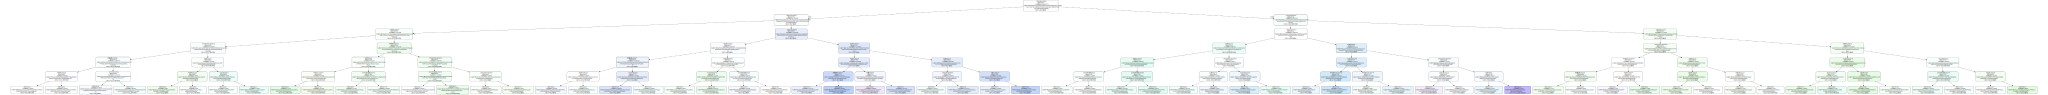

In [212]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_genders_completed['age_and_gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [211]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_ages_genders_completed[completed_columns], users_ages_genders_completed['age_and_gender'])
y_true = users_ages_genders_completed['age_and_gender']
y_pred = clf.predict(users_ages_genders_completed[completed_columns])
target_names = users_ages_genders_completed['age_and_gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf, 'gender and age')

                      precision    recall  f1-score   support

    (26, 30], Female       0.00      0.00      0.00      1098
      (26, 30], Male       0.00      0.00      0.00      1927
    (17, 20], Female       0.00      0.00      0.00        52
      (17, 20], Male       0.28      0.03      0.05      4337
    (20, 23], Female       0.32      0.10      0.15      8624
      (30, 40], Male       0.00      0.00      0.00       136
      (20, 23], Male       0.31      0.35      0.33      9499
    (23, 26], Female       0.28      0.51      0.36     15471
      (23, 26], Male       0.00      0.00      0.00       135
    (30, 40], Female       0.28      0.48      0.36     10772
    (14, 17], Female       0.28      0.17      0.21     17513
      (14, 17], Male       0.00      0.00      0.00        85
      (40, 50], Male       0.36      0.25      0.29      8233
       (9, 14], Male       0.34      0.52      0.41     18322
(26, 30], Non-Binary       0.00      0.00      0.00        62
(17, 20

/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gender and age  \
Shoujo <= 8.1% Mecha <= 6.7%   Game <= 2.8%    ShounenAi <= 1.1%  MartialArts <= 0.5% Harem <= 3.6%              (30, 40], Female   
                                                                                      Harem > 3.6%               (23, 26], Female   
                                                                  MartialArts > 0.5%  School <= 29.5%               (9, 14], Male   
                                                                                      School > 29.5%             (14, 17], Female   
                                               ShounenAi > 1.1%   Sci-Fi <= 15.7%     Harem <= 12.3%               (20, 23], Male   
                                                                                      Harem > 12.3%              (14, 17], Female   
                                                                  Sci-Fi > 15.7%      Josei <= 1.4%              (30, 40], Female   
                                                                                      Josei > 1.4%               (30, 40], Female   
                               Game > 2.8%     Historical <= 2.2% Sci-Fi <= 13.0%     Parody <= 0.7%             (23, 26], Female   
                                                                                      Parody > 0.7%              (20, 23], Female   
                                                                  Sci-Fi > 13.0%      Supernatural <= 24.2%      (23, 26], Female   
                                                                                      Supernatural > 24.2%       (23, 26], Female   
                                               Historical > 2.2%  ShounenAi <= 0.7%   Supernatural <= 26.4%      (23, 26], Female   
                                                                                      Supernatural > 26.4%       (23, 26], Female   
                                                                  ShounenAi > 0.7%    ShounenAi <= 2.0%          (23, 26], Female   
                                                                                      ShounenAi > 2.0%             (20, 23], Male   
               Mecha > 6.7%    Space <= 3.2%   Game <= 3.2%       MartialArts <= 1.4% Game <= 1.5%                  (9, 14], Male   
                                                                                      Game > 1.5%                (14, 17], Female   
                                                                  MartialArts > 1.4%  School <= 28.0%               (9, 14], Male   
                                                                                      School > 28.0%             (14, 17], Female   
                                               Game > 3.2%        Samurai <= 0.2%     School <= 24.1%            (23, 26], Female   
                                                                                      School > 24.1%             (23, 26], Female   
                                                                  Samurai > 0.2%      Supernatural <= 26.0%         (9, 14], Male   
                                                                                      Supernatural > 26.0%       (23, 26], Female   
                               Space > 3.2%    Game <= 2.7%       Police <= 1.9%      MartialArts <= 2.4%           (9, 14], Male   
                                                                                      MartialArts > 2.4%            (9, 14], Male   
                                                                  Police > 1.9%       Thriller <= 3.9%       (23, 26], Non-Binary   
                                                                                      Thriller > 3.9%               (9, 14], Male   
                                               Game > 2.7%        Sci-Fi <= 31.7%     ShoujoAi <= 0.2%           (14, 17], Female   
                                                                                      ShoujoAi > 0.2%               (9, 14], 

### nothing interesting in decision trees above, gender does not bring precision into age prediction
### going to measure genre distances by users animelists

<IPython.core.display.Javascript object>


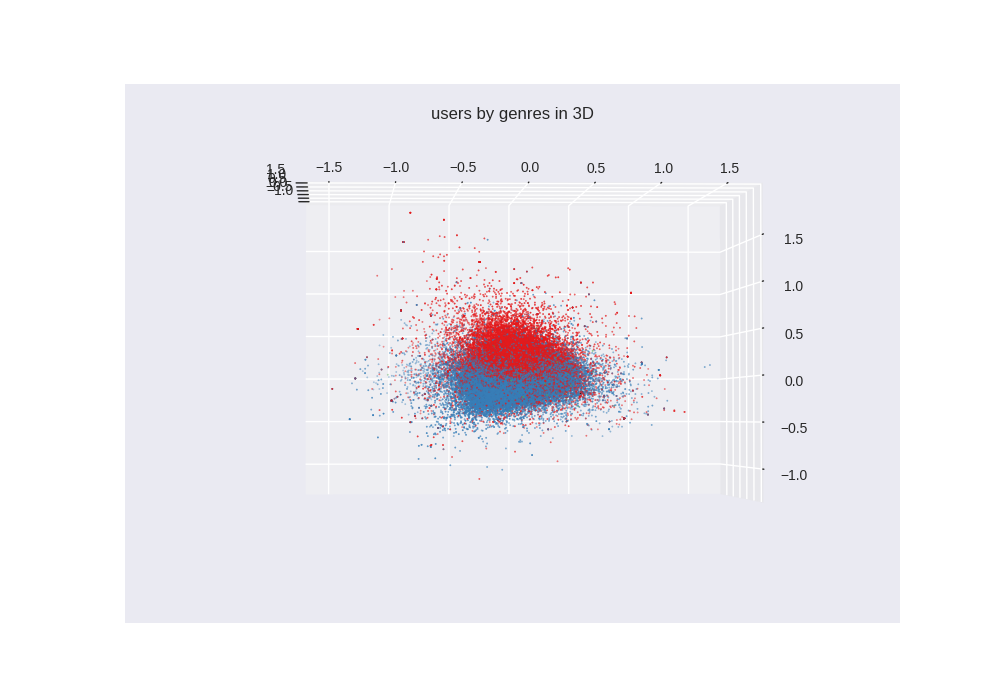

Text(0.5,0.92,'users by genres in 3D')

In [243]:
%matplotlib notebook
# doing PCA on genres distribution
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components=3)
embeddings = pca.fit_transform(users_ages_genders_completed[completed_columns])

plt.figure(figsize=(10, 7))

# colors per gender
ax = plt.axes(projection='3d')
le = preprocessing.LabelEncoder()
genders = le.fit_transform(users_ages_genders_completed['gender'])
genders = genders.astype(np.int)
colors = plt.cm.Set1(np.unique(genders))
ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=1, c=[colors[x] for x in genders])
plt.title("users by genres in 3D")

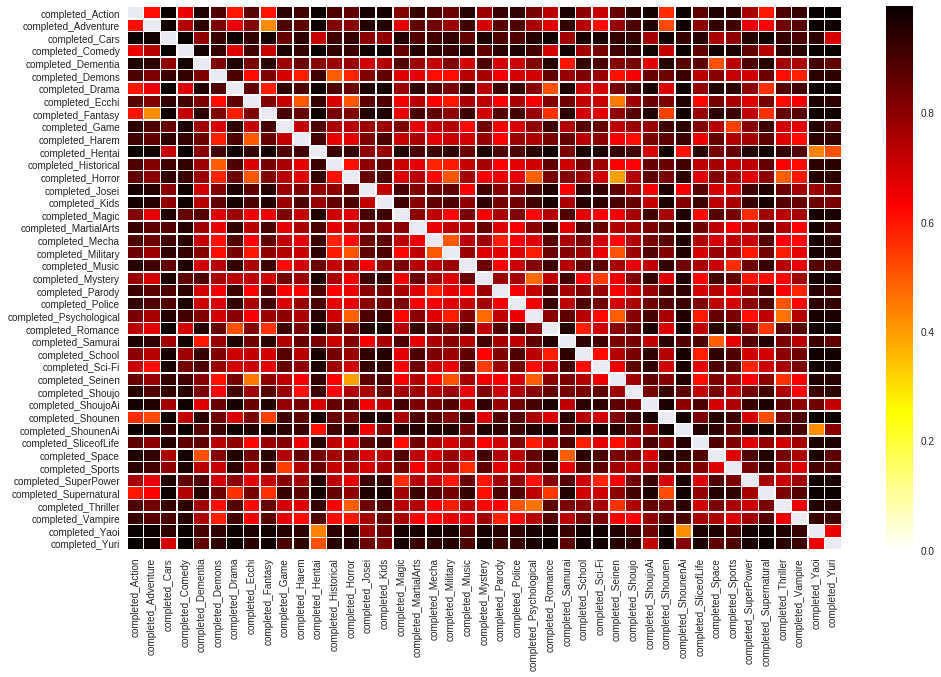

In [261]:
def nsd(x, y):
    return (max(np.log(x.sum()), np.log(y.sum())) - np.log((x & y).sum())) / (np.log(x.size) - min(np.log(x.sum()), np.log(y.sum())))

# todo: vymyslet co s tím, když je to spojité a ne binární
%matplotlib inline

renaming = {x: x.replace('completed_', '') for x in completed_columns}
dists = pdist(users_completed[completed_columns].rename(columns=renaming).T > 0, lambda x, y: nsd(x, y))
dists_m = squareform(dists)
dists_m[dists_m == np.inf] = 0  # infinities mess color scale

dists_df = pd.DataFrame(dists_m)
dists_df.columns = users_completed.T.index
dists_df.index = users_completed.T.index

f, ax = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True
sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

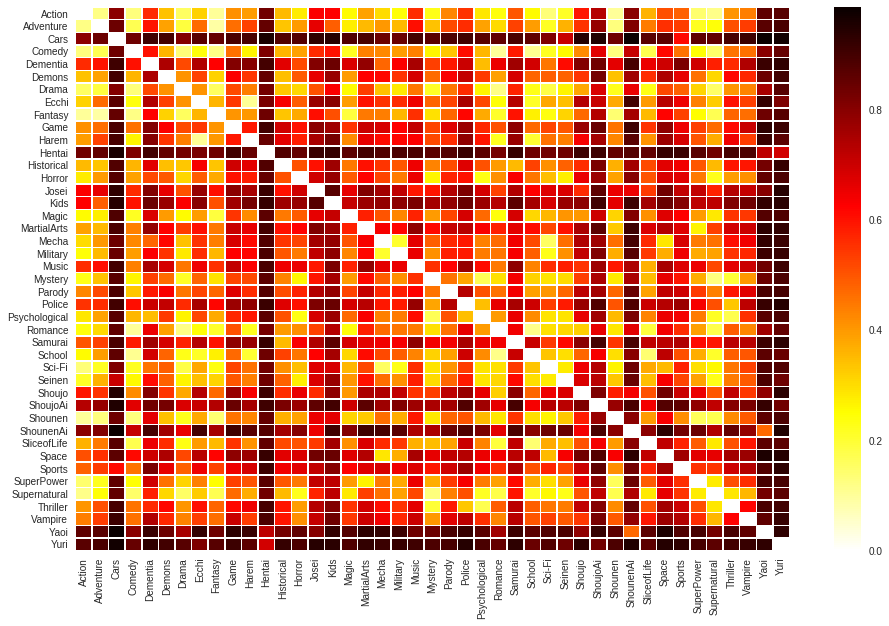

In [280]:
%matplotlib inline

renaming = {x: x.replace('completed_', '') for x in completed_columns}
genres_users = users_completed[completed_columns].rename(columns=renaming).T
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(dists_df, linewidths=.5, cmap=plt.cm.hot_r)

7

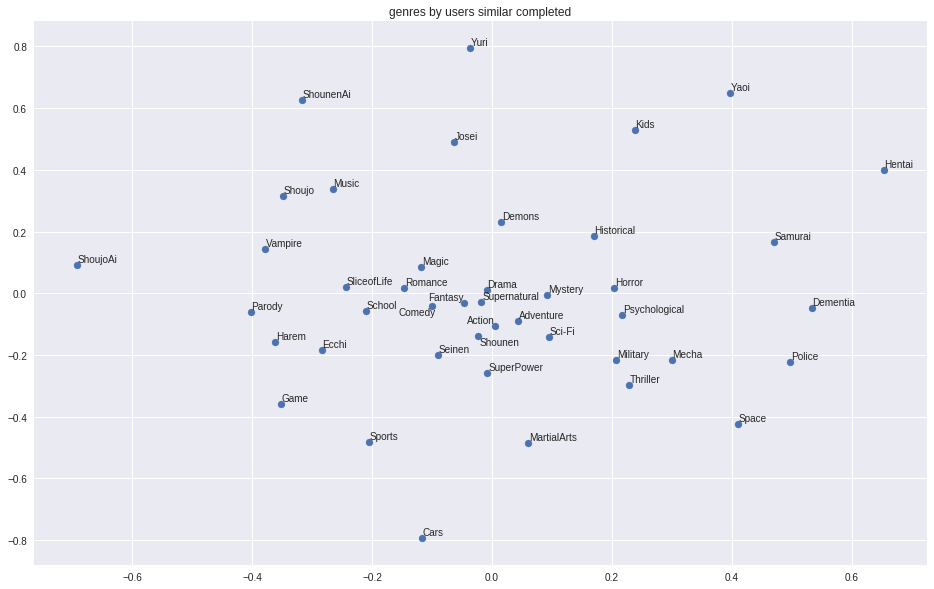

In [281]:
embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)
# need to agregate animes_studios because it does not contain duplicities because of genres
plt.figure(figsize=(16, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.title("genres by users similar completed")
texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

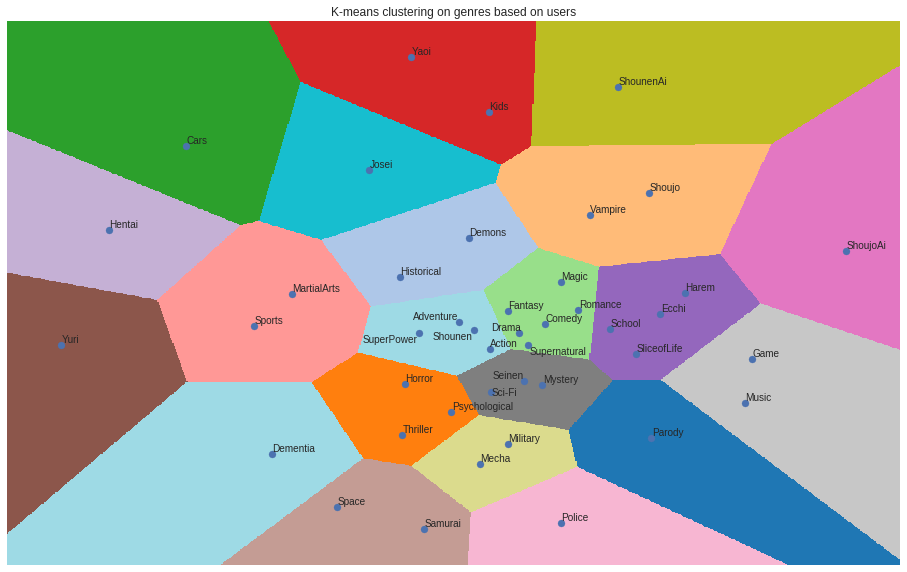

In [282]:
from sklearn.cluster import KMeans

embedder = manifold.MDS(2, max_iter=2000, n_init=5, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

kmeans = KMeans(init='k-means++', n_clusters=21, n_init=10)
kmeans.fit(embeddings)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .002     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embeddings[:, 0].min() - 0.1, embeddings[:, 0].max() + 0.1
y_min, y_max = embeddings[:, 1].min() - 0.1, embeddings[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.tab20,
           aspect='auto', origin='lower')

plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.plot(embeddings[:, 0], embeddings[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
plt.title('K-means clustering on genres based on users')

texts = [plt.text(embeddings[i, 0], embeddings[i, 1], txt) for i, txt in enumerate(dists_df.index)]
adjust_text(texts)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

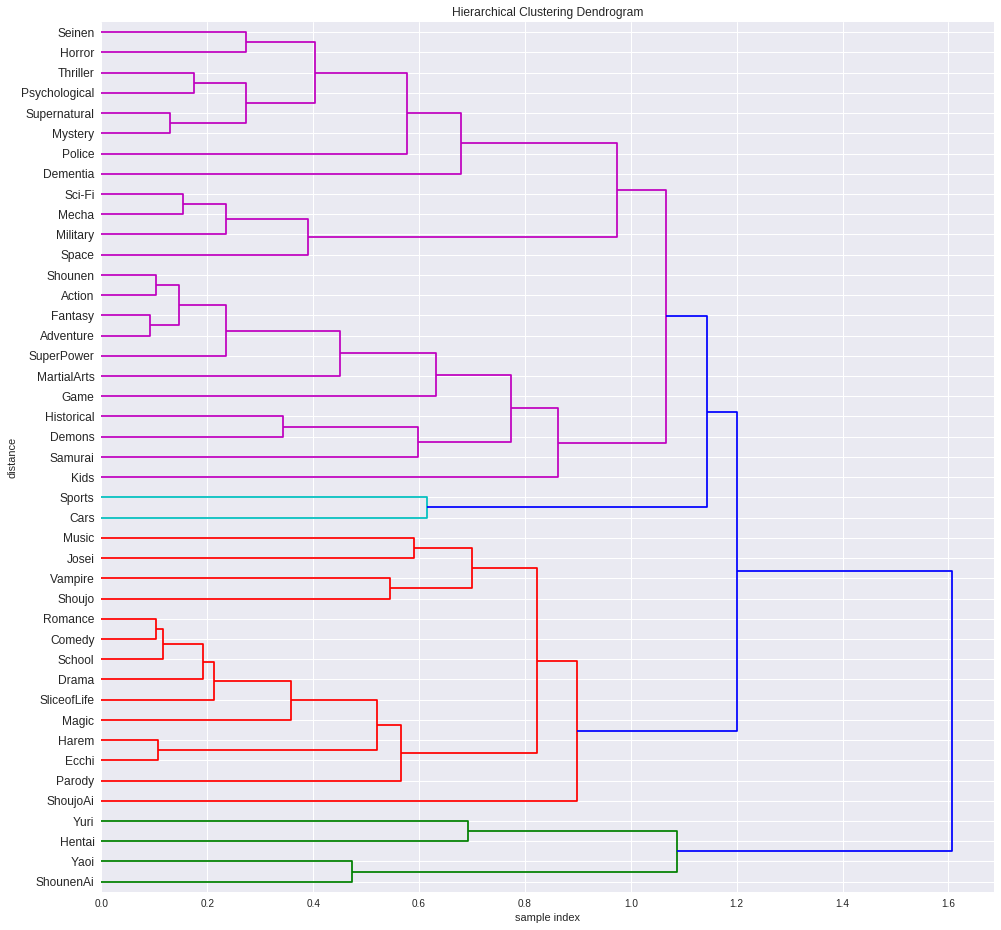

In [283]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix 
# squareform transfers between condensed and redundant distance form
Z = linkage(squareform(dists_m), 'ward')

# calculate full dendrogram
plt.figure(figsize=(16, 16))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='right',
    labels=dists_df.index
)
plt.show()

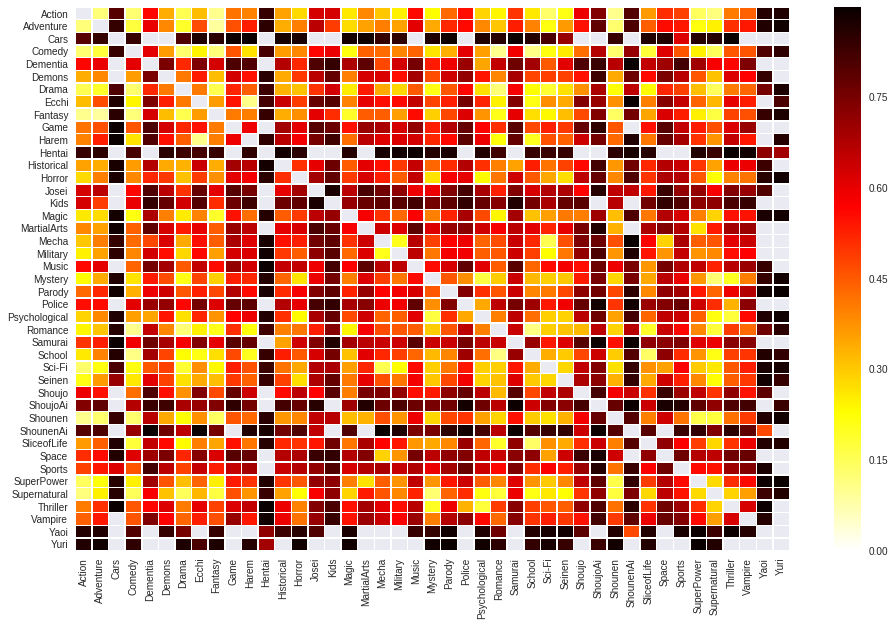

In [291]:
# now with thresholding, more than 0.9 dissimilarity is undefined
f, ax = plt.subplots(figsize=(16, 10))
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_m[dists_m > 0.9] = 0
dists_df = pd.DataFrame(dists_m)
dists_df.columns = genres_users.index
dists_df.index = genres_users.index

mask = np.zeros_like(dists_df, dtype=np.bool)
mask[dists_df == 0] = True

sns.heatmap(dists_df, mask=mask, linewidths=.5, cmap=plt.cm.hot_r)

In [293]:
def init(sizes):
    def my_init():
        ax.scatter3D(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=sizes)
        return fig,
    return my_init

def animate(i):
    ax.azim = ax.azim - 2
    ax.view_init(ax.elev, ax.azim)
    return fig,

def points_3d_to_gif(embeddings, labels, gif_filename, ax, sizes):
    for i, txt in enumerate(labels):
        ax.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], txt)

    #plt.axis('off')
    #ax.grid(False)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.elev = 25.
    ax.azim = 321.
    ax.dist = 11.

    # Animate, interval in ms, frames == # of frames in animation
    anim = animation.FuncAnimation(fig, animate, init_func=init(sizes),
                                   frames=180, interval=80, blit=True)
    # Save
    anim.save('images/{}.gif'.format(gif_filename), dpi=80, writer='imagemagick')


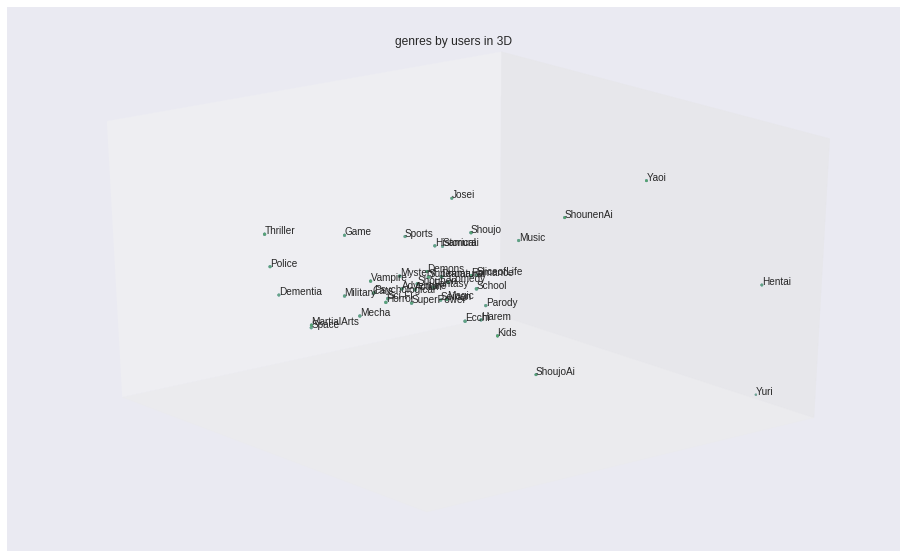

In [298]:
dists = pdist(genres_users, 'cosine')
dists_m = squareform(dists)
dists_m[dists_m > 0.9] = 0  # I need to set infinities to zeros, then it handles infinities as missing data, which is wanted
embedder = manifold.MDS(3, metric=False, max_iter=2000, n_init=10, dissimilarity='precomputed')
embeddings = embedder.fit_transform(dists_m)

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')

plt.title("genres by users in 3D")
points_3d_to_gif(embeddings, genres_users.index, 'genres_users-cosine-MSD', ax, genres_users.sum(axis=1).apply(np.log))

In [300]:
pairs = np.array(list(combinations(genres_users.index, 2)))

# for gephi, higher edge cost means higher similarity
edges = pd.DataFrame({'source': pairs[:, 0], 'target': pairs[:, 1], 'weight': 1-dists})
edges = edges[edges['weight'] != np.inf]

nodes = pd.DataFrame({'id': genres_users.index, 'label': genres_users.index})
edges['type'] = 'undirected'

nodes.to_csv('genres_users_nodes.csv', index=False, sep=',', encoding='utf-8')
edges.to_csv('genres_users_edges_cosine.csv', index=False, sep=',', encoding='utf-8')